In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd


/content


In [3]:
!mkdir "/content/CheckpointsMNIST"
!cp "/content/drive/MyDrive/CSProj/shortDDPM FDana/200epoch.pt" "/content/CheckpointsMNIST/"

mkdir: cannot create directory ‘/content/CheckpointsMNIST’: File exists


In [4]:
# 放在程式最頂端、import torch 之前
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"   # 每次 CUDA 呼叫都同步執行
# os.environ["TORCH_USE_CUDA_DSA"]    = "1"   # Device‑side assertions


In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Subset
from collections import defaultdict
import random


def show_tensor_images_grid(tensor_data, printImg=False):
    """
    將 PyTorch tensor 中的圖片以灰階顯示，橫軸圖片數量從 [1, 2, 4, 8, 16] 中自動選擇最適合的數量。
    :param tensor_data: 要顯示的 PyTorch tensor, 預期形狀為 (batch, channels, height, width)
    :param printImg: 是否顯示圖片 (默認 True)
    """
    printImg=False
    if not printImg:
        return

    # 確保 tensor 在 CPU，並轉換為 numpy
    tensor_data = tensor_data.detach().cpu().numpy()

    # 檢查資料的形狀 (batch, channels, height, width)
    batch_size, channels, height, width = tensor_data.shape

    # 橫軸候選值
    candidates = [1, 2, 4, 8, 16]
    # 選擇最適合的橫軸數量，使總行數最小
    images_per_row = min(candidates, key=lambda x: math.ceil(batch_size / x))

    # 計算行數
    num_rows = math.ceil(batch_size / images_per_row)

    # 建立圖表
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row, num_rows))
    axes = np.array(axes).reshape(num_rows, images_per_row)  # 確保 axes 是矩陣結構

    for i in range(num_rows * images_per_row):
        row, col = divmod(i, images_per_row)
        ax = axes[row, col]

        if i < batch_size:
            img = tensor_data[i]

            # 如果是 RGB 圖片（3 通道），轉換為灰階（使用第一個通道）
            if channels == 3:
                img = img[0]  # 使用第一個通道
            elif channels == 1:  # 單通道（灰階）
                img = img.squeeze(0)

            # 顯示圖片
            ax.imshow(img, cmap="gray")
        ax.axis("off")  # 隱藏座標軸

    plt.tight_layout()
    plt.show()


# 測試範例
if __name__ == "__main__":
    # 模擬一個隨機的 80x3x32x32 圖像資料並放到 GPU 上
    sample_data = torch.randn(32, 3, 32, 32).cuda()  # 放到 GPU
    show_tensor_images_grid(sample_data)


# Config

In [6]:
def set_config(args, custom_dataset="haha"):
    available_dataaset = ['Imagenet', 'CIFAR10', 'MNIST']
    if custom_dataset not in available_dataaset:
        ValueError(f'{custom_dataset} is not availabel, please select from {available_dataaset}')
    if custom_dataset == 'Imagenet':
        print(f"Config : {custom_dataset}")
        model_config = {
            "dataset" : args['dataset'],
            "state": args['state'],#"train", # or eval
            "epoch": args['epochs'],
            "batch_size": args['batch_size'],
            "T": 1000,
            "channel": 128,
            "channel_mult": [1, 2, 3, 4],
            "attn": [2],
            "num_res_blocks": 2,
            "dropout": 0.15,
            "lr": 1e-4,
            "multiplier": 2.,
            "beta_1": 1e-4,
            "beta_T": 0.02,
            "img_size": 128,
            "grad_clip": 1.,
            "device": "cuda:0", ### MAKE SURE YOU HAVE A GPU !!!
            "training_load_weight": f"{args['split_class']}_ckpt_{args['load_training_checkpoint']}_.pt",
            "save_weight_dir": "./Checkpoints" + args['dataset'] + "/",
            "test_load_weight": f"{str(args['split_class'])}_ckpt_{args['load_training_checkpoint']+args['epochs']-1}_.pt",
            "sampled_dir": "./SampledImgs" + args['dataset'] +"/",
            "sampledNoisyImgName": f"NoisyNoGuidenceImgs{args['load_training_checkpoint']+args['epochs']-1}.png",
            "sampledImgName": f"SampledNoGuidenceImgs{args['load_training_checkpoint']+args['epochs']-1}.png",
            "nrow": 8
        }
    if custom_dataset == 'CIFAR10':
        print(f"Config : {custom_dataset}")
        model_config = {
            "dataset" : args['dataset'],
            "state": args['state'],#"train", # or eval
            "epoch": args['epochs'],
            "batch_size": args['batch_size'],
            "T": 1000,
            "channel": 128,
            "channel_mult": [1, 2, 3, 4],
            "attn": [2],
            "num_res_blocks": 2,
            "dropout": 0.15,
            "lr": 1e-4,
            "multiplier": 2.,
            "beta_1": 1e-4,
            "beta_T": 0.02,
            "img_size": 128,
            "grad_clip": 1.,
            "device": "cuda:0", ### MAKE SURE YOU HAVE A GPU !!!
            "training_load_weight": f"{str(args['split_class'])}_ckpt_{args['load_training_checkpoint']}_.pt",
            "save_weight_dir": "./Checkpoints" + args['dataset'] + "/",
            "test_load_weight": f"{str(args['split_class'])}_ckpt_{args['load_training_checkpoint']+args['epochs']-1}_.pt",
            "sampled_dir": "./SampledImgs" + args['dataset'] +"/",
            "sampledNoisyImgName": f"NoisyNoGuidenceImgs{args['load_training_checkpoint']+args['epochs']-1}.png",
            "sampledImgName": f"SampledNoGuidenceImgs{args['load_training_checkpoint']+args['epochs']-1}.png",
            "nrow": 8
        }
    if custom_dataset == 'MNIST':
        print(f"Config : {custom_dataset}")
        model_config = {
            "dataset" : args['dataset'],
            "state": args['state'],#"train", # or eval
            "epoch": args['epochs'],
            "batch_size": args['batch_size'],
            "T": 1000,
            "channel": 128,
            "channel_mult": [1, 2, 3, 4],
            "attn": [2],
            "num_res_blocks": 2,
            "dropout": 0.15,
            "lr": 1e-4,
            "multiplier": 2.,
            "beta_1": 1e-4,
            "beta_T": 0.02,
            "img_size": 128,
            "grad_clip": 1.,
            "device": "cuda:0", ### MAKE SURE YOU HAVE A GPU !!!
            "training_load_weight": f"{str(args['split_class'])}_ckpt_{args['load_training_checkpoint']}_.pt",
            "save_weight_dir": "./Checkpoints" + args['dataset'] + "/",
#             "test_load_weight": f"{str(args['split_class'])}_ckpt_{args['load_training_checkpoint']+args['epochs']-1}_.pt",
            "test_load_weight": args["test_load_weight"],
            "sampled_dir": "./SampledImgs" + args['dataset'] +"/",
            "sampledNoisyImgName": f"NoisyNoGuidenceImgs{args['load_training_checkpoint']+args['epochs']-1}.png",
            "sampledImgName": f"SampledNoGuidenceImgs{args['load_training_checkpoint']+args['epochs']-1}.png",
            "nrow": 8
        }

    return model_config

# Dataset

In [7]:
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import Dataset, DataLoader, Subset

def load_dataset():

    DatasetTransform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(48),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

    """
    if curr_dataset == 'CIFAR10':
        train_dataset = CIFAR10(root='./CIFAR10_ds', train=True, download=True, transform=DatasetTransform)
        test_dataset = CIFAR10(root='./CIFAR10_ds', train=False, download=True, transform=DatasetTransform)
        #train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
        #test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    """
    #elif curr_dataset == 'ImageNet':
    train_dataset = torchvision.datasets.ImageFolder(root='./imagenet-mini/train', transform=DatasetTransform)
    test_dataset = torchvision.datasets.ImageFolder(root='./imagenet-mini/val', transform=DatasetTransform)
    #train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    #test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    """
    elif curr_dataset == 'CelebA':
        train_dataset = torchvision.datasets.ImageFolder(root='celeba/train', transform=DatasetTransform)
        test_dataset = torchvision.datasets.ImageFolder(root='celeba/val', transform=DatasetTransform)

    else:
        SyntaxError('Unrecongnize dataaset.')
    """

    return train_dataset, test_dataset



class CUSTOM_DATASET:
    def __init__(self, args):

        self.curr_dataset = args['dataset']
        self.split_class = args['split_class']
        self.split_flag = True if args['split_class'] else False

    def load_dataset(self):
        CIFAR10_DatasetTransform = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.RandomCrop((26,26)),
            transforms.Resize((32,32)),
            transforms.RandomHorizontalFlip(p=0.5),
            #transforms.ColorJitter(brightness=0.2),
            #transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.5, 0.5, 0.5)),
            ])

        MNIST_DatasetTransform = transforms.Compose([
            transforms.Resize(32),
            torchvision.transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            ])

        Imagenet_DatasetTransform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(48),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

        if self.curr_dataset == 'MNIST':
            train_dataset = MNIST(root='./MNIST_ds', train=True, download=True, transform=MNIST_DatasetTransform)
            test_dataset = MNIST(root='./MNIST_ds', train=False, download=True, transform=MNIST_DatasetTransform)

            # 只要特定的數字類別
            ## train_dataset = [data for data in train_dataset if data[1] in [1, 6, 8]]
            ## test_dataset = [data for data in test_dataset if data[1] in [1, 6, 8]]

            #train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
            #test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

        if self.curr_dataset == 'CIFAR10':
            train_dataset = CIFAR10(root='./CIFAR10_ds', train=True, download=True, transform=CIFAR10_DatasetTransform)
            test_dataset = CIFAR10(root='./CIFAR10_ds', train=False, download=True, transform=CIFAR10_DatasetTransform)
            #train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
            #test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

        elif self.curr_dataset == 'Imagenet':
            train_dataset = torchvision.datasets.ImageFolder(root='tiny-imagenet/train', transform=Imagenet_DatasetTransform)
            test_dataset = torchvision.datasets.ImageFolder(root='tiny-imagenet/val', transform=Imagenet_DatasetTransform)
            #train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
            #test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

        #elif self.curr_dataset == 'CelebA':
            #train_dataset = torchvision.datasets.ImageFolder(root='celeba/train', transform=DatasetTransform)
            #test_dataset = torchvision.datasets.ImageFolder(root='celeba/val', transform=DatasetTransform)

        else:
            SyntaxError('Unrecongnize dataaset.')

        # 過濾只留我們要的內容
        if self.split_flag:
            train_dataset, test_dataset = self.__split_dataset(train_dataset, test_dataset, self.split_class)


        return train_dataset, test_dataset

    def __split_dataset(self, train_dataset, test_dataset, split_class):
        # 設定目標樣本數
        class_target_counts = {
            0: 800,
            1: 400,
            2: 200
        }

        def select_indices(dataset, name=""):
            from collections import defaultdict
            import random
            label_to_indices = defaultdict(list)

            for i, (x, label) in enumerate(dataset):
                label_to_indices[label].append(i)

            print(f"[{name}] 原始各類別樣本數：")
            for cls in sorted(label_to_indices.keys()):
                print(f"  Class {cls}: {len(label_to_indices[cls])}")

            selected_idx = []
            for cls, indices in label_to_indices.items():
                if cls in class_target_counts:
                    desired = min(len(indices), class_target_counts[cls])
                else:
                    desired = min(len(indices), 100)  # 其他類別各 100
                sampled = random.sample(indices, desired)
                selected_idx.extend(sampled)
                print(f"[{name}] 選取 Class {cls}: {desired} / {len(indices)}")

            print(f"[{name}] 最終樣本總數：{len(selected_idx)}\n")
            return selected_idx

        train_idx = select_indices(train_dataset, name="Train")
        test_idx = select_indices(test_dataset, name="Test")

        new_train_dataset = Subset(train_dataset, train_idx)
        new_test_dataset = Subset(test_dataset, test_idx)

        return new_train_dataset, new_test_dataset


# Model

## AnalyzeRawData

In [8]:
class AnalyzeRawData:
    def __init__(self):
        self.eps = []
        self.img = []
        self.hsapce = []
        self.mean = []
        self.var = []
        self.config = ""
        print("init analyze Raw Data")
    def clean(self):
        self.eps = []
        self.img = []
        self.hsapce = []
        self.mean = []
        self.var = []
        self.config = ""
        print("clean analyze Raw Data")

# Create an instance of the class
analyzer = AnalyzeRawData()
analyzer.clean()

init analyze Raw Data
clean analyze Raw Data


## GaussianDiffusionTrainer

In [9]:
from torch.optim.lr_scheduler import _LRScheduler

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import math
import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F




# Scheduler
class GradualWarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, multiplier, warm_epoch, after_scheduler=None):
        self.multiplier = multiplier
        self.total_epoch = warm_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        self.last_epoch = None
        self.base_lrs = None
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


    def step(self, epoch=None, metrics=None):
        if self.finished and self.after_scheduler:
            if epoch is None:
                self.after_scheduler.step(None)
            else:
                self.after_scheduler.step(epoch - self.total_epoch)
        else:
            return super(GradualWarmupScheduler, self).step(epoch)


# Diffusion
def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    device = t.device
    out = torch.gather(v, index=t, dim=0).float().to(device)
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))



In [10]:

class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))

    def forward(self, x_0, t = None):
        """
        Algorithm 1.
        """
        if t is None:
            t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        noise = torch.randn_like(x_0)
        x_t = (
            # 公式，算噪音加上圖片
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)
#         print("ready to show image")

        show_tensor_images_grid(x_t)
        model_result = self.model(x_t, t)
#         print("ready to show model result")
        show_tensor_images_grid(model_result)
        # 生成噪音家圖片，經過模型出來的預測噪聲和原本的噪音做比較
        # loss = F.mse_loss(self.model(x_t, t), noise, reduction='none')
        loss = F.mse_loss(model_result, noise, reduction='none')
        return loss


In [11]:

class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T, fromT=1000, endT=0):
        super().__init__()

        self.model = model
        self.T = T
        self.fromT = fromT # 大的
        self.endT = endT# 小的
        self.register_buffer('betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]

        self.register_buffer('coeff1', torch.sqrt(1. / alphas))
        self.register_buffer('coeff2', self.coeff1 * (1. - alphas) / torch.sqrt(1. - alphas_bar))

        self.register_buffer('posterior_var', self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))
        self.timestep_h_space = []


    def predict_xt_prev_mean_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.coeff1, t, x_t.shape) * x_t -
            extract(self.coeff2, t, x_t.shape) * eps
        )

    def p_mean_variance(self, x_t, t):
        # below: only log_variance is used in the KL computations
        var = torch.cat([self.posterior_var[1:2], self.betas[1:]])
        var = extract(var, t, x_t.shape)

        eps = self.model(x_t, t)
        analyzer.eps.append(eps) # 儲存每一步驟的噪音
        xt_prev_mean = self.predict_xt_prev_mean_from_eps(x_t, t, eps=eps)

        return xt_prev_mean, var

    def load_h_imformation(self):
        return self.timestep_h_space

    def forward(self, x_T, h_space=None):
        """
        Algorithm 2.
        """
        x_t = x_T
        print("origin x_t")
        printImg = True
        show_tensor_images_grid(tensor_data = x_t, printImg=printImg)
        # 從 T= 1000 做到 0
        for time_step in tqdm(reversed(range(self.endT, self.fromT))):
            printImg = True
            if (time_step+1) % 100 == 0 or time_step < 50:
                printImg = True
            else:
                printImg = False
            # print("time step: ", time_step)
            # print("print img", printImg)
            #print(time_step)
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            # print("t one")
            # show_tensor_images_grid(tensor_data = x_t, printImg=printImg)
            # 取得加噪要使用的 mean 和 variance
            mean, var= self.p_mean_variance(x_t=x_t, t=t)
            analyzer.mean.append(mean)
            analyzer.var.append(var)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0
            # 真正把噪音加入
            x_t = mean + torch.sqrt(var) * noise
            analyzer.img.append(x_t)
            # print("add noise x_t")
            show_tensor_images_grid(tensor_data = x_t, printImg=printImg)
            assert torch.isnan(x_t).int().sum() == 0, "nan in tensor."

            if (time_step+1) % 100 == 0:
                # 這邊要存個 噪音 eps 和去造的圖片
                self.timestep_h_space.append(torch.clip(x_t, -1, 1))

                print(f'Timestep {time_step} add to h space information.')
                print("h_space size", torch.clip(x_t, -1, 1).shape)

        x_0 = x_t



        return torch.clip(x_0, -1, 1)



In [12]:



# Model
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / d_model * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            Swish(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        # 把 x 放大兩倍
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            #  x * torch.sigmoid(x)
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h





In [13]:
evalData = {}
evalData['hspace'] = []
evalData['pixel'] = []
evalData['eps'] = []


In [14]:
class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def printlog(self):

        # print("in UNet hspace ")
        pass
    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        isMiddle = 1
        for layer in self.middleblocks:
            self.printlog()
            h = layer(h, temb)

            if isMiddle == 1:
                analyzer.hsapce.append(h)
                # 儲存 h

            isMiddle = 0
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

    # 沒用到
    def get_h_space(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsample

        h = self.head(x)
        for layer in self.downblocks:
            h = layer(h, temb)

        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)

        return h
    # 沒用到
    def sample_from_h_space(self, x, t, new_h):
        # Timestep embedding
        temb = self.time_embedding(t)

        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)

        # Middle
        h = new_h

        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

if __name__ == '__main__':
    batch_size = 8
    model = UNet(
        T=1000, ch=128, ch_mult=[1, 2, 2, 2], attn=[1],
        num_res_blocks=2, dropout=0.1)
    x = torch.randn(batch_size, 3, 32, 32)
    t = torch.randint(1000, (batch_size, ))
    y = model(x, t)
    print(y.shape)

torch.Size([8, 3, 32, 32])


# Train

In [15]:
train_dataset_golbal = None

In [16]:

import os
from typing import Dict

import torch
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image

# from Model import GaussianDiffusionSampler, GaussianDiffusionTrainer, GradualWarmupScheduler, UNet
# from Custom_dataset import CUSTOM_DATASET

def train(args, modelConfig: Dict):
    device = torch.device(modelConfig["device"])
    # dataset
    """
    dataset = CIFAR10(
        root='./CIFAR10', train=True, download=True,
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]))
    """
    print("in training")
    dt = CUSTOM_DATASET(args)
    print("got dataset")
    train_dataset, test_dataset = dt.load_dataset()
    train_dataset_golbal = train_dataset
    dataloader = DataLoader(
        train_dataset, batch_size=modelConfig["batch_size"], shuffle=True, num_workers=4, drop_last=True, pin_memory=True)
    print("got dataloader")
    # model setup
    net_model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
    print("got model")
    load_e = 0
    if args['load_training_checkpoint'] > 0:
        load_e += int(modelConfig["training_load_weight"].split('_')[-2]) #load number of epochs
        net_model.load_state_dict(torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["training_load_weight"]), map_location=device))
    optimizer = torch.optim.AdamW(
        net_model.parameters(), lr=modelConfig["lr"], weight_decay=1e-4)
    cosineScheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer, T_max=modelConfig["epoch"], eta_min=0, last_epoch=-1)
    warmUpScheduler = GradualWarmupScheduler(
        optimizer=optimizer, multiplier=modelConfig["multiplier"], warm_epoch=modelConfig["epoch"] // 10, after_scheduler=cosineScheduler)
    trainer = GaussianDiffusionTrainer(
        net_model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"]).to(device)
    print("start training")
    # start training
    for e in range(1, modelConfig["epoch"]+1):
        with tqdm(dataloader, dynamic_ncols=True) as tqdmDataLoader:
            for images, labels in tqdmDataLoader:
                # train
                optimizer.zero_grad()
                x_0 = images.to(device)
                loss = trainer(x_0).sum() / 1000.
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    net_model.parameters(), modelConfig["grad_clip"])
                optimizer.step()
                tqdmDataLoader.set_postfix(ordered_dict={
                    "epoch": e + load_e,
                    "loss: ": loss.item(),
                    "img shape: ": x_0.shape,
                    "LR": optimizer.state_dict()['param_groups'][0]["lr"]
                })
        warmUpScheduler.step()

        if modelConfig["save_weight_dir"][2:-1] not in os.listdir(os.getcwd()): # Only characters
            os.mkdir(modelConfig["save_weight_dir"])
            print("have mkdir")

        if e > modelConfig["epoch"] - 5 or e % 20  == 0 or e%50 == 0:
            torch.save(net_model.state_dict(), os.path.join(
                modelConfig["save_weight_dir"], f'{str(args["split_class"])}_ckpt_' + str(e+load_e) + "_.pt"))
            print("have save")

def eval(args, modelConfig: Dict):
    # load model and evaluate
    with torch.no_grad():
        # set device
        device = torch.device(modelConfig["device"])
        # set the model form
        model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        # load previos weight 從指定的檔案
        print(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["test_load_weight"]))
        ckpt = torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["test_load_weight"]), map_location=device)
        model.load_state_dict(ckpt)
        print("model load weight done.")

        # set the entire model to eval type
        model.eval()

        # 初始化高斯擴散采样器 `GaussianDiffusionSampler`，這是用於從高斯噪聲中生成圖像的擴散模型
        # 這裡傳入模型、beta 參數範圍，以及時間步長 `T`
        # 整個去造的過程在裡面進行
        sampler = GaussianDiffusionSampler(
            model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"]).to(device)
        # Sampled from standard normal distribution
        noisyImage = torch.randn(
            size=[modelConfig["batch_size"], 3, 32, 32], device=device)
        saveNoisy = torch.clamp(noisyImage * 0.5 + 0.5, 0, 1)

        # 做一個資料夾來存放生成的圖像
        if modelConfig["sampled_dir"][2:-1] not in os.listdir(os.getcwd()): # Only characters
            os.mkdir(modelConfig["sampled_dir"])

        save_image(saveNoisy, os.path.join(
            modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])
        sampledImgs = sampler(noisyImage)
        sampledImgs = sampledImgs * 0.5 + 0.5  # [0 ~ 1]
        save_image(sampledImgs, os.path.join(
            modelConfig["sampled_dir"],  modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])

In [17]:

def eval_between(args, modelConfig: Dict, middleT = 500, order = '50ckpt'):
    # load model and evaluate
    with torch.no_grad():
        fromT = 1000
        endT = 0
        first_path = '/kaggle/input/0to9-ckpt-50-shortddpm/pytorch/default/1/0 1 2 3 4 5 6 7 8 9_ckpt_50_.pt'
        second_path = '/kaggle/input/0to9-ckpt10-shortddpm/pytorch/default/1/0 1 2 3 4 5 6 7 8 9_ckpt_10_ (2).pt'
        if order == '10ckpt':
            first_path, second_path = second_path, first_path


        # set device
        device = torch.device(modelConfig["device"])

        ## first half

        # set the model form
        model_first = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        # load previos weight 從指定的檔案
        print(first_path)
        ckpt_first = torch.load(first_path, map_location=device)
        model_first.load_state_dict(ckpt_first)
        print("first model load weight done.")

        # set the entire model to eval type
        model_first.eval()

        # 初始化高斯擴散采样器 `GaussianDiffusionSampler`，這是用於從高斯噪聲中生成圖像的擴散模型
        # 這裡傳入模型、beta 參數範圍，以及時間步長 `T`
        # 整個去造的過程在裡面進行
        sampler_first = GaussianDiffusionSampler(
            model_first, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], fromT, middleT).to(device)
        # Sampled from standard normal distribution
        noisyImage = torch.randn(
            size=[modelConfig["batch_size"], 3, 32, 32], device=device)
        saveNoisy = torch.clamp(noisyImage * 0.5 + 0.5, 0, 1)

        # 做一個資料夾來存放生成的圖像
        if modelConfig["sampled_dir"][2:-1] not in os.listdir(os.getcwd()): # Only characters
            os.mkdir(modelConfig["sampled_dir"])

        # save_image(saveNoisy, os.path.join(
        #     modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])
        sampledImgs_middle = sampler_first(noisyImage)
        sampledImgs_middle_b = sampledImgs_middle * 0.5 + 0.5  # [0 ~ 1]
        # save_image(sampledImgs, os.path.join(
        #     modelConfig["sampled_dir"],  modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])

        print("----- first model done -----")
        ## second half

        # set the model form
        model_second = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        # load previos weight 從指定的檔案
        print(second_path)
        ckpt_second = torch.load(second_path, map_location=device)
        model_second.load_state_dict(ckpt_second)
        print("second model load weight done.")

        # set the entire model to eval type
        model_second.eval()

        # 初始化高斯擴散采样器 `GaussianDiffusionSampler`，這是用於從高斯噪聲中生成圖像的擴散模型
        # 這裡傳入模型、beta 參數範圍，以及時間步長 `T`
        # 整個去造的過程在裡面進行
        sampler_second = GaussianDiffusionSampler(
            model_second, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], middleT, endT).to(device)
        # Sampled from standard normal distribution
        noisyImage = sampledImgs_middle
        saveNoisy = torch.clamp(noisyImage * 0.5 + 0.5, 0, 1)

        # 做一個資料夾來存放生成的圖像
        if modelConfig["sampled_dir"][2:-1] not in os.listdir(os.getcwd()): # Only characters
            os.mkdir(modelConfig["sampled_dir"])

        # save_image(saveNoisy, os.path.join(
        #     modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])
        sampledImgs = sampler_second(noisyImage)
        sampledImgs = sampledImgs_middle * 0.5 + 0.5  # [0 ~ 1]
        # save_image(sampledImgs, os.path.join(
        #     modelConfig["sampled_dir"],  modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])
        print("===== second model done =====\n\n")

# Seed

In [18]:
import random
import os
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# Main

MNIST
Config : MNIST
Successfully got argument
./CheckpointsMNIST/200epoch.pt
model load weight done.
origin x_t


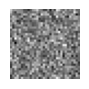

0it [00:00, ?it/s]

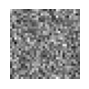

6it [00:00, 17.53it/s]

Timestep 999 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


100it [00:02, 59.44it/s]

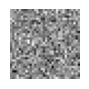

112it [00:02, 55.47it/s]

Timestep 899 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


194it [00:03, 60.66it/s]

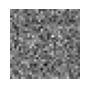

208it [00:03, 59.50it/s]

Timestep 799 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


296it [00:05, 44.07it/s]

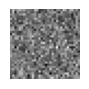

306it [00:05, 43.20it/s]

Timestep 699 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


399it [00:07, 57.62it/s]

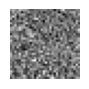

412it [00:08, 58.09it/s]

Timestep 599 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


498it [00:09, 58.62it/s]

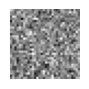

511it [00:09, 57.75it/s]

Timestep 499 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


600it [00:11, 60.43it/s]

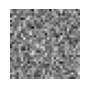

607it [00:11, 55.32it/s]

Timestep 399 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


699it [00:12, 58.58it/s]

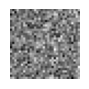

711it [00:13, 55.84it/s]

Timestep 299 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


796it [00:14, 59.49it/s]

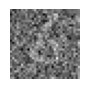

809it [00:14, 58.01it/s]

Timestep 199 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


894it [00:16, 60.96it/s]

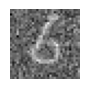

907it [00:16, 57.36it/s]

Timestep 99 add to h space information.
h_space size torch.Size([1, 3, 32, 32])


947it [00:17, 59.73it/s]

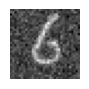

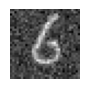

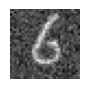

953it [00:17, 44.40it/s]

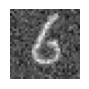

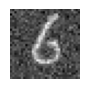

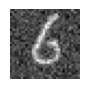

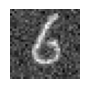

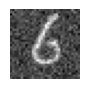

958it [00:17, 33.71it/s]

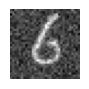

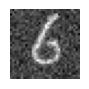

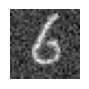

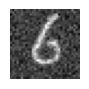

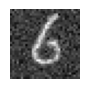

963it [00:17, 29.60it/s]

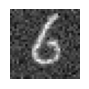

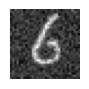

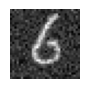

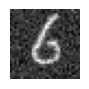

967it [00:18, 27.79it/s]

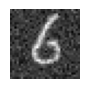

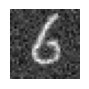

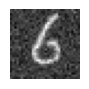

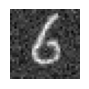

971it [00:18, 26.31it/s]

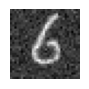

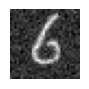

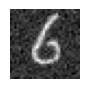

974it [00:18, 24.18it/s]

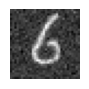

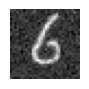

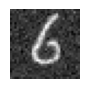

977it [00:18, 23.27it/s]

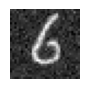

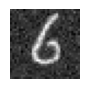

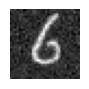

980it [00:18, 21.23it/s]

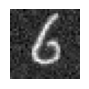

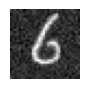

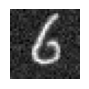

983it [00:18, 20.98it/s]

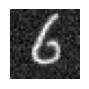

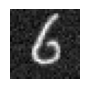

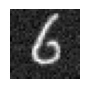

986it [00:19, 21.00it/s]

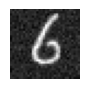

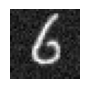

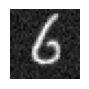

989it [00:19, 21.04it/s]

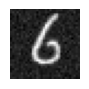

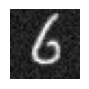

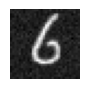

992it [00:19, 21.01it/s]

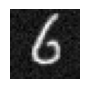

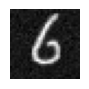

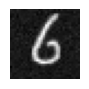

995it [00:19, 21.02it/s]

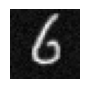

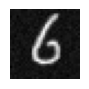

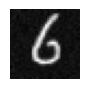

998it [00:19, 21.16it/s]

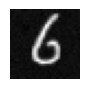

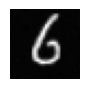

1000it [00:19, 50.76it/s]


In [19]:
# Import necessary modules
# from Train import train, eval
# from Config import set_config
import logging
# from Utils import seed_everything
import torch

# Define the main training function
def main_train(model_config=None):
    modelConfig = {
        "state": "train",  # or eval
        "epoch": 50,
        "batch_size": 4,
        "T": 1000,
        "channel": 128,
        "channel_mult": [1, 2, 3, 4],
        "attn": [2],
        "num_res_blocks": 2,
        "dropout": 0.15,
        "lr": 1e-4,
        "multiplier": 2.0,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 128,
        "grad_clip": 1.0,
        "device": "cuda" if torch.cuda.is_available() else "cpu",  # Auto-detect GPU availability
        "training_load_weight": "ckpt_19_.pt",
        "save_weight_dir": "/content/Checkpoints/",  # Adjusted for Colab
        "test_load_weight": "50epoch.pt",
        "sampled_dir": "/content/SampledImgs/",  # Adjusted for Colab
        "sampledNoisyImgName": "NoisyNoGuidenceImgs.png",
        "sampledImgName": "SampledNoGuidenceImgs.png",
        "nrow": 8
    }

    if model_config is not None:
        modelConfig = model_config

    if modelConfig["state"] == "train":
        train(modelConfig)
    else:
        eval(modelConfig)

# Define the main evaluation function
def main_eval(model_config=None):
    modelConfig = {
        "state": "eval",  # or eval
        "epoch": 10,
        "batch_size": 8,
        "T": 1000,
        "channel": 128,
        "channel_mult": [1, 2, 3, 4],
        "attn": [2],
        "num_res_blocks": 2,
        "dropout": 0.15,
        "lr": 1e-4,
        "multiplier": 2.0,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 32,
        "grad_clip": 1.0,
        "device": "cuda" if torch.cuda.is_available() else "cpu",  # Auto-detect GPU availability
        "training_load_weight": None,
        "save_weight_dir": "/content/Checkpoints/",  # Adjusted for Colab
        # "test_load_weight": "ckpt_67_.pt",
        "test_load_weight": "200epoch.pt",
        "sampled_dir": "/content/SampledImgs/",  # Adjusted for Colab
        "sampledNoisyImgName": "NoisyNoGuidenceImgs3314.png",
        "sampledImgName": "SampledNoGuidenceImgs3314.png",
        "nrow": 8
    }

    if model_config is not None:
        modelConfig = model_config

    if modelConfig["state"] == "train":
        train(modelConfig)
    else:
        eval(modelConfig)

# Set up the configuration and model arguments manually for Colab
args = {
    'seed': 42,
    'state': 'train',  # Change to 'eval' for evaluation
    # 'state': 'eval',
    # 'dataset': 'CIFAR10',  # Select dataset from [Imagenet, CIFAR10, MNIST]
    'dataset': 'MNIST',
    'epochs': 200,
    # 'epochs': 50,
    # 'batch_size': 80,
    'batch_size': 1, # 一次幾張圖片
    'split_class': [0,1,2,3,4,5,6,7,8,9],  # Trained specific class of data 指定數字用這裡，可以塞很多數字
    'load_training_checkpoint': 0,  # Load the number of trained epochs
    "test_load_weight": "200epoch.pt",
}

# Set random seed
# seed_everything(args['seed'])
seed_everything(args['seed']+55)
print(args['dataset'])


# Get the model configuration
model_config = set_config(args, custom_dataset=args['dataset'])

# Log message to confirm configuration
print("Successfully got argument")
analyzer.clean
analyzer.config = model_config
# train(args, model_config)
eval(args, model_config)

In [20]:
len(analyzer.hsapce)

1001

In [21]:
print(train_dataset_golbal)

None


# 自己的


In [22]:
class GaussianDiffusionTrainer_addANoise(nn.Module):
    def __init__(self, beta_1, beta_T, T):
        super().__init__()
        self.T = T
        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))

    def addNoise(self, x_0, t=None):
        """
        Algorithm 1.
        """
        if t is None:
            t = torch.randint(self.T, size=(x_0.shape[0],), device=x_0.device)
        assert (t < self.T).all(), f"timestep out of range: max(t)={t.max()} ≥ T={self.T}"
        noise = torch.randn_like(x_0)
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise
        )
        return x_t


In [23]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# 從 MNIST 資料集中拿出 0~9 各 32 張圖片和對應的標籤
mnist_dataset = MNIST(root='./MNIST_ds', train=True, download=True, transform=ToTensor())
images = {}

for i in range(10):
    count = 0
    images[i] = []
    for image, label in mnist_dataset:
        if label == i:
            images[i].append(image)

            count += 1
            if count == 32:
                break



In [24]:
model_config
trainer = GaussianDiffusionTrainer_addANoise(beta_1=model_config["beta_1"], beta_T=model_config["beta_T"], T=model_config["T"])


In [25]:
# for x_0 in images:
#     x_0 = x_0.unsqueeze(0)  # 增加 batch 維度
#     t = torch.tensor([100], device=x_0.device)  # 設定時間步驟 t = 500
#     x_t = trainer.addNoise(x_0, t=t)  # 添加噪音
#     show_tensor_images_grid(x_t, printImg=True)

In [26]:
model_config

{'dataset': 'MNIST',
 'state': 'train',
 'epoch': 200,
 'batch_size': 1,
 'T': 1000,
 'channel': 128,
 'channel_mult': [1, 2, 3, 4],
 'attn': [2],
 'num_res_blocks': 2,
 'dropout': 0.15,
 'lr': 0.0001,
 'multiplier': 2.0,
 'beta_1': 0.0001,
 'beta_T': 0.02,
 'img_size': 128,
 'grad_clip': 1.0,
 'device': 'cuda:0',
 'training_load_weight': '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]_ckpt_0_.pt',
 'save_weight_dir': './CheckpointsMNIST/',
 'test_load_weight': '200epoch.pt',
 'sampled_dir': './SampledImgsMNIST/',
 'sampledNoisyImgName': 'NoisyNoGuidenceImgs199.png',
 'sampledImgName': 'SampledNoGuidenceImgs199.png',
 'nrow': 8}

In [34]:
def eval_one_step(args, modelConfig: Dict, fromT=1000, endT=0, noisyImage=None):
    # load model and evaluate
    with torch.no_grad():
        # set device
        device = torch.device(modelConfig["device"])

        # Add batch dimension if it's missing
        if noisyImage.dim() == 3:
            noisyImage = noisyImage.unsqueeze(0)

        # Convert grayscale (1 channel) to RGB (3 channels)
        if noisyImage.shape[1] == 1:
            noisyImage = noisyImage.repeat(1, 3, 1, 1)

        # Resize the image to 32x32 to ensure compatibility with the model
        noisyImage = torch.nn.functional.interpolate(noisyImage, size=(32, 32), mode='bilinear')

        noisyImage = noisyImage.to(device)

        # Rest of the function remains the same
        model = UNet(T=modelConfig["T"], ch=modelConfig["channel"],
                    ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                    num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)

        # Load weights
        model_path = os.path.join(modelConfig["save_weight_dir"], modelConfig["test_load_weight"])
        print(model_path)
        ckpt_first = torch.load(model_path, map_location=device)
        model.load_state_dict(ckpt_first)
        model.eval()

        # Create sampler
        sampler = GaussianDiffusionSampler(
            model, modelConfig["beta_1"], modelConfig["beta_T"],
            modelConfig["T"], fromT, endT).to(device)

        # Save noisy image
        saveNoisy = torch.clamp(noisyImage * 0.5 + 0.5, 0, 1)

        if modelConfig["sampled_dir"][2:-1] not in os.listdir(os.getcwd()):
            os.mkdir(modelConfig["sampled_dir"])
        print(f"Absolute path of the noisy image: {os.path.abspath(os.path.join(modelConfig['sampled_dir'], modelConfig['sampledNoisyImgName']))}")
        save_image(saveNoisy, os.path.join(
            modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]),
            nrow=modelConfig["nrow"])

        # Generate image
        sampledImgs = sampler(noisyImage)
        sampledImgs_middle_b = sampledImgs * 0.5 + 0.5  # [0 ~ 1]

        save_image(sampledImgs, os.path.join(
            modelConfig["sampled_dir"], modelConfig["sampledImgName"]),
            nrow=modelConfig["nrow"])

In [35]:
# analyzer.clean()
# eval_step = eval_one_step(args,modelConfig=model_config, fromT=901, endT=900,noisyImage=images[0])

In [36]:
# len(analyzer.hsapce)
print(model_config["device"])
print(torch.cuda.is_available())

cuda:0
True


In [37]:
analyzer.clean()

clean analyze Raw Data


Processing Images for Number 0:   0%|          | 0/32 [00:00<?, ?it/s]

Processing Timesteps for Image 0:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 0, Timestep: 1
clean analyze Raw Data


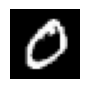

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


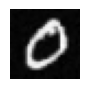




0it [00:00, ?it/s]

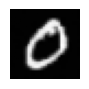

1it [00:00, 24.97it/s]


Processing Timesteps for Image 0:   3%|▎         | 1/34 [00:01<01:02,  1.89s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 1
Processing Number: 0, Image Order: 0, Timestep: 31
clean analyze Raw Data


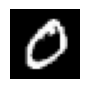

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


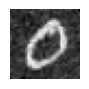




0it [00:00, ?it/s]

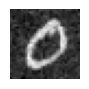

1it [00:00, 23.77it/s]


Processing Timesteps for Image 0:   6%|▌         | 2/34 [00:03<00:58,  1.83s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 31
Processing Number: 0, Image Order: 0, Timestep: 61
clean analyze Raw Data


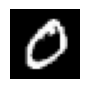

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


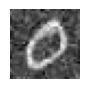




1it [00:00, 38.35it/s]


Processing Timesteps for Image 0:   9%|▉         | 3/34 [00:05<00:54,  1.77s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 61
Processing Number: 0, Image Order: 0, Timestep: 91
clean analyze Raw Data


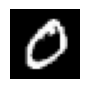

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


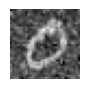




1it [00:00, 36.52it/s]


Processing Timesteps for Image 0:  12%|█▏        | 4/34 [00:07<00:53,  1.77s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 91
Processing Number: 0, Image Order: 0, Timestep: 121
clean analyze Raw Data


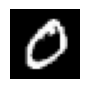

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


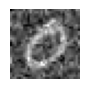




1it [00:00, 38.62it/s]


Processing Timesteps for Image 0:  15%|█▍        | 5/34 [00:08<00:50,  1.76s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 121
Processing Number: 0, Image Order: 0, Timestep: 151
clean analyze Raw Data


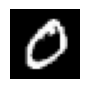

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


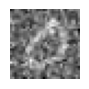




1it [00:00, 36.38it/s]


Processing Timesteps for Image 0:  18%|█▊        | 6/34 [00:11<00:55,  1.97s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 151
Processing Number: 0, Image Order: 0, Timestep: 181
clean analyze Raw Data


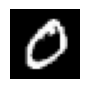

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


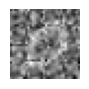




1it [00:00, 34.01it/s]


Processing Timesteps for Image 0:  21%|██        | 7/34 [00:13<00:55,  2.07s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 181
Processing Number: 0, Image Order: 0, Timestep: 211
clean analyze Raw Data


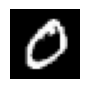

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


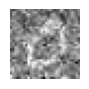




1it [00:00, 37.57it/s]


Processing Timesteps for Image 0:  24%|██▎       | 8/34 [00:15<00:50,  1.96s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 211
Processing Number: 0, Image Order: 0, Timestep: 241
clean analyze Raw Data


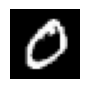

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


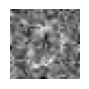




1it [00:00, 38.14it/s]


Processing Timesteps for Image 0:  26%|██▋       | 9/34 [00:16<00:47,  1.88s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 241
Processing Number: 0, Image Order: 0, Timestep: 271
clean analyze Raw Data


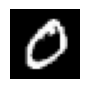

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


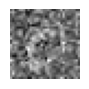




1it [00:00, 33.94it/s]


Processing Timesteps for Image 0:  29%|██▉       | 10/34 [00:18<00:43,  1.83s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 271
Processing Number: 0, Image Order: 0, Timestep: 301
clean analyze Raw Data


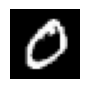

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


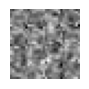




1it [00:00, 34.53it/s]


Processing Timesteps for Image 0:  32%|███▏      | 11/34 [00:20<00:41,  1.82s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 301
Processing Number: 0, Image Order: 0, Timestep: 331
clean analyze Raw Data


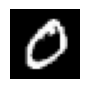

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


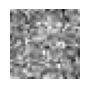




1it [00:00, 35.62it/s]


Processing Timesteps for Image 0:  35%|███▌      | 12/34 [00:22<00:39,  1.79s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 331
Processing Number: 0, Image Order: 0, Timestep: 361
clean analyze Raw Data


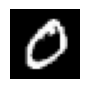

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


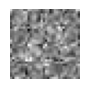




1it [00:00, 28.21it/s]


Processing Timesteps for Image 0:  38%|███▊      | 13/34 [00:24<00:43,  2.09s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 361
Processing Number: 0, Image Order: 0, Timestep: 391
clean analyze Raw Data


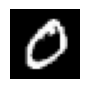

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


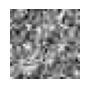




1it [00:00, 38.85it/s]


Processing Timesteps for Image 0:  41%|████      | 14/34 [00:27<00:41,  2.07s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 391
Processing Number: 0, Image Order: 0, Timestep: 421
clean analyze Raw Data


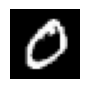

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


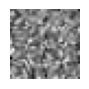




1it [00:00, 37.74it/s]


Processing Timesteps for Image 0:  44%|████▍     | 15/34 [00:28<00:37,  1.96s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 421
Processing Number: 0, Image Order: 0, Timestep: 451
clean analyze Raw Data


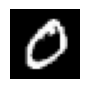

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


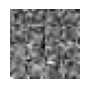




1it [00:00, 36.87it/s]


Processing Timesteps for Image 0:  47%|████▋     | 16/34 [00:30<00:34,  1.89s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 451
Processing Number: 0, Image Order: 0, Timestep: 481
clean analyze Raw Data


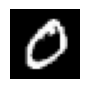

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


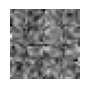




1it [00:00, 38.02it/s]


Processing Timesteps for Image 0:  50%|█████     | 17/34 [00:32<00:31,  1.83s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 481
Processing Number: 0, Image Order: 0, Timestep: 511
clean analyze Raw Data


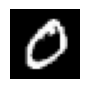

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


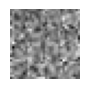




1it [00:00, 35.81it/s]


Processing Timesteps for Image 0:  53%|█████▎    | 18/34 [00:33<00:28,  1.80s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 511
Processing Number: 0, Image Order: 0, Timestep: 541
clean analyze Raw Data


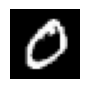

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


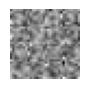




1it [00:00, 34.77it/s]


Processing Timesteps for Image 0:  56%|█████▌    | 19/34 [00:35<00:26,  1.76s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 541
Processing Number: 0, Image Order: 0, Timestep: 571
clean analyze Raw Data


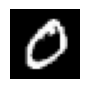

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


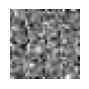




1it [00:00, 37.46it/s]


Processing Timesteps for Image 0:  59%|█████▉    | 20/34 [00:38<00:28,  2.05s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 571
Processing Number: 0, Image Order: 0, Timestep: 601
clean analyze Raw Data


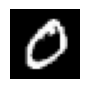

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


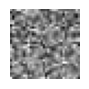




1it [00:00, 36.21it/s]


Processing Timesteps for Image 0:  62%|██████▏   | 21/34 [00:40<00:26,  2.02s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 601
Processing Number: 0, Image Order: 0, Timestep: 631
clean analyze Raw Data


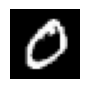

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


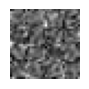




1it [00:00, 38.74it/s]


Processing Timesteps for Image 0:  65%|██████▍   | 22/34 [00:41<00:23,  1.93s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 631
Processing Number: 0, Image Order: 0, Timestep: 661
clean analyze Raw Data


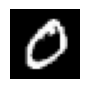

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


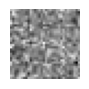




1it [00:00, 35.58it/s]


Processing Timesteps for Image 0:  68%|██████▊   | 23/34 [00:43<00:20,  1.86s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 661
Processing Number: 0, Image Order: 0, Timestep: 691
clean analyze Raw Data


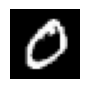

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


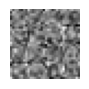




1it [00:00, 37.21it/s]


Processing Timesteps for Image 0:  71%|███████   | 24/34 [00:45<00:18,  1.82s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 691
Processing Number: 0, Image Order: 0, Timestep: 721
clean analyze Raw Data


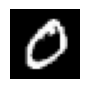

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


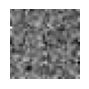




1it [00:00, 28.25it/s]


Processing Timesteps for Image 0:  74%|███████▎  | 25/34 [00:47<00:17,  1.96s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 721
Processing Number: 0, Image Order: 0, Timestep: 751
clean analyze Raw Data


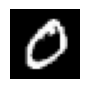

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


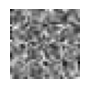




1it [00:00, 24.71it/s]


Processing Timesteps for Image 0:  76%|███████▋  | 26/34 [00:50<00:18,  2.26s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 751
Processing Number: 0, Image Order: 0, Timestep: 781
clean analyze Raw Data


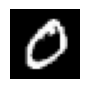

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


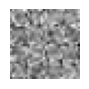




1it [00:00, 37.36it/s]


Processing Timesteps for Image 0:  79%|███████▉  | 27/34 [00:53<00:16,  2.34s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 781
Processing Number: 0, Image Order: 0, Timestep: 811
clean analyze Raw Data


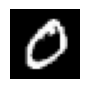

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


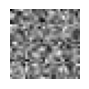




1it [00:00, 39.14it/s]


Processing Timesteps for Image 0:  82%|████████▏ | 28/34 [00:54<00:12,  2.16s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 811
Processing Number: 0, Image Order: 0, Timestep: 841
clean analyze Raw Data


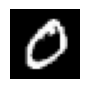

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


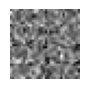




1it [00:00, 38.99it/s]


Processing Timesteps for Image 0:  85%|████████▌ | 29/34 [00:56<00:10,  2.03s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 841
Processing Number: 0, Image Order: 0, Timestep: 871
clean analyze Raw Data


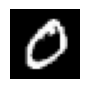

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


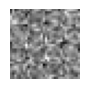




1it [00:00, 35.63it/s]


Processing Timesteps for Image 0:  88%|████████▊ | 30/34 [00:58<00:07,  1.97s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 871
Processing Number: 0, Image Order: 0, Timestep: 901
clean analyze Raw Data


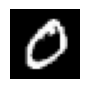

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


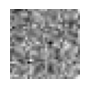




1it [00:00, 34.59it/s]


Processing Timesteps for Image 0:  91%|█████████ | 31/34 [01:00<00:05,  1.90s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 901
Processing Number: 0, Image Order: 0, Timestep: 931
clean analyze Raw Data


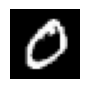

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


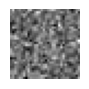




1it [00:00, 36.11it/s]


Processing Timesteps for Image 0:  94%|█████████▍| 32/34 [01:01<00:03,  1.84s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 931
Processing Number: 0, Image Order: 0, Timestep: 961
clean analyze Raw Data


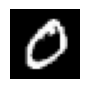

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


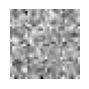




1it [00:00, 37.47it/s]


Processing Timesteps for Image 0:  97%|█████████▋| 33/34 [01:04<00:01,  2.00s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 961
Processing Number: 0, Image Order: 0, Timestep: 991
clean analyze Raw Data


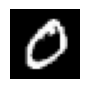

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


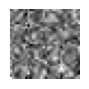




1it [00:00, 37.65it/s]


Processing Timesteps for Image 0: 100%|██████████| 34/34 [01:06<00:00,  2.09s/it]

                                                                                 
Processing Images for Number 0:   3%|▎         | 1/32 [01:06<34:23, 66.55s/it]

Saved data for Number: 0, Image Order: 0, Timestep: 991




Processing Timesteps for Image 1:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 1, Timestep: 1
clean analyze Raw Data


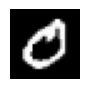

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


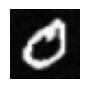




0it [00:00, ?it/s]

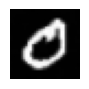

1it [00:00, 21.20it/s]


Processing Timesteps for Image 1:   3%|▎         | 1/34 [00:01<00:59,  1.81s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 1
Processing Number: 0, Image Order: 1, Timestep: 31
clean analyze Raw Data


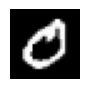

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


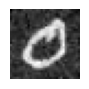




0it [00:00, ?it/s]

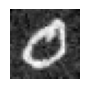

1it [00:00, 19.86it/s]


Processing Timesteps for Image 1:   6%|▌         | 2/34 [00:03<00:56,  1.77s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 31
Processing Number: 0, Image Order: 1, Timestep: 61
clean analyze Raw Data


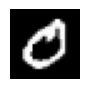

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


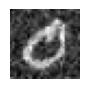




1it [00:00, 38.33it/s]


Processing Timesteps for Image 1:   9%|▉         | 3/34 [00:05<00:54,  1.75s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 61
Processing Number: 0, Image Order: 1, Timestep: 91
clean analyze Raw Data


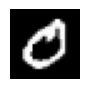

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


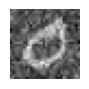




1it [00:00, 39.20it/s]


Processing Timesteps for Image 1:  12%|█▏        | 4/34 [00:07<00:52,  1.74s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 91
Processing Number: 0, Image Order: 1, Timestep: 121
clean analyze Raw Data


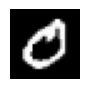

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


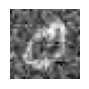




1it [00:00, 38.09it/s]


Processing Timesteps for Image 1:  15%|█▍        | 5/34 [00:08<00:50,  1.73s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 121
Processing Number: 0, Image Order: 1, Timestep: 151
clean analyze Raw Data


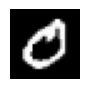

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


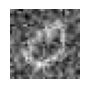




1it [00:00, 38.20it/s]


Processing Timesteps for Image 1:  18%|█▊        | 6/34 [00:11<00:56,  2.02s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 151
Processing Number: 0, Image Order: 1, Timestep: 181
clean analyze Raw Data


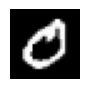

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


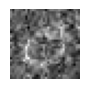




1it [00:00, 38.56it/s]


Processing Timesteps for Image 1:  21%|██        | 7/34 [00:13<00:55,  2.04s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 181
Processing Number: 0, Image Order: 1, Timestep: 211
clean analyze Raw Data


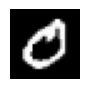

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


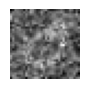




1it [00:00, 38.13it/s]


Processing Timesteps for Image 1:  24%|██▎       | 8/34 [00:15<00:50,  1.94s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 211
Processing Number: 0, Image Order: 1, Timestep: 241
clean analyze Raw Data


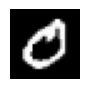

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


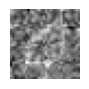




1it [00:00, 35.61it/s]


Processing Timesteps for Image 1:  26%|██▋       | 9/34 [00:16<00:46,  1.87s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 241
Processing Number: 0, Image Order: 1, Timestep: 271
clean analyze Raw Data


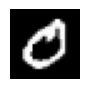

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


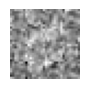




1it [00:00, 37.93it/s]


Processing Timesteps for Image 1:  29%|██▉       | 10/34 [00:18<00:44,  1.84s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 271
Processing Number: 0, Image Order: 1, Timestep: 301
clean analyze Raw Data


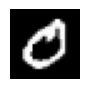

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


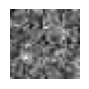




1it [00:00, 37.19it/s]


Processing Timesteps for Image 1:  32%|███▏      | 11/34 [00:20<00:42,  1.84s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 301
Processing Number: 0, Image Order: 1, Timestep: 331
clean analyze Raw Data


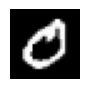

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


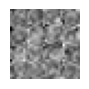




1it [00:00, 34.92it/s]


Processing Timesteps for Image 1:  35%|███▌      | 12/34 [00:22<00:39,  1.81s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 331
Processing Number: 0, Image Order: 1, Timestep: 361
clean analyze Raw Data


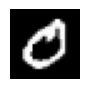

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


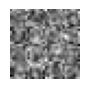




1it [00:00, 31.53it/s]


Processing Timesteps for Image 1:  38%|███▊      | 13/34 [00:25<00:44,  2.13s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 361
Processing Number: 0, Image Order: 1, Timestep: 391
clean analyze Raw Data


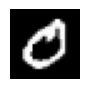

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


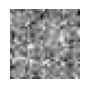




1it [00:00, 38.66it/s]


Processing Timesteps for Image 1:  41%|████      | 14/34 [00:26<00:41,  2.06s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 391
Processing Number: 0, Image Order: 1, Timestep: 421
clean analyze Raw Data


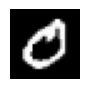

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


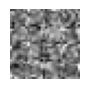




1it [00:00, 37.05it/s]


Processing Timesteps for Image 1:  44%|████▍     | 15/34 [00:28<00:37,  1.97s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 421
Processing Number: 0, Image Order: 1, Timestep: 451
clean analyze Raw Data


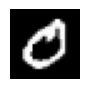

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


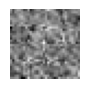




1it [00:00, 38.32it/s]


Processing Timesteps for Image 1:  47%|████▋     | 16/34 [00:30<00:34,  1.89s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 451
Processing Number: 0, Image Order: 1, Timestep: 481
clean analyze Raw Data


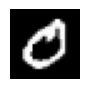

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


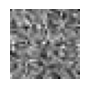




1it [00:00, 37.92it/s]


Processing Timesteps for Image 1:  50%|█████     | 17/34 [00:32<00:31,  1.85s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 481
Processing Number: 0, Image Order: 1, Timestep: 511
clean analyze Raw Data


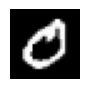

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


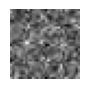




1it [00:00, 38.78it/s]


Processing Timesteps for Image 1:  53%|█████▎    | 18/34 [00:33<00:29,  1.82s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 511
Processing Number: 0, Image Order: 1, Timestep: 541
clean analyze Raw Data


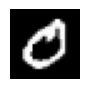

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


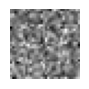




1it [00:00, 36.27it/s]


Processing Timesteps for Image 1:  56%|█████▌    | 19/34 [00:35<00:27,  1.81s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 541
Processing Number: 0, Image Order: 1, Timestep: 571
clean analyze Raw Data


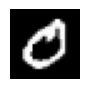

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


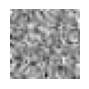




1it [00:00, 28.10it/s]


Processing Timesteps for Image 1:  59%|█████▉    | 20/34 [00:38<00:29,  2.13s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 571
Processing Number: 0, Image Order: 1, Timestep: 601
clean analyze Raw Data


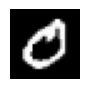

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


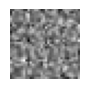




1it [00:00, 37.35it/s]


Processing Timesteps for Image 1:  62%|██████▏   | 21/34 [00:40<00:26,  2.05s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 601
Processing Number: 0, Image Order: 1, Timestep: 631
clean analyze Raw Data


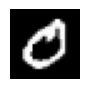

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


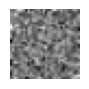




1it [00:00, 38.08it/s]


Processing Timesteps for Image 1:  65%|██████▍   | 22/34 [00:42<00:23,  1.96s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 631
Processing Number: 0, Image Order: 1, Timestep: 661
clean analyze Raw Data


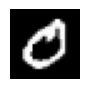

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


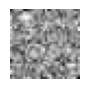




1it [00:00, 37.87it/s]


Processing Timesteps for Image 1:  68%|██████▊   | 23/34 [00:43<00:20,  1.90s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 661
Processing Number: 0, Image Order: 1, Timestep: 691
clean analyze Raw Data


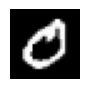

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


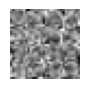




1it [00:00, 38.52it/s]


Processing Timesteps for Image 1:  71%|███████   | 24/34 [00:45<00:18,  1.86s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 691
Processing Number: 0, Image Order: 1, Timestep: 721
clean analyze Raw Data


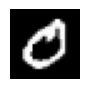

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


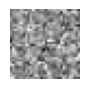




1it [00:00, 34.45it/s]


Processing Timesteps for Image 1:  74%|███████▎  | 25/34 [00:47<00:16,  1.83s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 721
Processing Number: 0, Image Order: 1, Timestep: 751
clean analyze Raw Data


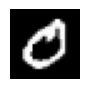

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


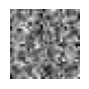




1it [00:00, 37.01it/s]


Processing Timesteps for Image 1:  76%|███████▋  | 26/34 [00:49<00:14,  1.83s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 751
Processing Number: 0, Image Order: 1, Timestep: 781
clean analyze Raw Data


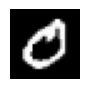

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


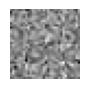




1it [00:00, 38.60it/s]


Processing Timesteps for Image 1:  79%|███████▉  | 27/34 [00:52<00:15,  2.18s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 781
Processing Number: 0, Image Order: 1, Timestep: 811
clean analyze Raw Data


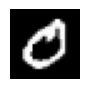

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


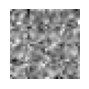




1it [00:00, 39.32it/s]


Processing Timesteps for Image 1:  82%|████████▏ | 28/34 [00:54<00:12,  2.07s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 811
Processing Number: 0, Image Order: 1, Timestep: 841
clean analyze Raw Data


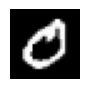

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


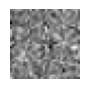




1it [00:00, 37.79it/s]


Processing Timesteps for Image 1:  85%|████████▌ | 29/34 [00:55<00:09,  1.98s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 841
Processing Number: 0, Image Order: 1, Timestep: 871
clean analyze Raw Data


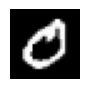

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


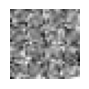




1it [00:00, 39.03it/s]


Processing Timesteps for Image 1:  88%|████████▊ | 30/34 [00:57<00:07,  1.91s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 871
Processing Number: 0, Image Order: 1, Timestep: 901
clean analyze Raw Data


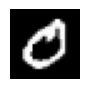

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


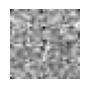




1it [00:00, 36.85it/s]


Processing Timesteps for Image 1:  91%|█████████ | 31/34 [00:59<00:05,  1.87s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 901
Processing Number: 0, Image Order: 1, Timestep: 931
clean analyze Raw Data


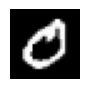

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


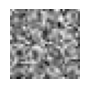




1it [00:00, 37.54it/s]


Processing Timesteps for Image 1:  94%|█████████▍| 32/34 [01:01<00:03,  1.84s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 931
Processing Number: 0, Image Order: 1, Timestep: 961
clean analyze Raw Data


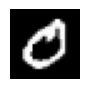

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


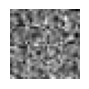




1it [00:00, 34.61it/s]


Processing Timesteps for Image 1:  97%|█████████▋| 33/34 [01:03<00:01,  1.87s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 961
Processing Number: 0, Image Order: 1, Timestep: 991
clean analyze Raw Data


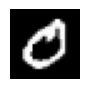

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


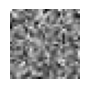




1it [00:00, 34.87it/s]


Processing Timesteps for Image 1: 100%|██████████| 34/34 [01:05<00:00,  2.14s/it]

                                                                                 
Processing Images for Number 0:   6%|▋         | 2/32 [02:12<33:04, 66.15s/it]

Saved data for Number: 0, Image Order: 1, Timestep: 991




Processing Timesteps for Image 2:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 2, Timestep: 1
clean analyze Raw Data


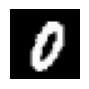

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


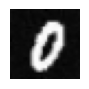




0it [00:00, ?it/s]

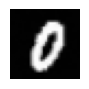

1it [00:00, 20.90it/s]


Processing Timesteps for Image 2:   3%|▎         | 1/34 [00:01<01:01,  1.87s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 1
Processing Number: 0, Image Order: 2, Timestep: 31
clean analyze Raw Data


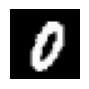

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


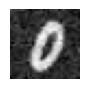




0it [00:00, ?it/s]

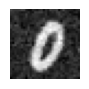

1it [00:00, 20.51it/s]


Processing Timesteps for Image 2:   6%|▌         | 2/34 [00:03<00:58,  1.83s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 31
Processing Number: 0, Image Order: 2, Timestep: 61
clean analyze Raw Data


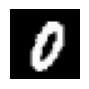

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


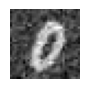




1it [00:00, 37.57it/s]


Processing Timesteps for Image 2:   9%|▉         | 3/34 [00:05<00:56,  1.81s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 61
Processing Number: 0, Image Order: 2, Timestep: 91
clean analyze Raw Data


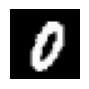

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


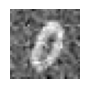




1it [00:00, 34.99it/s]


Processing Timesteps for Image 2:  12%|█▏        | 4/34 [00:07<00:53,  1.79s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 91
Processing Number: 0, Image Order: 2, Timestep: 121
clean analyze Raw Data


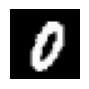

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


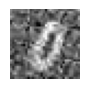




1it [00:00, 37.68it/s]


Processing Timesteps for Image 2:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 121
Processing Number: 0, Image Order: 2, Timestep: 151
clean analyze Raw Data


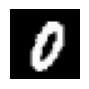

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


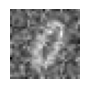




1it [00:00, 37.30it/s]


Processing Timesteps for Image 2:  18%|█▊        | 6/34 [00:11<00:55,  1.99s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 151
Processing Number: 0, Image Order: 2, Timestep: 181
clean analyze Raw Data


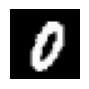

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


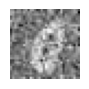




1it [00:00, 38.74it/s]


Processing Timesteps for Image 2:  21%|██        | 7/34 [00:13<00:58,  2.15s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 181
Processing Number: 0, Image Order: 2, Timestep: 211
clean analyze Raw Data


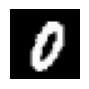

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


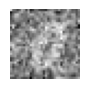




1it [00:00, 37.73it/s]


Processing Timesteps for Image 2:  24%|██▎       | 8/34 [00:15<00:54,  2.08s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 211
Processing Number: 0, Image Order: 2, Timestep: 241
clean analyze Raw Data


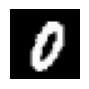

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


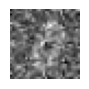




1it [00:00, 38.93it/s]


Processing Timesteps for Image 2:  26%|██▋       | 9/34 [00:17<00:49,  1.99s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 241
Processing Number: 0, Image Order: 2, Timestep: 271
clean analyze Raw Data


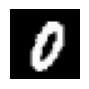

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


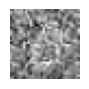




1it [00:00, 38.04it/s]


Processing Timesteps for Image 2:  29%|██▉       | 10/34 [00:19<00:46,  1.92s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 271
Processing Number: 0, Image Order: 2, Timestep: 301
clean analyze Raw Data


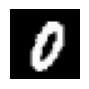

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


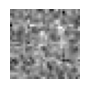




1it [00:00, 36.98it/s]


Processing Timesteps for Image 2:  32%|███▏      | 11/34 [00:21<00:43,  1.88s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 301
Processing Number: 0, Image Order: 2, Timestep: 331
clean analyze Raw Data


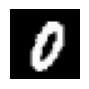

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


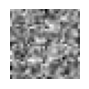




1it [00:00, 36.94it/s]


Processing Timesteps for Image 2:  35%|███▌      | 12/34 [00:22<00:40,  1.85s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 331
Processing Number: 0, Image Order: 2, Timestep: 361
clean analyze Raw Data


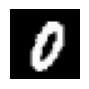

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


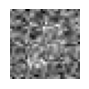




1it [00:00, 24.05it/s]


Processing Timesteps for Image 2:  38%|███▊      | 13/34 [00:25<00:45,  2.16s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 361
Processing Number: 0, Image Order: 2, Timestep: 391
clean analyze Raw Data


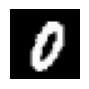

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


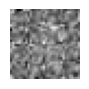




1it [00:00, 36.65it/s]


Processing Timesteps for Image 2:  41%|████      | 14/34 [00:27<00:42,  2.10s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 391
Processing Number: 0, Image Order: 2, Timestep: 421
clean analyze Raw Data


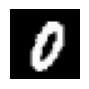

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


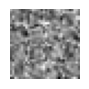




1it [00:00, 38.31it/s]


Processing Timesteps for Image 2:  44%|████▍     | 15/34 [00:29<00:38,  2.01s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 421
Processing Number: 0, Image Order: 2, Timestep: 451
clean analyze Raw Data


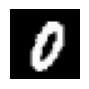

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


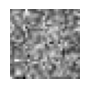




1it [00:00, 39.15it/s]


Processing Timesteps for Image 2:  47%|████▋     | 16/34 [00:31<00:35,  1.95s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 451
Processing Number: 0, Image Order: 2, Timestep: 481
clean analyze Raw Data


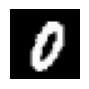

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


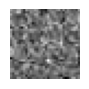




1it [00:00, 38.94it/s]


Processing Timesteps for Image 2:  50%|█████     | 17/34 [00:33<00:32,  1.90s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 481
Processing Number: 0, Image Order: 2, Timestep: 511
clean analyze Raw Data


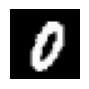

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


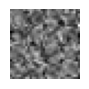




1it [00:00, 37.14it/s]


Processing Timesteps for Image 2:  53%|█████▎    | 18/34 [00:34<00:29,  1.87s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 511
Processing Number: 0, Image Order: 2, Timestep: 541
clean analyze Raw Data


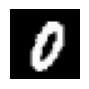

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


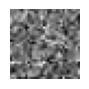




1it [00:00, 31.20it/s]


Processing Timesteps for Image 2:  56%|█████▌    | 19/34 [00:36<00:27,  1.86s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 541
Processing Number: 0, Image Order: 2, Timestep: 571
clean analyze Raw Data


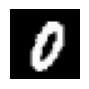

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


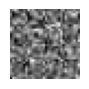




1it [00:00, 21.02it/s]


Processing Timesteps for Image 2:  59%|█████▉    | 20/34 [00:39<00:30,  2.17s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 571
Processing Number: 0, Image Order: 2, Timestep: 601
clean analyze Raw Data


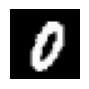

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


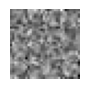




1it [00:00, 39.22it/s]


Processing Timesteps for Image 2:  62%|██████▏   | 21/34 [00:41<00:26,  2.07s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 601
Processing Number: 0, Image Order: 2, Timestep: 631
clean analyze Raw Data


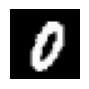

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


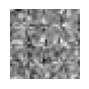




1it [00:00, 38.44it/s]


Processing Timesteps for Image 2:  65%|██████▍   | 22/34 [00:43<00:23,  1.99s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 631
Processing Number: 0, Image Order: 2, Timestep: 661
clean analyze Raw Data


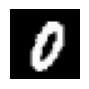

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


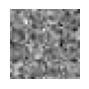




1it [00:00, 38.13it/s]


Processing Timesteps for Image 2:  68%|██████▊   | 23/34 [00:45<00:21,  1.93s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 661
Processing Number: 0, Image Order: 2, Timestep: 691
clean analyze Raw Data


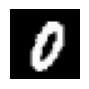

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


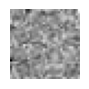




1it [00:00, 38.37it/s]


Processing Timesteps for Image 2:  71%|███████   | 24/34 [00:46<00:18,  1.89s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 691
Processing Number: 0, Image Order: 2, Timestep: 721
clean analyze Raw Data


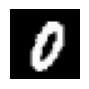

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


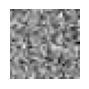




1it [00:00, 38.32it/s]


Processing Timesteps for Image 2:  74%|███████▎  | 25/34 [00:48<00:16,  1.89s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 721
Processing Number: 0, Image Order: 2, Timestep: 751
clean analyze Raw Data


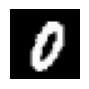

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


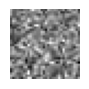




1it [00:00, 39.16it/s]


Processing Timesteps for Image 2:  76%|███████▋  | 26/34 [00:50<00:15,  1.98s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 751
Processing Number: 0, Image Order: 2, Timestep: 781
clean analyze Raw Data


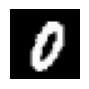

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


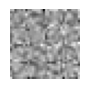




1it [00:00, 34.97it/s]


Processing Timesteps for Image 2:  79%|███████▉  | 27/34 [00:53<00:15,  2.18s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 781
Processing Number: 0, Image Order: 2, Timestep: 811
clean analyze Raw Data


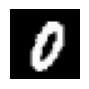

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


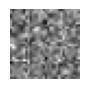




1it [00:00, 38.29it/s]


Processing Timesteps for Image 2:  82%|████████▏ | 28/34 [00:55<00:12,  2.07s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 811
Processing Number: 0, Image Order: 2, Timestep: 841
clean analyze Raw Data


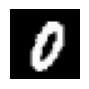

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


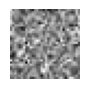




1it [00:00, 38.16it/s]


Processing Timesteps for Image 2:  85%|████████▌ | 29/34 [00:57<00:09,  2.00s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 841
Processing Number: 0, Image Order: 2, Timestep: 871
clean analyze Raw Data


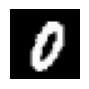

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


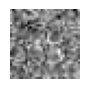




1it [00:00, 37.46it/s]


Processing Timesteps for Image 2:  88%|████████▊ | 30/34 [00:59<00:07,  1.94s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 871
Processing Number: 0, Image Order: 2, Timestep: 901
clean analyze Raw Data


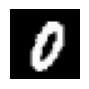

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


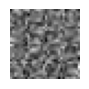




1it [00:00, 39.09it/s]


Processing Timesteps for Image 2:  91%|█████████ | 31/34 [01:00<00:05,  1.89s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 901
Processing Number: 0, Image Order: 2, Timestep: 931
clean analyze Raw Data


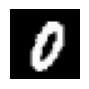

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


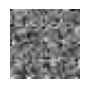




1it [00:00, 38.30it/s]


Processing Timesteps for Image 2:  94%|█████████▍| 32/34 [01:02<00:03,  1.87s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 931
Processing Number: 0, Image Order: 2, Timestep: 961
clean analyze Raw Data


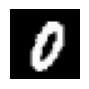

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


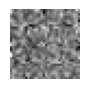




1it [00:00, 36.92it/s]


Processing Timesteps for Image 2:  97%|█████████▋| 33/34 [01:05<00:02,  2.12s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 961
Processing Number: 0, Image Order: 2, Timestep: 991
clean analyze Raw Data


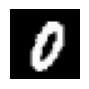

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


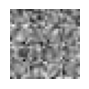




1it [00:00, 38.40it/s]


Processing Timesteps for Image 2: 100%|██████████| 34/34 [01:07<00:00,  2.12s/it]

                                                                                 
Processing Images for Number 0:   9%|▉         | 3/32 [03:19<32:16, 66.78s/it]

Saved data for Number: 0, Image Order: 2, Timestep: 991




Processing Timesteps for Image 3:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 3, Timestep: 1
clean analyze Raw Data


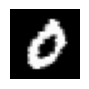

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


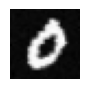




0it [00:00, ?it/s]

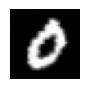

1it [00:00, 20.64it/s]


Processing Timesteps for Image 3:   3%|▎         | 1/34 [00:01<01:04,  1.95s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 1
Processing Number: 0, Image Order: 3, Timestep: 31
clean analyze Raw Data


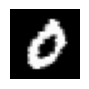

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


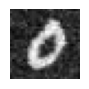




0it [00:00, ?it/s]

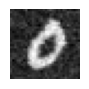

1it [00:00, 20.00it/s]


Processing Timesteps for Image 3:   6%|▌         | 2/34 [00:03<01:00,  1.88s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 31
Processing Number: 0, Image Order: 3, Timestep: 61
clean analyze Raw Data


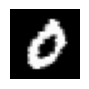

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


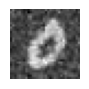




1it [00:00, 36.57it/s]


Processing Timesteps for Image 3:   9%|▉         | 3/34 [00:05<00:57,  1.86s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 61
Processing Number: 0, Image Order: 3, Timestep: 91
clean analyze Raw Data


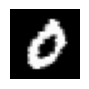

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


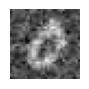




1it [00:00, 36.48it/s]


Processing Timesteps for Image 3:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 91
Processing Number: 0, Image Order: 3, Timestep: 121
clean analyze Raw Data


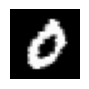

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


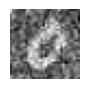




1it [00:00, 37.35it/s]


Processing Timesteps for Image 3:  15%|█▍        | 5/34 [00:09<00:53,  1.86s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 121
Processing Number: 0, Image Order: 3, Timestep: 151
clean analyze Raw Data


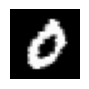

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


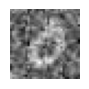




1it [00:00, 32.36it/s]


Processing Timesteps for Image 3:  18%|█▊        | 6/34 [00:12<01:05,  2.34s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 151
Processing Number: 0, Image Order: 3, Timestep: 181
clean analyze Raw Data


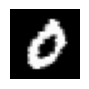

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


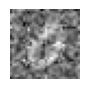




1it [00:00, 34.90it/s]


Processing Timesteps for Image 3:  21%|██        | 7/34 [00:15<01:08,  2.54s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 181
Processing Number: 0, Image Order: 3, Timestep: 211
clean analyze Raw Data


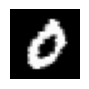

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


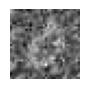




1it [00:00, 38.62it/s]


Processing Timesteps for Image 3:  24%|██▎       | 8/34 [00:17<01:00,  2.31s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 211
Processing Number: 0, Image Order: 3, Timestep: 241
clean analyze Raw Data


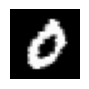

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


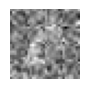




1it [00:00, 37.81it/s]


Processing Timesteps for Image 3:  26%|██▋       | 9/34 [00:19<00:53,  2.16s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 241
Processing Number: 0, Image Order: 3, Timestep: 271
clean analyze Raw Data


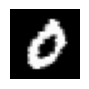

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


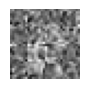




1it [00:00, 38.29it/s]


Processing Timesteps for Image 3:  29%|██▉       | 10/34 [00:20<00:49,  2.05s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 271
Processing Number: 0, Image Order: 3, Timestep: 301
clean analyze Raw Data


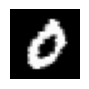

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


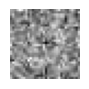




1it [00:00, 40.86it/s]


Processing Timesteps for Image 3:  32%|███▏      | 11/34 [00:22<00:45,  1.98s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 301
Processing Number: 0, Image Order: 3, Timestep: 331
clean analyze Raw Data


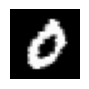

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


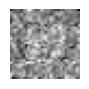




1it [00:00, 25.31it/s]


Processing Timesteps for Image 3:  35%|███▌      | 12/34 [00:24<00:42,  1.94s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 331
Processing Number: 0, Image Order: 3, Timestep: 361
clean analyze Raw Data


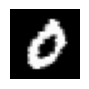

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


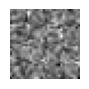




1it [00:00, 30.20it/s]


Processing Timesteps for Image 3:  38%|███▊      | 13/34 [00:27<00:46,  2.22s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 361
Processing Number: 0, Image Order: 3, Timestep: 391
clean analyze Raw Data


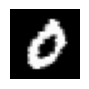

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


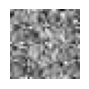




1it [00:00, 36.87it/s]


Processing Timesteps for Image 3:  41%|████      | 14/34 [00:29<00:43,  2.15s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 391
Processing Number: 0, Image Order: 3, Timestep: 421
clean analyze Raw Data


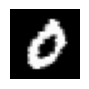

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


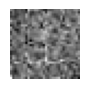




1it [00:00, 33.82it/s]


Processing Timesteps for Image 3:  44%|████▍     | 15/34 [00:31<00:38,  2.05s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 421
Processing Number: 0, Image Order: 3, Timestep: 451
clean analyze Raw Data


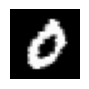

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


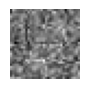




1it [00:00, 37.90it/s]


Processing Timesteps for Image 3:  47%|████▋     | 16/34 [00:33<00:35,  1.98s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 451
Processing Number: 0, Image Order: 3, Timestep: 481
clean analyze Raw Data


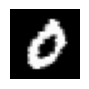

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


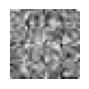




1it [00:00, 36.67it/s]


Processing Timesteps for Image 3:  50%|█████     | 17/34 [00:34<00:32,  1.93s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 481
Processing Number: 0, Image Order: 3, Timestep: 511
clean analyze Raw Data


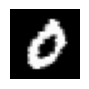

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


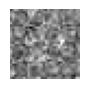




1it [00:00, 37.76it/s]


Processing Timesteps for Image 3:  53%|█████▎    | 18/34 [00:36<00:30,  1.91s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 511
Processing Number: 0, Image Order: 3, Timestep: 541
clean analyze Raw Data


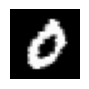

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


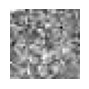




1it [00:00, 30.62it/s]


Processing Timesteps for Image 3:  56%|█████▌    | 19/34 [00:38<00:28,  1.92s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 541
Processing Number: 0, Image Order: 3, Timestep: 571
clean analyze Raw Data


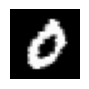

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


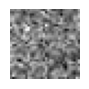




1it [00:00, 36.19it/s]


Processing Timesteps for Image 3:  59%|█████▉    | 20/34 [00:41<00:30,  2.20s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 571
Processing Number: 0, Image Order: 3, Timestep: 601
clean analyze Raw Data


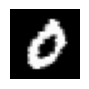

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


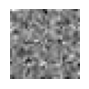




1it [00:00, 37.05it/s]


Processing Timesteps for Image 3:  62%|██████▏   | 21/34 [00:43<00:27,  2.08s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 601
Processing Number: 0, Image Order: 3, Timestep: 631
clean analyze Raw Data


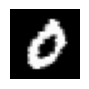

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


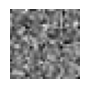




1it [00:00, 37.65it/s]


Processing Timesteps for Image 3:  65%|██████▍   | 22/34 [00:45<00:24,  2.03s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 631
Processing Number: 0, Image Order: 3, Timestep: 661
clean analyze Raw Data


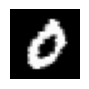

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


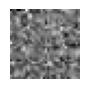




1it [00:00, 36.26it/s]


Processing Timesteps for Image 3:  68%|██████▊   | 23/34 [00:47<00:21,  1.97s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 661
Processing Number: 0, Image Order: 3, Timestep: 691
clean analyze Raw Data


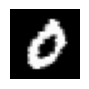

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


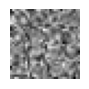




1it [00:00, 37.14it/s]


Processing Timesteps for Image 3:  71%|███████   | 24/34 [00:48<00:19,  1.92s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 691
Processing Number: 0, Image Order: 3, Timestep: 721
clean analyze Raw Data


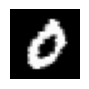

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


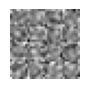




1it [00:00, 36.89it/s]


Processing Timesteps for Image 3:  74%|███████▎  | 25/34 [00:50<00:17,  1.90s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 721
Processing Number: 0, Image Order: 3, Timestep: 751
clean analyze Raw Data


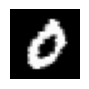

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


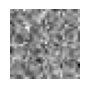




1it [00:00, 35.87it/s]


Processing Timesteps for Image 3:  76%|███████▋  | 26/34 [00:53<00:16,  2.05s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 751
Processing Number: 0, Image Order: 3, Timestep: 781
clean analyze Raw Data


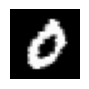

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


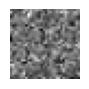




1it [00:00, 36.27it/s]


Processing Timesteps for Image 3:  79%|███████▉  | 27/34 [00:55<00:15,  2.19s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 781
Processing Number: 0, Image Order: 3, Timestep: 811
clean analyze Raw Data


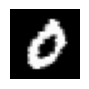

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


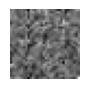




1it [00:00, 38.02it/s]


Processing Timesteps for Image 3:  82%|████████▏ | 28/34 [00:57<00:12,  2.08s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 811
Processing Number: 0, Image Order: 3, Timestep: 841
clean analyze Raw Data


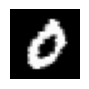

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


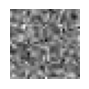




1it [00:00, 37.24it/s]


Processing Timesteps for Image 3:  85%|████████▌ | 29/34 [00:59<00:10,  2.01s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 841
Processing Number: 0, Image Order: 3, Timestep: 871
clean analyze Raw Data


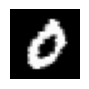

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


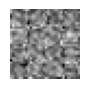




1it [00:00, 35.99it/s]


Processing Timesteps for Image 3:  88%|████████▊ | 30/34 [01:01<00:07,  1.97s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 871
Processing Number: 0, Image Order: 3, Timestep: 901
clean analyze Raw Data


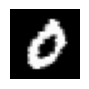

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


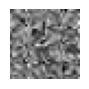




1it [00:00, 37.48it/s]


Processing Timesteps for Image 3:  91%|█████████ | 31/34 [01:03<00:05,  1.93s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 901
Processing Number: 0, Image Order: 3, Timestep: 931
clean analyze Raw Data


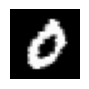

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


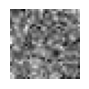




1it [00:00, 35.70it/s]


Processing Timesteps for Image 3:  94%|█████████▍| 32/34 [01:05<00:03,  1.91s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 931
Processing Number: 0, Image Order: 3, Timestep: 961
clean analyze Raw Data


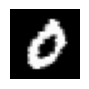

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


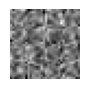




1it [00:00, 25.21it/s]


Processing Timesteps for Image 3:  97%|█████████▋| 33/34 [01:07<00:02,  2.19s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 961
Processing Number: 0, Image Order: 3, Timestep: 991
clean analyze Raw Data


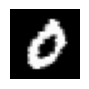

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


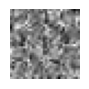




1it [00:00, 37.30it/s]


Processing Timesteps for Image 3: 100%|██████████| 34/34 [01:09<00:00,  2.17s/it]

                                                                                 
Processing Images for Number 0:  12%|█▎        | 4/32 [04:29<31:45, 68.04s/it]

Saved data for Number: 0, Image Order: 3, Timestep: 991




Processing Timesteps for Image 4:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 4, Timestep: 1
clean analyze Raw Data


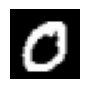

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


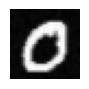




0it [00:00, ?it/s]

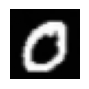

1it [00:00, 20.68it/s]


Processing Timesteps for Image 4:   3%|▎         | 1/34 [00:02<01:06,  2.01s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 1
Processing Number: 0, Image Order: 4, Timestep: 31
clean analyze Raw Data


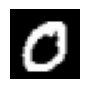

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


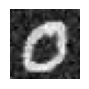




0it [00:00, ?it/s]

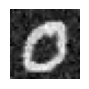




1it [00:00,  4.86it/s]


Processing Timesteps for Image 4:   6%|▌         | 2/34 [00:04<01:04,  2.02s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 31
Processing Number: 0, Image Order: 4, Timestep: 61
clean analyze Raw Data


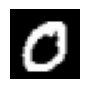

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


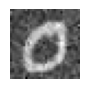




1it [00:00, 39.21it/s]


Processing Timesteps for Image 4:   9%|▉         | 3/34 [00:05<00:59,  1.93s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 61
Processing Number: 0, Image Order: 4, Timestep: 91
clean analyze Raw Data


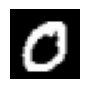

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


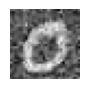




1it [00:00, 36.45it/s]


Processing Timesteps for Image 4:  12%|█▏        | 4/34 [00:07<00:56,  1.90s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 91
Processing Number: 0, Image Order: 4, Timestep: 121
clean analyze Raw Data


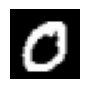

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


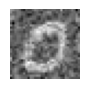




1it [00:00, 36.05it/s]


Processing Timesteps for Image 4:  15%|█▍        | 5/34 [00:09<00:58,  2.03s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 121
Processing Number: 0, Image Order: 4, Timestep: 151
clean analyze Raw Data


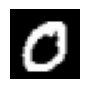

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


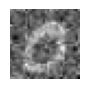




1it [00:00, 39.37it/s]


Processing Timesteps for Image 4:  18%|█▊        | 6/34 [00:12<01:03,  2.27s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 151
Processing Number: 0, Image Order: 4, Timestep: 181
clean analyze Raw Data


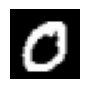

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


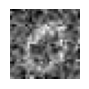




1it [00:00, 36.99it/s]


Processing Timesteps for Image 4:  21%|██        | 7/34 [00:14<00:57,  2.13s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 181
Processing Number: 0, Image Order: 4, Timestep: 211
clean analyze Raw Data


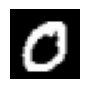

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


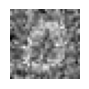




1it [00:00, 36.47it/s]


Processing Timesteps for Image 4:  24%|██▎       | 8/34 [00:16<00:53,  2.04s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 211
Processing Number: 0, Image Order: 4, Timestep: 241
clean analyze Raw Data


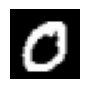

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


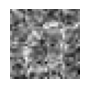




1it [00:00, 38.05it/s]


Processing Timesteps for Image 4:  26%|██▋       | 9/34 [00:18<00:49,  1.98s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 241
Processing Number: 0, Image Order: 4, Timestep: 271
clean analyze Raw Data


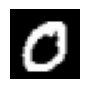

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


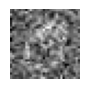




1it [00:00, 28.59it/s]


Processing Timesteps for Image 4:  29%|██▉       | 10/34 [00:20<00:46,  1.95s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 271
Processing Number: 0, Image Order: 4, Timestep: 301
clean analyze Raw Data


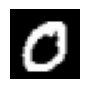

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


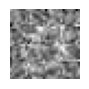




1it [00:00, 36.98it/s]


Processing Timesteps for Image 4:  32%|███▏      | 11/34 [00:21<00:44,  1.92s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 301
Processing Number: 0, Image Order: 4, Timestep: 331
clean analyze Raw Data


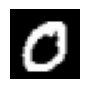

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


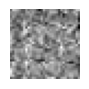




1it [00:00, 32.79it/s]


Processing Timesteps for Image 4:  35%|███▌      | 12/34 [00:24<00:48,  2.20s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 331
Processing Number: 0, Image Order: 4, Timestep: 361
clean analyze Raw Data


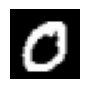

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


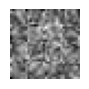




1it [00:00, 38.66it/s]


Processing Timesteps for Image 4:  38%|███▊      | 13/34 [00:26<00:45,  2.19s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 361
Processing Number: 0, Image Order: 4, Timestep: 391
clean analyze Raw Data


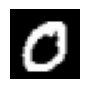

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


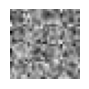




1it [00:00, 38.27it/s]


Processing Timesteps for Image 4:  41%|████      | 14/34 [00:28<00:41,  2.09s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 391
Processing Number: 0, Image Order: 4, Timestep: 421
clean analyze Raw Data


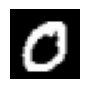

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


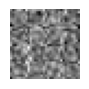




1it [00:00, 35.60it/s]


Processing Timesteps for Image 4:  44%|████▍     | 15/34 [00:30<00:38,  2.02s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 421
Processing Number: 0, Image Order: 4, Timestep: 451
clean analyze Raw Data


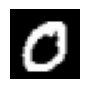

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


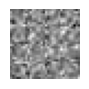




1it [00:00, 36.69it/s]


Processing Timesteps for Image 4:  47%|████▋     | 16/34 [00:32<00:35,  1.97s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 451
Processing Number: 0, Image Order: 4, Timestep: 481
clean analyze Raw Data


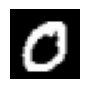

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


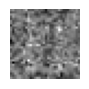




1it [00:00, 37.50it/s]


Processing Timesteps for Image 4:  50%|█████     | 17/34 [00:34<00:33,  1.94s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 481
Processing Number: 0, Image Order: 4, Timestep: 511
clean analyze Raw Data


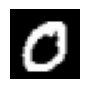

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


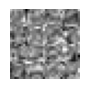




1it [00:00, 36.32it/s]


Processing Timesteps for Image 4:  53%|█████▎    | 18/34 [00:36<00:31,  1.95s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 511
Processing Number: 0, Image Order: 4, Timestep: 541
clean analyze Raw Data


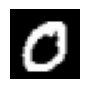

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


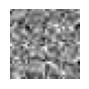




1it [00:00, 35.24it/s]


Processing Timesteps for Image 4:  56%|█████▌    | 19/34 [00:39<00:34,  2.28s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 541
Processing Number: 0, Image Order: 4, Timestep: 571
clean analyze Raw Data


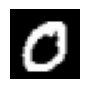

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


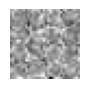




1it [00:00, 36.53it/s]


Processing Timesteps for Image 4:  59%|█████▉    | 20/34 [00:41<00:30,  2.16s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 571
Processing Number: 0, Image Order: 4, Timestep: 601
clean analyze Raw Data


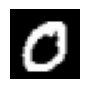

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


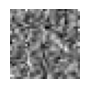




1it [00:00, 37.04it/s]


Processing Timesteps for Image 4:  62%|██████▏   | 21/34 [00:43<00:26,  2.07s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 601
Processing Number: 0, Image Order: 4, Timestep: 631
clean analyze Raw Data


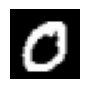

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


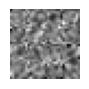




1it [00:00, 40.10it/s]


Processing Timesteps for Image 4:  65%|██████▍   | 22/34 [00:45<00:24,  2.01s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 631
Processing Number: 0, Image Order: 4, Timestep: 661
clean analyze Raw Data


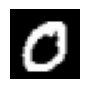

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


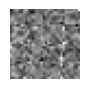




1it [00:00, 38.17it/s]


Processing Timesteps for Image 4:  68%|██████▊   | 23/34 [00:46<00:21,  1.97s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 661
Processing Number: 0, Image Order: 4, Timestep: 691
clean analyze Raw Data


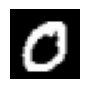

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


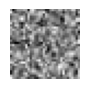




1it [00:00, 38.61it/s]


Processing Timesteps for Image 4:  71%|███████   | 24/34 [00:48<00:19,  1.93s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 691
Processing Number: 0, Image Order: 4, Timestep: 721
clean analyze Raw Data


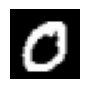

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


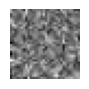




1it [00:00, 39.07it/s]


Processing Timesteps for Image 4:  74%|███████▎  | 25/34 [00:51<00:19,  2.14s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 721
Processing Number: 0, Image Order: 4, Timestep: 751
clean analyze Raw Data


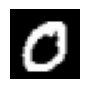

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


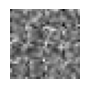




1it [00:00, 27.44it/s]


Processing Timesteps for Image 4:  76%|███████▋  | 26/34 [00:53<00:17,  2.21s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 751
Processing Number: 0, Image Order: 4, Timestep: 781
clean analyze Raw Data


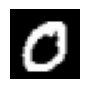

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


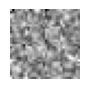




1it [00:00, 37.36it/s]


Processing Timesteps for Image 4:  79%|███████▉  | 27/34 [00:55<00:14,  2.11s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 781
Processing Number: 0, Image Order: 4, Timestep: 811
clean analyze Raw Data


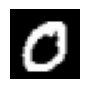

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


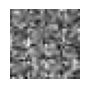




1it [00:00, 37.36it/s]


Processing Timesteps for Image 4:  82%|████████▏ | 28/34 [00:57<00:12,  2.05s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 811
Processing Number: 0, Image Order: 4, Timestep: 841
clean analyze Raw Data


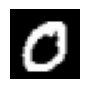

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


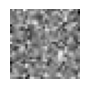




1it [00:00, 37.42it/s]


Processing Timesteps for Image 4:  85%|████████▌ | 29/34 [00:59<00:10,  2.01s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 841
Processing Number: 0, Image Order: 4, Timestep: 871
clean analyze Raw Data


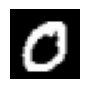

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


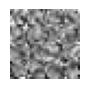




1it [00:00, 36.88it/s]


Processing Timesteps for Image 4:  88%|████████▊ | 30/34 [01:01<00:07,  1.99s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 871
Processing Number: 0, Image Order: 4, Timestep: 901
clean analyze Raw Data


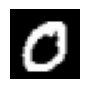

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


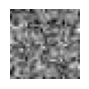




1it [00:00, 28.60it/s]


Processing Timesteps for Image 4:  91%|█████████ | 31/34 [01:03<00:05,  1.98s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 901
Processing Number: 0, Image Order: 4, Timestep: 931
clean analyze Raw Data


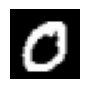

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


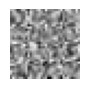




1it [00:00, 36.07it/s]


Processing Timesteps for Image 4:  94%|█████████▍| 32/34 [01:06<00:04,  2.26s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 931
Processing Number: 0, Image Order: 4, Timestep: 961
clean analyze Raw Data


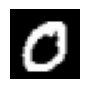

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


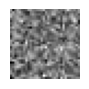




1it [00:00, 37.97it/s]


Processing Timesteps for Image 4:  97%|█████████▋| 33/34 [01:08<00:02,  2.18s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 961
Processing Number: 0, Image Order: 4, Timestep: 991
clean analyze Raw Data


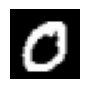

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


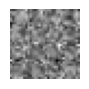




1it [00:00, 37.91it/s]


Processing Timesteps for Image 4: 100%|██████████| 34/34 [01:10<00:00,  2.09s/it]

                                                                                 
Processing Images for Number 0:  16%|█▌        | 5/32 [05:40<30:57, 68.81s/it]

Saved data for Number: 0, Image Order: 4, Timestep: 991




Processing Timesteps for Image 5:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 5, Timestep: 1
clean analyze Raw Data


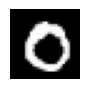

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


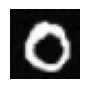




0it [00:00, ?it/s]

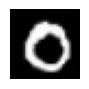

1it [00:00, 21.54it/s]


Processing Timesteps for Image 5:   3%|▎         | 1/34 [00:02<01:11,  2.17s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 1
Processing Number: 0, Image Order: 5, Timestep: 31
clean analyze Raw Data


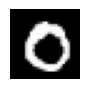

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


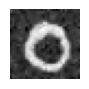




0it [00:00, ?it/s]

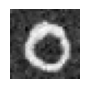

1it [00:00, 20.16it/s]


Processing Timesteps for Image 5:   6%|▌         | 2/34 [00:04<01:04,  2.02s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 31
Processing Number: 0, Image Order: 5, Timestep: 61
clean analyze Raw Data


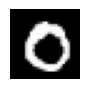

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


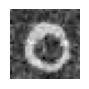




1it [00:00, 38.01it/s]


Processing Timesteps for Image 5:   9%|▉         | 3/34 [00:05<01:00,  1.96s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 61
Processing Number: 0, Image Order: 5, Timestep: 91
clean analyze Raw Data


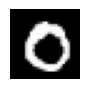

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


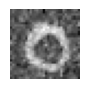




1it [00:00, 32.66it/s]


Processing Timesteps for Image 5:  12%|█▏        | 4/34 [00:08<01:07,  2.23s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 91
Processing Number: 0, Image Order: 5, Timestep: 121
clean analyze Raw Data


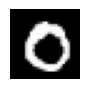

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


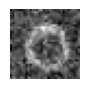




1it [00:00, 34.80it/s]


Processing Timesteps for Image 5:  15%|█▍        | 5/34 [00:10<01:06,  2.28s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 121
Processing Number: 0, Image Order: 5, Timestep: 151
clean analyze Raw Data


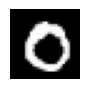

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


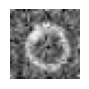




1it [00:00, 38.41it/s]


Processing Timesteps for Image 5:  18%|█▊        | 6/34 [00:12<00:59,  2.14s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 151
Processing Number: 0, Image Order: 5, Timestep: 181
clean analyze Raw Data


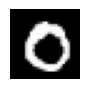

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


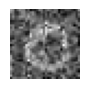




1it [00:00, 36.72it/s]


Processing Timesteps for Image 5:  21%|██        | 7/34 [00:14<00:55,  2.06s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 181
Processing Number: 0, Image Order: 5, Timestep: 211
clean analyze Raw Data


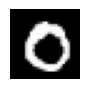

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


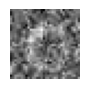




1it [00:00, 37.91it/s]


Processing Timesteps for Image 5:  24%|██▎       | 8/34 [00:16<00:52,  2.01s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 211
Processing Number: 0, Image Order: 5, Timestep: 241
clean analyze Raw Data


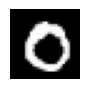

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


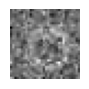




1it [00:00, 30.89it/s]


Processing Timesteps for Image 5:  26%|██▋       | 9/34 [00:18<00:49,  1.97s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 241
Processing Number: 0, Image Order: 5, Timestep: 271
clean analyze Raw Data


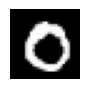

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


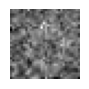




1it [00:00, 28.38it/s]


Processing Timesteps for Image 5:  29%|██▉       | 10/34 [00:20<00:47,  2.00s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 271
Processing Number: 0, Image Order: 5, Timestep: 301
clean analyze Raw Data


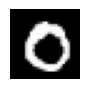

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


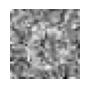




1it [00:00, 37.32it/s]


Processing Timesteps for Image 5:  32%|███▏      | 11/34 [00:23<00:52,  2.27s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 301
Processing Number: 0, Image Order: 5, Timestep: 331
clean analyze Raw Data


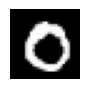

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


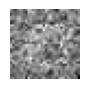




1it [00:00, 38.79it/s]


Processing Timesteps for Image 5:  35%|███▌      | 12/34 [00:25<00:47,  2.16s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 331
Processing Number: 0, Image Order: 5, Timestep: 361
clean analyze Raw Data


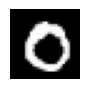

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


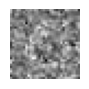




1it [00:00, 38.72it/s]


Processing Timesteps for Image 5:  38%|███▊      | 13/34 [00:27<00:43,  2.08s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 361
Processing Number: 0, Image Order: 5, Timestep: 391
clean analyze Raw Data


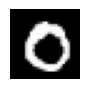

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


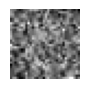




1it [00:00, 37.01it/s]


Processing Timesteps for Image 5:  41%|████      | 14/34 [00:29<00:41,  2.07s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 391
Processing Number: 0, Image Order: 5, Timestep: 421
clean analyze Raw Data


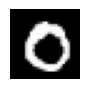

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


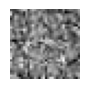




1it [00:00, 31.71it/s]


Processing Timesteps for Image 5:  44%|████▍     | 15/34 [00:31<00:38,  2.01s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 421
Processing Number: 0, Image Order: 5, Timestep: 451
clean analyze Raw Data


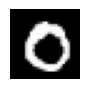

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


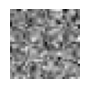




1it [00:00, 30.56it/s]


Processing Timesteps for Image 5:  47%|████▋     | 16/34 [00:34<00:41,  2.30s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 451
Processing Number: 0, Image Order: 5, Timestep: 481
clean analyze Raw Data


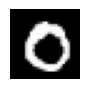

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


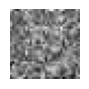




1it [00:00, 24.93it/s]


Processing Timesteps for Image 5:  50%|█████     | 17/34 [00:37<00:43,  2.54s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 481
Processing Number: 0, Image Order: 5, Timestep: 511
clean analyze Raw Data


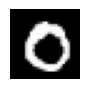

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


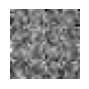




1it [00:00, 37.93it/s]


Processing Timesteps for Image 5:  53%|█████▎    | 18/34 [00:39<00:38,  2.43s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 511
Processing Number: 0, Image Order: 5, Timestep: 541
clean analyze Raw Data


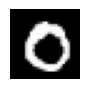

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


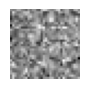




1it [00:00, 37.08it/s]


Processing Timesteps for Image 5:  56%|█████▌    | 19/34 [00:41<00:34,  2.28s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 541
Processing Number: 0, Image Order: 5, Timestep: 571
clean analyze Raw Data


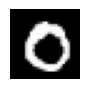

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


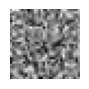




1it [00:00, 37.74it/s]


Processing Timesteps for Image 5:  59%|█████▉    | 20/34 [00:43<00:30,  2.17s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 571
Processing Number: 0, Image Order: 5, Timestep: 601
clean analyze Raw Data


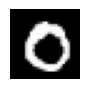

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


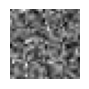




1it [00:00, 37.95it/s]


Processing Timesteps for Image 5:  62%|██████▏   | 21/34 [00:45<00:27,  2.09s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 601
Processing Number: 0, Image Order: 5, Timestep: 631
clean analyze Raw Data


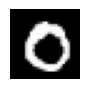

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


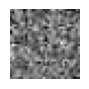




1it [00:00, 36.65it/s]


Processing Timesteps for Image 5:  65%|██████▍   | 22/34 [00:47<00:24,  2.04s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 631
Processing Number: 0, Image Order: 5, Timestep: 661
clean analyze Raw Data


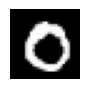

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


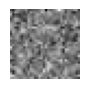




1it [00:00, 29.17it/s]


Processing Timesteps for Image 5:  68%|██████▊   | 23/34 [00:49<00:23,  2.13s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 661
Processing Number: 0, Image Order: 5, Timestep: 691
clean analyze Raw Data


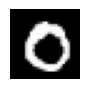

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


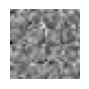




1it [00:00, 38.24it/s]


Processing Timesteps for Image 5:  71%|███████   | 24/34 [00:52<00:23,  2.33s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 691
Processing Number: 0, Image Order: 5, Timestep: 721
clean analyze Raw Data


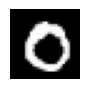

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


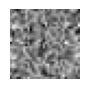




1it [00:00, 37.98it/s]


Processing Timesteps for Image 5:  74%|███████▎  | 25/34 [00:54<00:19,  2.20s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 721
Processing Number: 0, Image Order: 5, Timestep: 751
clean analyze Raw Data


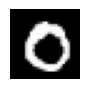

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


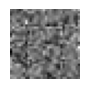




1it [00:00, 38.18it/s]


Processing Timesteps for Image 5:  76%|███████▋  | 26/34 [00:56<00:16,  2.11s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 751
Processing Number: 0, Image Order: 5, Timestep: 781
clean analyze Raw Data


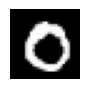

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


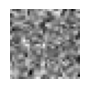




1it [00:00, 38.86it/s]


Processing Timesteps for Image 5:  79%|███████▉  | 27/34 [00:57<00:14,  2.05s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 781
Processing Number: 0, Image Order: 5, Timestep: 811
clean analyze Raw Data


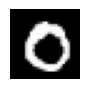

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


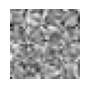




1it [00:00, 36.56it/s]


Processing Timesteps for Image 5:  82%|████████▏ | 28/34 [00:59<00:12,  2.01s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 811
Processing Number: 0, Image Order: 5, Timestep: 841
clean analyze Raw Data


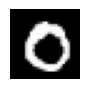

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


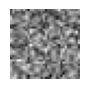




1it [00:00, 36.01it/s]


Processing Timesteps for Image 5:  85%|████████▌ | 29/34 [01:02<00:10,  2.05s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 841
Processing Number: 0, Image Order: 5, Timestep: 871
clean analyze Raw Data


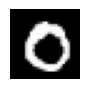

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


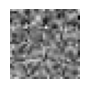




1it [00:00, 40.27it/s]


Processing Timesteps for Image 5:  88%|████████▊ | 30/34 [01:04<00:09,  2.29s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 871
Processing Number: 0, Image Order: 5, Timestep: 901
clean analyze Raw Data


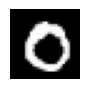

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


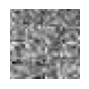




1it [00:00, 37.78it/s]


Processing Timesteps for Image 5:  91%|█████████ | 31/34 [01:07<00:06,  2.26s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 901
Processing Number: 0, Image Order: 5, Timestep: 931
clean analyze Raw Data


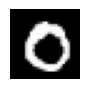

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


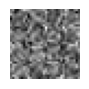




1it [00:00, 38.97it/s]


Processing Timesteps for Image 5:  94%|█████████▍| 32/34 [01:08<00:04,  2.16s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 931
Processing Number: 0, Image Order: 5, Timestep: 961
clean analyze Raw Data


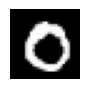

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


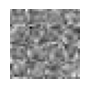




1it [00:00, 37.13it/s]


Processing Timesteps for Image 5:  97%|█████████▋| 33/34 [01:10<00:02,  2.08s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 961
Processing Number: 0, Image Order: 5, Timestep: 991
clean analyze Raw Data


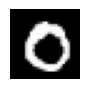

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


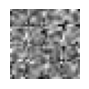




1it [00:00, 37.11it/s]


Processing Timesteps for Image 5: 100%|██████████| 34/34 [01:12<00:00,  2.03s/it]

                                                                                 
Processing Images for Number 0:  19%|█▉        | 6/32 [06:52<30:24, 70.18s/it]

Saved data for Number: 0, Image Order: 5, Timestep: 991




Processing Timesteps for Image 6:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 6, Timestep: 1
clean analyze Raw Data


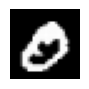

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


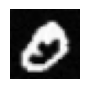




0it [00:00, ?it/s]

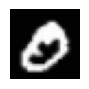

1it [00:00, 20.89it/s]


Processing Timesteps for Image 6:   3%|▎         | 1/34 [00:02<01:10,  2.14s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 1
Processing Number: 0, Image Order: 6, Timestep: 31
clean analyze Raw Data


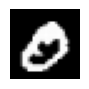

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


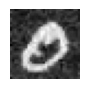




0it [00:00, ?it/s]

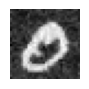

1it [00:00, 19.04it/s]


Processing Timesteps for Image 6:   6%|▌         | 2/34 [00:04<01:16,  2.40s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 31
Processing Number: 0, Image Order: 6, Timestep: 61
clean analyze Raw Data


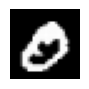

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


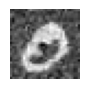




1it [00:00, 37.35it/s]


Processing Timesteps for Image 6:   9%|▉         | 3/34 [00:07<01:17,  2.51s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 61
Processing Number: 0, Image Order: 6, Timestep: 91
clean analyze Raw Data


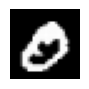

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


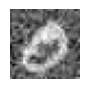




1it [00:00, 38.67it/s]


Processing Timesteps for Image 6:  12%|█▏        | 4/34 [00:09<01:08,  2.29s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 91
Processing Number: 0, Image Order: 6, Timestep: 121
clean analyze Raw Data


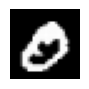

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


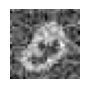




1it [00:00, 39.16it/s]


Processing Timesteps for Image 6:  15%|█▍        | 5/34 [00:11<01:02,  2.15s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 121
Processing Number: 0, Image Order: 6, Timestep: 151
clean analyze Raw Data


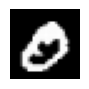

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


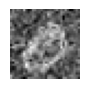




1it [00:00, 37.81it/s]


Processing Timesteps for Image 6:  18%|█▊        | 6/34 [00:13<00:58,  2.08s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 151
Processing Number: 0, Image Order: 6, Timestep: 181
clean analyze Raw Data


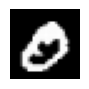

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


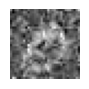




1it [00:00, 36.77it/s]


Processing Timesteps for Image 6:  21%|██        | 7/34 [00:15<00:54,  2.02s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 181
Processing Number: 0, Image Order: 6, Timestep: 211
clean analyze Raw Data


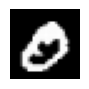

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


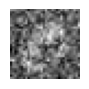




1it [00:00, 36.45it/s]


Processing Timesteps for Image 6:  24%|██▎       | 8/34 [00:17<00:52,  2.01s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 211
Processing Number: 0, Image Order: 6, Timestep: 241
clean analyze Raw Data


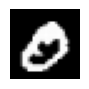

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


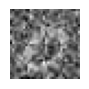




1it [00:00, 33.96it/s]


Processing Timesteps for Image 6:  26%|██▋       | 9/34 [00:19<00:56,  2.26s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 241
Processing Number: 0, Image Order: 6, Timestep: 271
clean analyze Raw Data


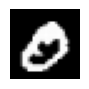

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


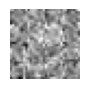




1it [00:00, 36.62it/s]


Processing Timesteps for Image 6:  29%|██▉       | 10/34 [00:22<00:54,  2.28s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 271
Processing Number: 0, Image Order: 6, Timestep: 301
clean analyze Raw Data


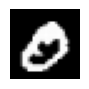

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


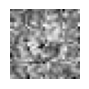




1it [00:00, 36.78it/s]


Processing Timesteps for Image 6:  32%|███▏      | 11/34 [00:24<00:49,  2.17s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 301
Processing Number: 0, Image Order: 6, Timestep: 331
clean analyze Raw Data


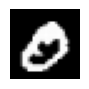

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


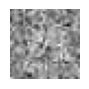




1it [00:00, 37.65it/s]


Processing Timesteps for Image 6:  35%|███▌      | 12/34 [00:26<00:46,  2.10s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 331
Processing Number: 0, Image Order: 6, Timestep: 361
clean analyze Raw Data


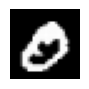

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


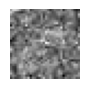




1it [00:00, 37.92it/s]


Processing Timesteps for Image 6:  38%|███▊      | 13/34 [00:27<00:43,  2.05s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 361
Processing Number: 0, Image Order: 6, Timestep: 391
clean analyze Raw Data


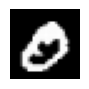

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


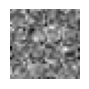




1it [00:00, 37.94it/s]


Processing Timesteps for Image 6:  41%|████      | 14/34 [00:29<00:40,  2.02s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 391
Processing Number: 0, Image Order: 6, Timestep: 421
clean analyze Raw Data


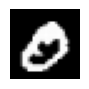

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


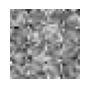




1it [00:00, 39.52it/s]


Processing Timesteps for Image 6:  44%|████▍     | 15/34 [00:32<00:40,  2.16s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 421
Processing Number: 0, Image Order: 6, Timestep: 451
clean analyze Raw Data


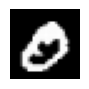

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


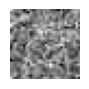




1it [00:00, 38.96it/s]


Processing Timesteps for Image 6:  47%|████▋     | 16/34 [00:35<00:41,  2.33s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 451
Processing Number: 0, Image Order: 6, Timestep: 481
clean analyze Raw Data


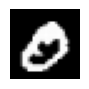

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


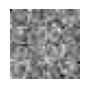




1it [00:00, 36.44it/s]


Processing Timesteps for Image 6:  50%|█████     | 17/34 [00:37<00:37,  2.21s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 481
Processing Number: 0, Image Order: 6, Timestep: 511
clean analyze Raw Data


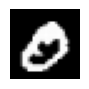

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


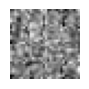




1it [00:00, 34.95it/s]


Processing Timesteps for Image 6:  53%|█████▎    | 18/34 [00:39<00:34,  2.13s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 511
Processing Number: 0, Image Order: 6, Timestep: 541
clean analyze Raw Data


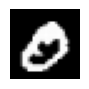

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


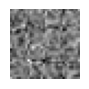




1it [00:00, 38.97it/s]


Processing Timesteps for Image 6:  56%|█████▌    | 19/34 [00:40<00:31,  2.08s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 541
Processing Number: 0, Image Order: 6, Timestep: 571
clean analyze Raw Data


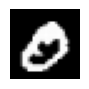

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


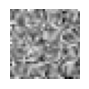




1it [00:00, 36.90it/s]


Processing Timesteps for Image 6:  59%|█████▉    | 20/34 [00:42<00:28,  2.04s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 571
Processing Number: 0, Image Order: 6, Timestep: 601
clean analyze Raw Data


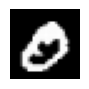

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


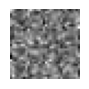




1it [00:00, 27.63it/s]


Processing Timesteps for Image 6:  62%|██████▏   | 21/34 [00:44<00:26,  2.03s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 601
Processing Number: 0, Image Order: 6, Timestep: 631
clean analyze Raw Data


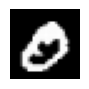

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


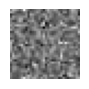




1it [00:00, 22.33it/s]


Processing Timesteps for Image 6:  65%|██████▍   | 22/34 [00:47<00:27,  2.28s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 631
Processing Number: 0, Image Order: 6, Timestep: 661
clean analyze Raw Data


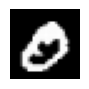

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


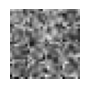




1it [00:00, 38.89it/s]


Processing Timesteps for Image 6:  68%|██████▊   | 23/34 [00:50<00:24,  2.27s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 661
Processing Number: 0, Image Order: 6, Timestep: 691
clean analyze Raw Data


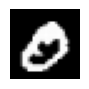

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


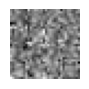




1it [00:00, 34.20it/s]


Processing Timesteps for Image 6:  71%|███████   | 24/34 [00:51<00:21,  2.17s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 691
Processing Number: 0, Image Order: 6, Timestep: 721
clean analyze Raw Data


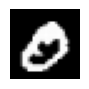

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


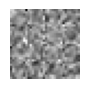




1it [00:00, 37.88it/s]


Processing Timesteps for Image 6:  74%|███████▎  | 25/34 [00:53<00:18,  2.10s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 721
Processing Number: 0, Image Order: 6, Timestep: 751
clean analyze Raw Data


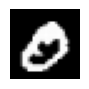

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


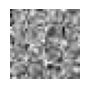




1it [00:00, 36.36it/s]


Processing Timesteps for Image 6:  76%|███████▋  | 26/34 [00:55<00:16,  2.10s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 751
Processing Number: 0, Image Order: 6, Timestep: 781
clean analyze Raw Data


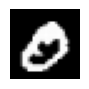

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


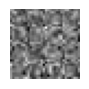




1it [00:00, 37.32it/s]


Processing Timesteps for Image 6:  79%|███████▉  | 27/34 [00:57<00:14,  2.06s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 781
Processing Number: 0, Image Order: 6, Timestep: 811
clean analyze Raw Data


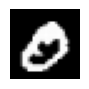

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


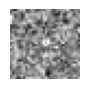




1it [00:00, 40.62it/s]


Processing Timesteps for Image 6:  82%|████████▏ | 28/34 [01:00<00:13,  2.21s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 811
Processing Number: 0, Image Order: 6, Timestep: 841
clean analyze Raw Data


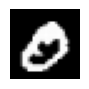

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


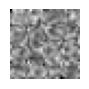




1it [00:00, 36.39it/s]


Processing Timesteps for Image 6:  85%|████████▌ | 29/34 [01:03<00:11,  2.34s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 841
Processing Number: 0, Image Order: 6, Timestep: 871
clean analyze Raw Data


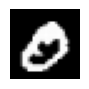

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


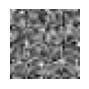




1it [00:00, 39.59it/s]


Processing Timesteps for Image 6:  88%|████████▊ | 30/34 [01:05<00:08,  2.23s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 871
Processing Number: 0, Image Order: 6, Timestep: 901
clean analyze Raw Data


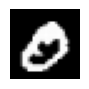

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


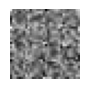




1it [00:00, 38.40it/s]


Processing Timesteps for Image 6:  91%|█████████ | 31/34 [01:07<00:06,  2.15s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 901
Processing Number: 0, Image Order: 6, Timestep: 931
clean analyze Raw Data


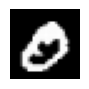

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


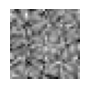




1it [00:00, 37.21it/s]


Processing Timesteps for Image 6:  94%|█████████▍| 32/34 [01:09<00:04,  2.09s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 931
Processing Number: 0, Image Order: 6, Timestep: 961
clean analyze Raw Data


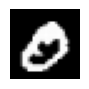

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


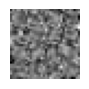




1it [00:00, 35.02it/s]


Processing Timesteps for Image 6:  97%|█████████▋| 33/34 [01:10<00:02,  2.05s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 961
Processing Number: 0, Image Order: 6, Timestep: 991
clean analyze Raw Data


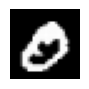

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


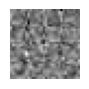




1it [00:00, 32.80it/s]


Processing Timesteps for Image 6: 100%|██████████| 34/34 [01:13<00:00,  2.04s/it]

                                                                                 
Processing Images for Number 0:  22%|██▏       | 7/32 [08:05<29:37, 71.11s/it]

Saved data for Number: 0, Image Order: 6, Timestep: 991




Processing Timesteps for Image 7:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 7, Timestep: 1
clean analyze Raw Data


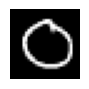

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


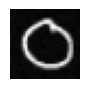




0it [00:00, ?it/s]

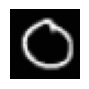

1it [00:00, 20.42it/s]


Processing Timesteps for Image 7:   3%|▎         | 1/34 [00:02<01:38,  2.99s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 1
Processing Number: 0, Image Order: 7, Timestep: 31
clean analyze Raw Data


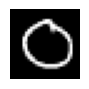

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


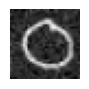




0it [00:00, ?it/s]

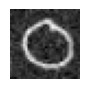

1it [00:00, 19.21it/s]


Processing Timesteps for Image 7:   6%|▌         | 2/34 [00:05<01:23,  2.62s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 31
Processing Number: 0, Image Order: 7, Timestep: 61
clean analyze Raw Data


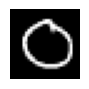

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


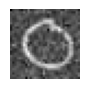




1it [00:00, 35.89it/s]


Processing Timesteps for Image 7:   9%|▉         | 3/34 [00:07<01:11,  2.32s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 61
Processing Number: 0, Image Order: 7, Timestep: 91
clean analyze Raw Data


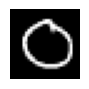

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


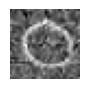




1it [00:00, 38.54it/s]


Processing Timesteps for Image 7:  12%|█▏        | 4/34 [00:09<01:05,  2.17s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 91
Processing Number: 0, Image Order: 7, Timestep: 121
clean analyze Raw Data


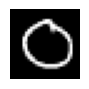

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


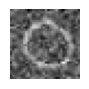




1it [00:00, 37.89it/s]


Processing Timesteps for Image 7:  15%|█▍        | 5/34 [00:11<01:00,  2.10s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 121
Processing Number: 0, Image Order: 7, Timestep: 151
clean analyze Raw Data


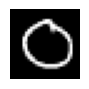

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


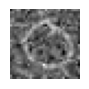




1it [00:00, 39.56it/s]


Processing Timesteps for Image 7:  18%|█▊        | 6/34 [00:13<00:57,  2.05s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 151
Processing Number: 0, Image Order: 7, Timestep: 181
clean analyze Raw Data


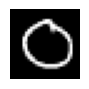

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


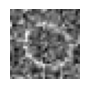




1it [00:00, 30.87it/s]


Processing Timesteps for Image 7:  21%|██        | 7/34 [00:15<01:00,  2.22s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 181
Processing Number: 0, Image Order: 7, Timestep: 211
clean analyze Raw Data


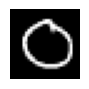

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


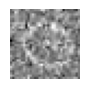




1it [00:00, 40.22it/s]


Processing Timesteps for Image 7:  24%|██▎       | 8/34 [00:18<01:02,  2.39s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 211
Processing Number: 0, Image Order: 7, Timestep: 241
clean analyze Raw Data


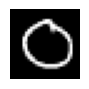

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


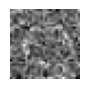




1it [00:00, 38.62it/s]


Processing Timesteps for Image 7:  26%|██▋       | 9/34 [00:20<00:56,  2.25s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 241
Processing Number: 0, Image Order: 7, Timestep: 271
clean analyze Raw Data


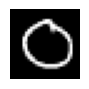

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


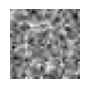




1it [00:00, 38.82it/s]


Processing Timesteps for Image 7:  29%|██▉       | 10/34 [00:22<00:52,  2.18s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 271
Processing Number: 0, Image Order: 7, Timestep: 301
clean analyze Raw Data


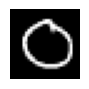

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


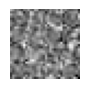




1it [00:00, 37.81it/s]


Processing Timesteps for Image 7:  32%|███▏      | 11/34 [00:24<00:48,  2.11s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 301
Processing Number: 0, Image Order: 7, Timestep: 331
clean analyze Raw Data


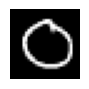

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


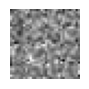




1it [00:00, 35.26it/s]


Processing Timesteps for Image 7:  35%|███▌      | 12/34 [00:26<00:45,  2.07s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 331
Processing Number: 0, Image Order: 7, Timestep: 361
clean analyze Raw Data


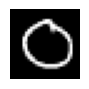

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


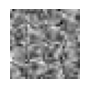




1it [00:00, 31.02it/s]


Processing Timesteps for Image 7:  38%|███▊      | 13/34 [00:28<00:43,  2.06s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 361
Processing Number: 0, Image Order: 7, Timestep: 391
clean analyze Raw Data


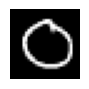

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


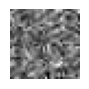




1it [00:00, 35.93it/s]


Processing Timesteps for Image 7:  41%|████      | 14/34 [00:31<00:46,  2.32s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 391
Processing Number: 0, Image Order: 7, Timestep: 421
clean analyze Raw Data


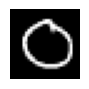

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


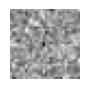




1it [00:00, 38.65it/s]


Processing Timesteps for Image 7:  44%|████▍     | 15/34 [00:33<00:43,  2.29s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 421
Processing Number: 0, Image Order: 7, Timestep: 451
clean analyze Raw Data


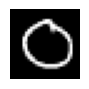

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


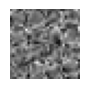




1it [00:00, 34.10it/s]


Processing Timesteps for Image 7:  47%|████▋     | 16/34 [00:35<00:39,  2.19s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 451
Processing Number: 0, Image Order: 7, Timestep: 481
clean analyze Raw Data


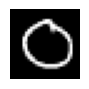

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


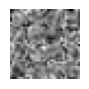




1it [00:00, 39.43it/s]


Processing Timesteps for Image 7:  50%|█████     | 17/34 [00:37<00:36,  2.13s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 481
Processing Number: 0, Image Order: 7, Timestep: 511
clean analyze Raw Data


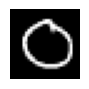

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


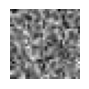




1it [00:00, 38.11it/s]


Processing Timesteps for Image 7:  53%|█████▎    | 18/34 [00:39<00:33,  2.08s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 511
Processing Number: 0, Image Order: 7, Timestep: 541
clean analyze Raw Data


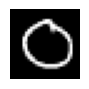

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


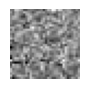




1it [00:00, 37.52it/s]


Processing Timesteps for Image 7:  56%|█████▌    | 19/34 [00:41<00:30,  2.05s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 541
Processing Number: 0, Image Order: 7, Timestep: 571
clean analyze Raw Data


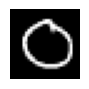

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


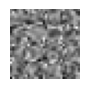




1it [00:00, 33.16it/s]


Processing Timesteps for Image 7:  59%|█████▉    | 20/34 [00:44<00:30,  2.21s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 571
Processing Number: 0, Image Order: 7, Timestep: 601
clean analyze Raw Data


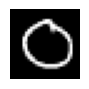

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


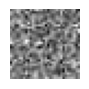




1it [00:00, 37.63it/s]


Processing Timesteps for Image 7:  62%|██████▏   | 21/34 [00:46<00:30,  2.35s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 601
Processing Number: 0, Image Order: 7, Timestep: 631
clean analyze Raw Data


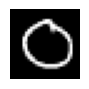

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


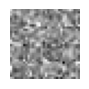




1it [00:00, 36.52it/s]


Processing Timesteps for Image 7:  65%|██████▍   | 22/34 [00:48<00:26,  2.23s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 631
Processing Number: 0, Image Order: 7, Timestep: 661
clean analyze Raw Data


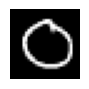

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


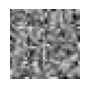




1it [00:00, 39.22it/s]


Processing Timesteps for Image 7:  68%|██████▊   | 23/34 [00:51<00:25,  2.33s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 661
Processing Number: 0, Image Order: 7, Timestep: 691
clean analyze Raw Data


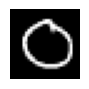

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


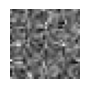




1it [00:00, 39.14it/s]


Processing Timesteps for Image 7:  71%|███████   | 24/34 [00:54<00:24,  2.49s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 691
Processing Number: 0, Image Order: 7, Timestep: 721
clean analyze Raw Data


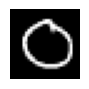

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


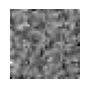




1it [00:00, 37.79it/s]


Processing Timesteps for Image 7:  74%|███████▎  | 25/34 [00:56<00:21,  2.34s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 721
Processing Number: 0, Image Order: 7, Timestep: 751
clean analyze Raw Data


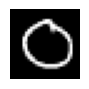

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


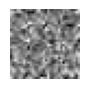




1it [00:00, 36.95it/s]


Processing Timesteps for Image 7:  76%|███████▋  | 26/34 [00:58<00:19,  2.49s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 751
Processing Number: 0, Image Order: 7, Timestep: 781
clean analyze Raw Data


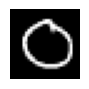

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


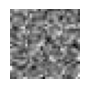




1it [00:00, 39.08it/s]


Processing Timesteps for Image 7:  79%|███████▉  | 27/34 [01:01<00:17,  2.46s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 781
Processing Number: 0, Image Order: 7, Timestep: 811
clean analyze Raw Data


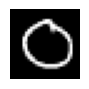

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


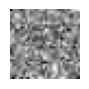




1it [00:00, 37.81it/s]


Processing Timesteps for Image 7:  82%|████████▏ | 28/34 [01:03<00:13,  2.32s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 811
Processing Number: 0, Image Order: 7, Timestep: 841
clean analyze Raw Data


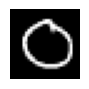

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


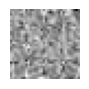




1it [00:00, 37.55it/s]


Processing Timesteps for Image 7:  85%|████████▌ | 29/34 [01:05<00:11,  2.23s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 841
Processing Number: 0, Image Order: 7, Timestep: 871
clean analyze Raw Data


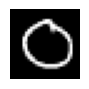

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


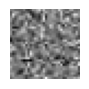




1it [00:00, 39.05it/s]


Processing Timesteps for Image 7:  88%|████████▊ | 30/34 [01:07<00:08,  2.16s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 871
Processing Number: 0, Image Order: 7, Timestep: 901
clean analyze Raw Data


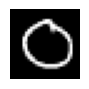

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


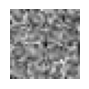




1it [00:00, 38.24it/s]


Processing Timesteps for Image 7:  91%|█████████ | 31/34 [01:09<00:06,  2.11s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 901
Processing Number: 0, Image Order: 7, Timestep: 931
clean analyze Raw Data


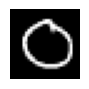

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


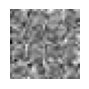




1it [00:00, 27.61it/s]


Processing Timesteps for Image 7:  94%|█████████▍| 32/34 [01:11<00:04,  2.24s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 931
Processing Number: 0, Image Order: 7, Timestep: 961
clean analyze Raw Data


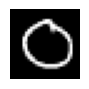

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


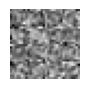




1it [00:00, 38.29it/s]


Processing Timesteps for Image 7:  97%|█████████▋| 33/34 [01:14<00:02,  2.39s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 961
Processing Number: 0, Image Order: 7, Timestep: 991
clean analyze Raw Data


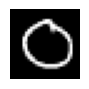

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


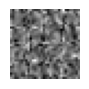




1it [00:00, 37.86it/s]


Processing Timesteps for Image 7: 100%|██████████| 34/34 [01:16<00:00,  2.29s/it]

                                                                                 
Processing Images for Number 0:  25%|██▌       | 8/32 [09:22<29:09, 72.88s/it]

Saved data for Number: 0, Image Order: 7, Timestep: 991




Processing Timesteps for Image 8:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 8, Timestep: 1
clean analyze Raw Data


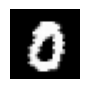

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


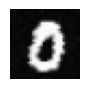




0it [00:00, ?it/s]

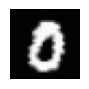

1it [00:00, 20.41it/s]


Processing Timesteps for Image 8:   3%|▎         | 1/34 [00:02<01:15,  2.29s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 1
Processing Number: 0, Image Order: 8, Timestep: 31
clean analyze Raw Data


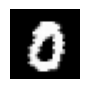

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


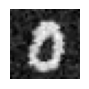




0it [00:00, ?it/s]

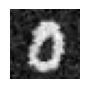

1it [00:00, 19.60it/s]


Processing Timesteps for Image 8:   6%|▌         | 2/34 [00:04<01:08,  2.15s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 31
Processing Number: 0, Image Order: 8, Timestep: 61
clean analyze Raw Data


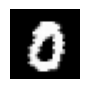

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


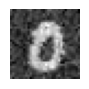




1it [00:00, 34.80it/s]


Processing Timesteps for Image 8:   9%|▉         | 3/34 [00:06<01:05,  2.11s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 61
Processing Number: 0, Image Order: 8, Timestep: 91
clean analyze Raw Data


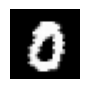

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


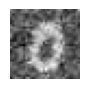




1it [00:00, 25.06it/s]


Processing Timesteps for Image 8:  12%|█▏        | 4/34 [00:09<01:10,  2.36s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 91
Processing Number: 0, Image Order: 8, Timestep: 121
clean analyze Raw Data


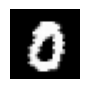

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


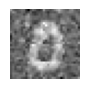




1it [00:00, 37.16it/s]


Processing Timesteps for Image 8:  15%|█▍        | 5/34 [00:11<01:11,  2.48s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 121
Processing Number: 0, Image Order: 8, Timestep: 151
clean analyze Raw Data


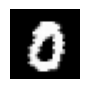

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


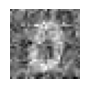




1it [00:00, 35.76it/s]


Processing Timesteps for Image 8:  18%|█▊        | 6/34 [00:13<01:04,  2.32s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 151
Processing Number: 0, Image Order: 8, Timestep: 181
clean analyze Raw Data


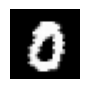

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


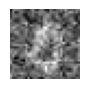




1it [00:00, 37.82it/s]


Processing Timesteps for Image 8:  21%|██        | 7/34 [00:15<00:59,  2.21s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 181
Processing Number: 0, Image Order: 8, Timestep: 211
clean analyze Raw Data


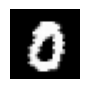

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


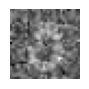




1it [00:00, 38.55it/s]


Processing Timesteps for Image 8:  24%|██▎       | 8/34 [00:17<00:55,  2.15s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 211
Processing Number: 0, Image Order: 8, Timestep: 241
clean analyze Raw Data


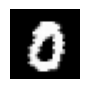

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


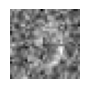




1it [00:00, 37.02it/s]


Processing Timesteps for Image 8:  26%|██▋       | 9/34 [00:19<00:52,  2.11s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 241
Processing Number: 0, Image Order: 8, Timestep: 271
clean analyze Raw Data


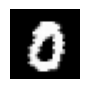

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


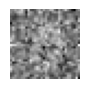




1it [00:00, 24.57it/s]


Processing Timesteps for Image 8:  29%|██▉       | 10/34 [00:22<00:51,  2.16s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 271
Processing Number: 0, Image Order: 8, Timestep: 301
clean analyze Raw Data


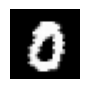

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


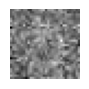




1it [00:00, 25.81it/s]


Processing Timesteps for Image 8:  32%|███▏      | 11/34 [00:25<00:55,  2.42s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 301
Processing Number: 0, Image Order: 8, Timestep: 331
clean analyze Raw Data


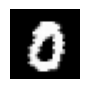

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


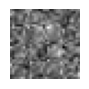




1it [00:00, 39.69it/s]


Processing Timesteps for Image 8:  35%|███▌      | 12/34 [00:27<00:50,  2.29s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 331
Processing Number: 0, Image Order: 8, Timestep: 361
clean analyze Raw Data


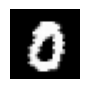

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


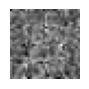




1it [00:00, 34.12it/s]


Processing Timesteps for Image 8:  38%|███▊      | 13/34 [00:29<00:46,  2.20s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 361
Processing Number: 0, Image Order: 8, Timestep: 391
clean analyze Raw Data


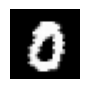

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


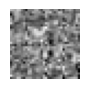




1it [00:00, 37.32it/s]


Processing Timesteps for Image 8:  41%|████      | 14/34 [00:31<00:42,  2.15s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 391
Processing Number: 0, Image Order: 8, Timestep: 421
clean analyze Raw Data


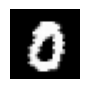

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


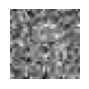




1it [00:00, 37.51it/s]


Processing Timesteps for Image 8:  44%|████▍     | 15/34 [00:33<00:39,  2.10s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 421
Processing Number: 0, Image Order: 8, Timestep: 451
clean analyze Raw Data


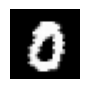

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


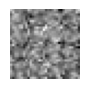




1it [00:00, 30.46it/s]


Processing Timesteps for Image 8:  47%|████▋     | 16/34 [00:35<00:37,  2.09s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 451
Processing Number: 0, Image Order: 8, Timestep: 481
clean analyze Raw Data


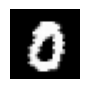

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


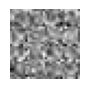




1it [00:00, 37.83it/s]


Processing Timesteps for Image 8:  50%|█████     | 17/34 [00:38<00:39,  2.33s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 481
Processing Number: 0, Image Order: 8, Timestep: 511
clean analyze Raw Data


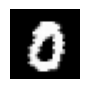

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


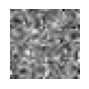




1it [00:00, 38.27it/s]


Processing Timesteps for Image 8:  53%|█████▎    | 18/34 [00:40<00:37,  2.36s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 511
Processing Number: 0, Image Order: 8, Timestep: 541
clean analyze Raw Data


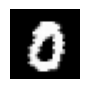

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


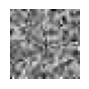




1it [00:00, 37.02it/s]


Processing Timesteps for Image 8:  56%|█████▌    | 19/34 [00:42<00:33,  2.26s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 541
Processing Number: 0, Image Order: 8, Timestep: 571
clean analyze Raw Data


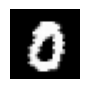

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


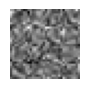




1it [00:00, 37.00it/s]


Processing Timesteps for Image 8:  59%|█████▉    | 20/34 [00:44<00:30,  2.19s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 571
Processing Number: 0, Image Order: 8, Timestep: 601
clean analyze Raw Data


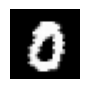

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


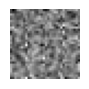




1it [00:00, 35.47it/s]


Processing Timesteps for Image 8:  62%|██████▏   | 21/34 [00:46<00:28,  2.19s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 601
Processing Number: 0, Image Order: 8, Timestep: 631
clean analyze Raw Data


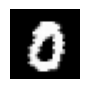

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


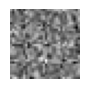




1it [00:00, 37.38it/s]


Processing Timesteps for Image 8:  65%|██████▍   | 22/34 [00:48<00:25,  2.14s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 631
Processing Number: 0, Image Order: 8, Timestep: 661
clean analyze Raw Data


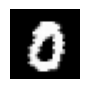

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


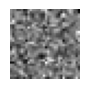




1it [00:00, 37.15it/s]


Processing Timesteps for Image 8:  68%|██████▊   | 23/34 [00:51<00:25,  2.35s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 661
Processing Number: 0, Image Order: 8, Timestep: 691
clean analyze Raw Data


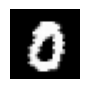

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


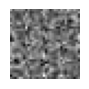




1it [00:00, 37.54it/s]


Processing Timesteps for Image 8:  71%|███████   | 24/34 [00:54<00:24,  2.40s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 691
Processing Number: 0, Image Order: 8, Timestep: 721
clean analyze Raw Data


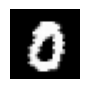

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


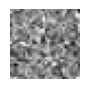




1it [00:00, 37.46it/s]


Processing Timesteps for Image 8:  74%|███████▎  | 25/34 [00:56<00:20,  2.30s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 721
Processing Number: 0, Image Order: 8, Timestep: 751
clean analyze Raw Data


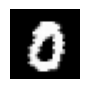

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


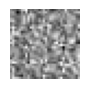




1it [00:00, 37.56it/s]


Processing Timesteps for Image 8:  76%|███████▋  | 26/34 [00:58<00:17,  2.21s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 751
Processing Number: 0, Image Order: 8, Timestep: 781
clean analyze Raw Data


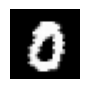

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


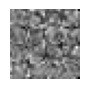




1it [00:00, 38.14it/s]


Processing Timesteps for Image 8:  79%|███████▉  | 27/34 [01:00<00:15,  2.17s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 781
Processing Number: 0, Image Order: 8, Timestep: 811
clean analyze Raw Data


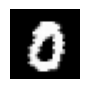

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


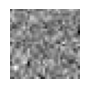




1it [00:00, 38.74it/s]


Processing Timesteps for Image 8:  82%|████████▏ | 28/34 [01:02<00:12,  2.13s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 811
Processing Number: 0, Image Order: 8, Timestep: 841
clean analyze Raw Data


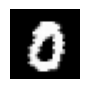

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


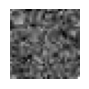




1it [00:00, 31.13it/s]


Processing Timesteps for Image 8:  85%|████████▌ | 29/34 [01:04<00:11,  2.28s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 841
Processing Number: 0, Image Order: 8, Timestep: 871
clean analyze Raw Data


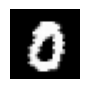

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


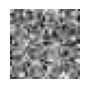




1it [00:00, 35.50it/s]


Processing Timesteps for Image 8:  88%|████████▊ | 30/34 [01:07<00:09,  2.43s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 871
Processing Number: 0, Image Order: 8, Timestep: 901
clean analyze Raw Data


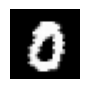

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


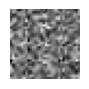




1it [00:00, 36.88it/s]


Processing Timesteps for Image 8:  91%|█████████ | 31/34 [01:09<00:06,  2.31s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 901
Processing Number: 0, Image Order: 8, Timestep: 931
clean analyze Raw Data


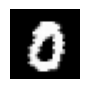

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


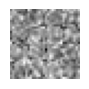




1it [00:00, 36.86it/s]


Processing Timesteps for Image 8:  94%|█████████▍| 32/34 [01:11<00:04,  2.23s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 931
Processing Number: 0, Image Order: 8, Timestep: 961
clean analyze Raw Data


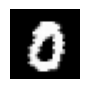

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


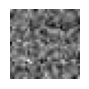




1it [00:00, 36.90it/s]


Processing Timesteps for Image 8:  97%|█████████▋| 33/34 [01:13<00:02,  2.17s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 961
Processing Number: 0, Image Order: 8, Timestep: 991
clean analyze Raw Data


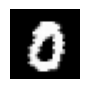

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


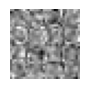




1it [00:00, 37.48it/s]


Processing Timesteps for Image 8: 100%|██████████| 34/34 [01:15<00:00,  2.13s/it]

                                                                                 
Processing Images for Number 0:  28%|██▊       | 9/32 [10:38<28:18, 73.83s/it]

Saved data for Number: 0, Image Order: 8, Timestep: 991




Processing Timesteps for Image 9:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 9, Timestep: 1
clean analyze Raw Data


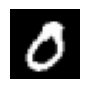

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


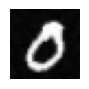




0it [00:00, ?it/s]

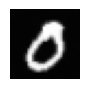

1it [00:00, 17.71it/s]


Processing Timesteps for Image 9:   3%|▎         | 1/34 [00:02<01:35,  2.89s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 1
Processing Number: 0, Image Order: 9, Timestep: 31
clean analyze Raw Data


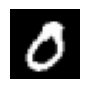

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


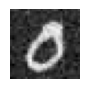




0it [00:00, ?it/s]

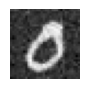

1it [00:00, 18.83it/s]


Processing Timesteps for Image 9:   6%|▌         | 2/34 [00:05<01:33,  2.92s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 31
Processing Number: 0, Image Order: 9, Timestep: 61
clean analyze Raw Data


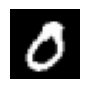

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


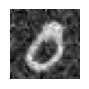




1it [00:00, 37.68it/s]


Processing Timesteps for Image 9:   9%|▉         | 3/34 [00:08<01:20,  2.61s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 61
Processing Number: 0, Image Order: 9, Timestep: 91
clean analyze Raw Data


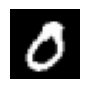

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


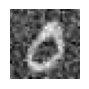




1it [00:00, 37.36it/s]


Processing Timesteps for Image 9:  12%|█▏        | 4/34 [00:10<01:11,  2.39s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 91
Processing Number: 0, Image Order: 9, Timestep: 121
clean analyze Raw Data


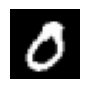

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


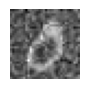




1it [00:00, 34.29it/s]


Processing Timesteps for Image 9:  15%|█▍        | 5/34 [00:12<01:05,  2.28s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 121
Processing Number: 0, Image Order: 9, Timestep: 151
clean analyze Raw Data


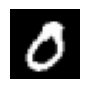

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


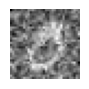




1it [00:00, 36.36it/s]


Processing Timesteps for Image 9:  18%|█▊        | 6/34 [00:14<01:01,  2.20s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 151
Processing Number: 0, Image Order: 9, Timestep: 181
clean analyze Raw Data


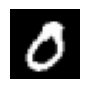

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


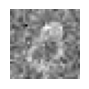




1it [00:00, 24.49it/s]


Processing Timesteps for Image 9:  21%|██        | 7/34 [00:16<01:00,  2.23s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 181
Processing Number: 0, Image Order: 9, Timestep: 211
clean analyze Raw Data


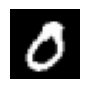

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


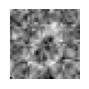




1it [00:00, 30.62it/s]


Processing Timesteps for Image 9:  24%|██▎       | 8/34 [00:19<01:04,  2.48s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 211
Processing Number: 0, Image Order: 9, Timestep: 241
clean analyze Raw Data


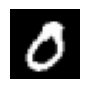

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


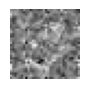




1it [00:00, 39.69it/s]


Processing Timesteps for Image 9:  26%|██▋       | 9/34 [00:21<00:59,  2.37s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 241
Processing Number: 0, Image Order: 9, Timestep: 271
clean analyze Raw Data


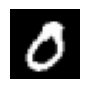

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


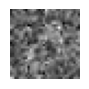




1it [00:00, 37.31it/s]


Processing Timesteps for Image 9:  29%|██▉       | 10/34 [00:23<00:54,  2.27s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 271
Processing Number: 0, Image Order: 9, Timestep: 301
clean analyze Raw Data


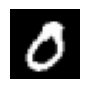

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


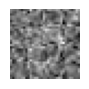




1it [00:00, 38.62it/s]


Processing Timesteps for Image 9:  32%|███▏      | 11/34 [00:25<00:50,  2.21s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 301
Processing Number: 0, Image Order: 9, Timestep: 331
clean analyze Raw Data


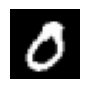

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


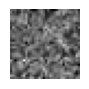




1it [00:00, 38.50it/s]


Processing Timesteps for Image 9:  35%|███▌      | 12/34 [00:27<00:47,  2.17s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 331
Processing Number: 0, Image Order: 9, Timestep: 361
clean analyze Raw Data


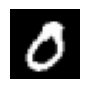

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


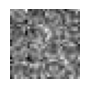




1it [00:00, 32.56it/s]


Processing Timesteps for Image 9:  38%|███▊      | 13/34 [00:29<00:44,  2.14s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 361
Processing Number: 0, Image Order: 9, Timestep: 391
clean analyze Raw Data


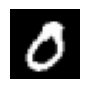

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


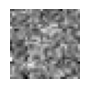




1it [00:00, 39.50it/s]


Processing Timesteps for Image 9:  41%|████      | 14/34 [00:32<00:47,  2.35s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 391
Processing Number: 0, Image Order: 9, Timestep: 421
clean analyze Raw Data


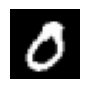

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


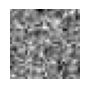




1it [00:00, 37.87it/s]


Processing Timesteps for Image 9:  44%|████▍     | 15/34 [00:35<00:45,  2.40s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 421
Processing Number: 0, Image Order: 9, Timestep: 451
clean analyze Raw Data


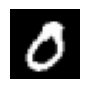

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


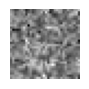




1it [00:00, 37.46it/s]


Processing Timesteps for Image 9:  47%|████▋     | 16/34 [00:37<00:41,  2.29s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 451
Processing Number: 0, Image Order: 9, Timestep: 481
clean analyze Raw Data


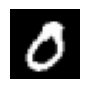

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


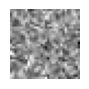




1it [00:00, 37.75it/s]


Processing Timesteps for Image 9:  50%|█████     | 17/34 [00:39<00:37,  2.22s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 481
Processing Number: 0, Image Order: 9, Timestep: 511
clean analyze Raw Data


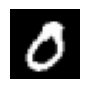

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


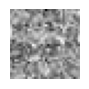




1it [00:00, 38.76it/s]


Processing Timesteps for Image 9:  53%|█████▎    | 18/34 [00:41<00:34,  2.17s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 511
Processing Number: 0, Image Order: 9, Timestep: 541
clean analyze Raw Data


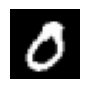

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


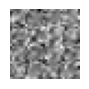




1it [00:00, 37.11it/s]


Processing Timesteps for Image 9:  56%|█████▌    | 19/34 [00:43<00:32,  2.17s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 541
Processing Number: 0, Image Order: 9, Timestep: 571
clean analyze Raw Data


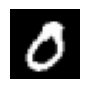

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


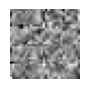




1it [00:00, 38.41it/s]


Processing Timesteps for Image 9:  59%|█████▉    | 20/34 [00:46<00:33,  2.37s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 571
Processing Number: 0, Image Order: 9, Timestep: 601
clean analyze Raw Data


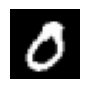

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


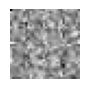




1it [00:00, 37.58it/s]


Processing Timesteps for Image 9:  62%|██████▏   | 21/34 [00:49<00:31,  2.45s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 601
Processing Number: 0, Image Order: 9, Timestep: 631
clean analyze Raw Data


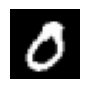

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


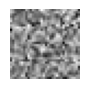




1it [00:00, 37.60it/s]


Processing Timesteps for Image 9:  65%|██████▍   | 22/34 [00:51<00:28,  2.35s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 631
Processing Number: 0, Image Order: 9, Timestep: 661
clean analyze Raw Data


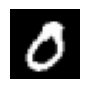

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


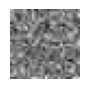




1it [00:00, 38.69it/s]


Processing Timesteps for Image 9:  68%|██████▊   | 23/34 [00:53<00:24,  2.27s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 661
Processing Number: 0, Image Order: 9, Timestep: 691
clean analyze Raw Data


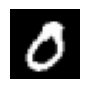

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


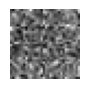




1it [00:00, 37.98it/s]


Processing Timesteps for Image 9:  71%|███████   | 24/34 [00:55<00:22,  2.21s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 691
Processing Number: 0, Image Order: 9, Timestep: 721
clean analyze Raw Data


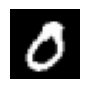

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


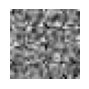




1it [00:00, 38.50it/s]


Processing Timesteps for Image 9:  74%|███████▎  | 25/34 [00:57<00:19,  2.17s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 721
Processing Number: 0, Image Order: 9, Timestep: 751
clean analyze Raw Data


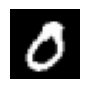

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


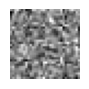




1it [00:00, 30.90it/s]


Processing Timesteps for Image 9:  76%|███████▋  | 26/34 [01:00<00:19,  2.39s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 751
Processing Number: 0, Image Order: 9, Timestep: 781
clean analyze Raw Data


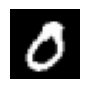

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


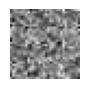




1it [00:00, 31.16it/s]


Processing Timesteps for Image 9:  79%|███████▉  | 27/34 [01:03<00:18,  2.64s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 781
Processing Number: 0, Image Order: 9, Timestep: 811
clean analyze Raw Data


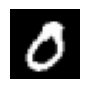

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


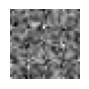




1it [00:00, 38.57it/s]


Processing Timesteps for Image 9:  82%|████████▏ | 28/34 [01:06<00:16,  2.71s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 811
Processing Number: 0, Image Order: 9, Timestep: 841
clean analyze Raw Data


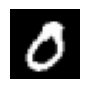

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


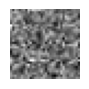




1it [00:00, 37.63it/s]


Processing Timesteps for Image 9:  85%|████████▌ | 29/34 [01:08<00:12,  2.52s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 841
Processing Number: 0, Image Order: 9, Timestep: 871
clean analyze Raw Data


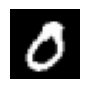

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


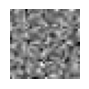




1it [00:00, 36.98it/s]


Processing Timesteps for Image 9:  88%|████████▊ | 30/34 [01:10<00:09,  2.39s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 871
Processing Number: 0, Image Order: 9, Timestep: 901
clean analyze Raw Data


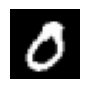

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


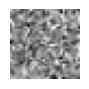




1it [00:00, 33.97it/s]


Processing Timesteps for Image 9:  91%|█████████ | 31/34 [01:12<00:06,  2.29s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 901
Processing Number: 0, Image Order: 9, Timestep: 931
clean analyze Raw Data


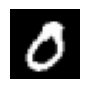

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


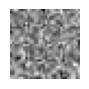




1it [00:00, 36.48it/s]


Processing Timesteps for Image 9:  94%|█████████▍| 32/34 [01:14<00:04,  2.22s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 931
Processing Number: 0, Image Order: 9, Timestep: 961
clean analyze Raw Data


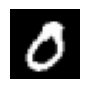

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


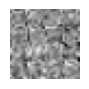




1it [00:00, 40.00it/s]


Processing Timesteps for Image 9:  97%|█████████▋| 33/34 [01:17<00:02,  2.41s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 961
Processing Number: 0, Image Order: 9, Timestep: 991
clean analyze Raw Data


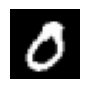

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


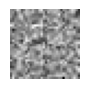




1it [00:00, 37.93it/s]


Processing Timesteps for Image 9: 100%|██████████| 34/34 [01:20<00:00,  2.48s/it]

                                                                                 
Processing Images for Number 0:  31%|███▏      | 10/32 [11:58<27:47, 75.80s/it]

Saved data for Number: 0, Image Order: 9, Timestep: 991




Processing Timesteps for Image 10:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 10, Timestep: 1
clean analyze Raw Data


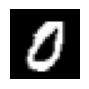

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


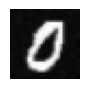




0it [00:00, ?it/s]

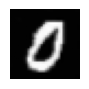

1it [00:00, 20.19it/s]


Processing Timesteps for Image 10:   3%|▎         | 1/34 [00:02<01:26,  2.62s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 1
Processing Number: 0, Image Order: 10, Timestep: 31
clean analyze Raw Data


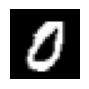

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


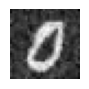




0it [00:00, ?it/s]

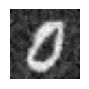

1it [00:00, 19.59it/s]


Processing Timesteps for Image 10:   6%|▌         | 2/34 [00:04<01:14,  2.34s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 31
Processing Number: 0, Image Order: 10, Timestep: 61
clean analyze Raw Data


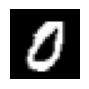

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


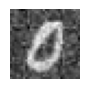




1it [00:00, 38.51it/s]


Processing Timesteps for Image 10:   9%|▉         | 3/34 [00:06<01:09,  2.23s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 61
Processing Number: 0, Image Order: 10, Timestep: 91
clean analyze Raw Data


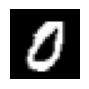

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


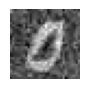




1it [00:00, 38.93it/s]


Processing Timesteps for Image 10:  12%|█▏        | 4/34 [00:08<01:05,  2.17s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 91
Processing Number: 0, Image Order: 10, Timestep: 121
clean analyze Raw Data


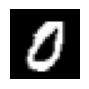

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


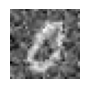




1it [00:00, 31.52it/s]


Processing Timesteps for Image 10:  15%|█▍        | 5/34 [00:11<01:10,  2.43s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 121
Processing Number: 0, Image Order: 10, Timestep: 151
clean analyze Raw Data


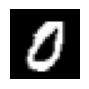

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


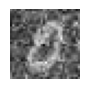




1it [00:00, 37.07it/s]


Processing Timesteps for Image 10:  18%|█▊        | 6/34 [00:14<01:09,  2.48s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 151
Processing Number: 0, Image Order: 10, Timestep: 181
clean analyze Raw Data


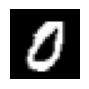

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


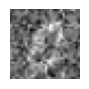




1it [00:00, 38.34it/s]


Processing Timesteps for Image 10:  21%|██        | 7/34 [00:16<01:03,  2.35s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 181
Processing Number: 0, Image Order: 10, Timestep: 211
clean analyze Raw Data


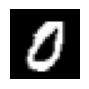

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


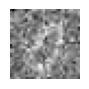




1it [00:00, 38.66it/s]


Processing Timesteps for Image 10:  24%|██▎       | 8/34 [00:18<00:58,  2.26s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 211
Processing Number: 0, Image Order: 10, Timestep: 241
clean analyze Raw Data


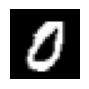

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


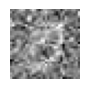




1it [00:00, 36.72it/s]


Processing Timesteps for Image 10:  26%|██▋       | 9/34 [00:20<00:55,  2.21s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 241
Processing Number: 0, Image Order: 10, Timestep: 271
clean analyze Raw Data


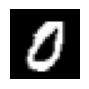

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


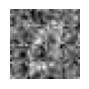




1it [00:00, 38.00it/s]


Processing Timesteps for Image 10:  29%|██▉       | 10/34 [00:22<00:52,  2.17s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 271
Processing Number: 0, Image Order: 10, Timestep: 301
clean analyze Raw Data


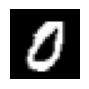

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


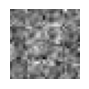




1it [00:00, 39.76it/s]


Processing Timesteps for Image 10:  32%|███▏      | 11/34 [00:25<00:54,  2.36s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 301
Processing Number: 0, Image Order: 10, Timestep: 331
clean analyze Raw Data


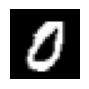

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


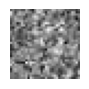




1it [00:00, 37.20it/s]


Processing Timesteps for Image 10:  35%|███▌      | 12/34 [00:28<00:54,  2.47s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 331
Processing Number: 0, Image Order: 10, Timestep: 361
clean analyze Raw Data


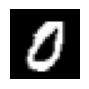

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


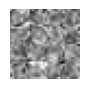




1it [00:00, 36.76it/s]


Processing Timesteps for Image 10:  38%|███▊      | 13/34 [00:30<00:49,  2.37s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 361
Processing Number: 0, Image Order: 10, Timestep: 391
clean analyze Raw Data


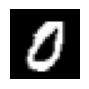

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


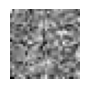




1it [00:00, 38.48it/s]


Processing Timesteps for Image 10:  41%|████      | 14/34 [00:32<00:45,  2.29s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 391
Processing Number: 0, Image Order: 10, Timestep: 421
clean analyze Raw Data


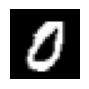

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


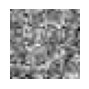




1it [00:00, 37.83it/s]


Processing Timesteps for Image 10:  44%|████▍     | 15/34 [00:34<00:42,  2.23s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 421
Processing Number: 0, Image Order: 10, Timestep: 451
clean analyze Raw Data


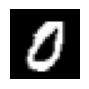

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


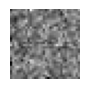




1it [00:00, 38.36it/s]


Processing Timesteps for Image 10:  47%|████▋     | 16/34 [00:36<00:39,  2.19s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 451
Processing Number: 0, Image Order: 10, Timestep: 481
clean analyze Raw Data


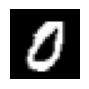

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


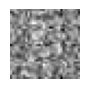




1it [00:00, 38.80it/s]


Processing Timesteps for Image 10:  50%|█████     | 17/34 [00:39<00:40,  2.41s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 481
Processing Number: 0, Image Order: 10, Timestep: 511
clean analyze Raw Data


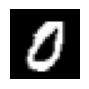

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


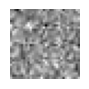




1it [00:00, 35.18it/s]


Processing Timesteps for Image 10:  53%|█████▎    | 18/34 [00:42<00:39,  2.48s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 511
Processing Number: 0, Image Order: 10, Timestep: 541
clean analyze Raw Data


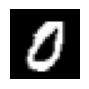

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


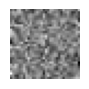




1it [00:00, 34.85it/s]


Processing Timesteps for Image 10:  56%|█████▌    | 19/34 [00:44<00:35,  2.36s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 541
Processing Number: 0, Image Order: 10, Timestep: 571
clean analyze Raw Data


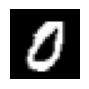

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


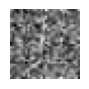




1it [00:00, 36.81it/s]


Processing Timesteps for Image 10:  59%|█████▉    | 20/34 [00:46<00:31,  2.28s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 571
Processing Number: 0, Image Order: 10, Timestep: 601
clean analyze Raw Data


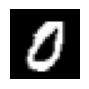

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


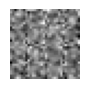




1it [00:00, 38.87it/s]


Processing Timesteps for Image 10:  62%|██████▏   | 21/34 [00:48<00:28,  2.22s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 601
Processing Number: 0, Image Order: 10, Timestep: 631
clean analyze Raw Data


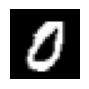

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


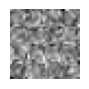




1it [00:00, 37.83it/s]


Processing Timesteps for Image 10:  65%|██████▍   | 22/34 [00:50<00:26,  2.18s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 631
Processing Number: 0, Image Order: 10, Timestep: 661
clean analyze Raw Data


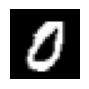

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


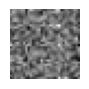




1it [00:00, 36.88it/s]


Processing Timesteps for Image 10:  68%|██████▊   | 23/34 [00:53<00:25,  2.36s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 661
Processing Number: 0, Image Order: 10, Timestep: 691
clean analyze Raw Data


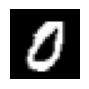

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


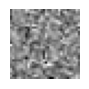




1it [00:00, 35.87it/s]


Processing Timesteps for Image 10:  71%|███████   | 24/34 [00:56<00:24,  2.47s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 691
Processing Number: 0, Image Order: 10, Timestep: 721
clean analyze Raw Data


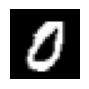

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


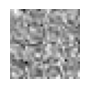




1it [00:00, 37.08it/s]


Processing Timesteps for Image 10:  74%|███████▎  | 25/34 [00:58<00:21,  2.36s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 721
Processing Number: 0, Image Order: 10, Timestep: 751
clean analyze Raw Data


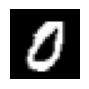

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


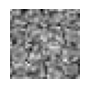




1it [00:00, 37.84it/s]


Processing Timesteps for Image 10:  76%|███████▋  | 26/34 [01:00<00:18,  2.30s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 751
Processing Number: 0, Image Order: 10, Timestep: 781
clean analyze Raw Data


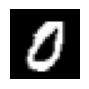

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


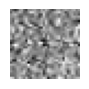




1it [00:00, 34.53it/s]


Processing Timesteps for Image 10:  79%|███████▉  | 27/34 [01:02<00:15,  2.24s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 781
Processing Number: 0, Image Order: 10, Timestep: 811
clean analyze Raw Data


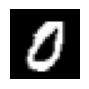

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


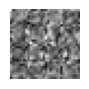




1it [00:00, 33.82it/s]


Processing Timesteps for Image 10:  82%|████████▏ | 28/34 [01:04<00:13,  2.20s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 811
Processing Number: 0, Image Order: 10, Timestep: 841
clean analyze Raw Data


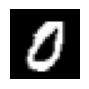

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


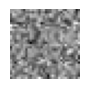




1it [00:00, 38.75it/s]


Processing Timesteps for Image 10:  85%|████████▌ | 29/34 [01:07<00:11,  2.38s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 841
Processing Number: 0, Image Order: 10, Timestep: 871
clean analyze Raw Data


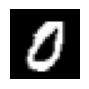

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


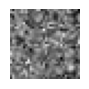




1it [00:00, 38.09it/s]


Processing Timesteps for Image 10:  88%|████████▊ | 30/34 [01:10<00:09,  2.47s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 871
Processing Number: 0, Image Order: 10, Timestep: 901
clean analyze Raw Data


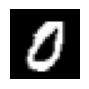

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


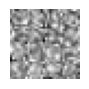




1it [00:00, 36.54it/s]


Processing Timesteps for Image 10:  91%|█████████ | 31/34 [01:12<00:07,  2.37s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 901
Processing Number: 0, Image Order: 10, Timestep: 931
clean analyze Raw Data


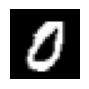

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


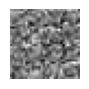




1it [00:00, 38.44it/s]


Processing Timesteps for Image 10:  94%|█████████▍| 32/34 [01:14<00:04,  2.30s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 931
Processing Number: 0, Image Order: 10, Timestep: 961
clean analyze Raw Data


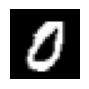

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


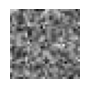




1it [00:00, 38.39it/s]


Processing Timesteps for Image 10:  97%|█████████▋| 33/34 [01:16<00:02,  2.28s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 961
Processing Number: 0, Image Order: 10, Timestep: 991
clean analyze Raw Data


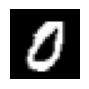

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


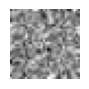




1it [00:00, 36.82it/s]


Processing Timesteps for Image 10: 100%|██████████| 34/34 [01:18<00:00,  2.23s/it]

                                                                                  
Processing Images for Number 0:  34%|███▍      | 11/32 [13:17<26:50, 76.67s/it]

Saved data for Number: 0, Image Order: 10, Timestep: 991




Processing Timesteps for Image 11:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 11, Timestep: 1
clean analyze Raw Data


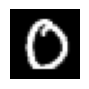

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


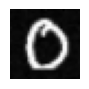




0it [00:00, ?it/s]

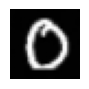

1it [00:00, 17.24it/s]


Processing Timesteps for Image 11:   3%|▎         | 1/34 [00:03<01:39,  3.01s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 1
Processing Number: 0, Image Order: 11, Timestep: 31
clean analyze Raw Data


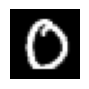

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


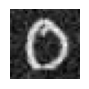




0it [00:00, ?it/s]

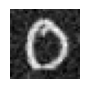

1it [00:00, 18.03it/s]


Processing Timesteps for Image 11:   6%|▌         | 2/34 [00:06<01:37,  3.03s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 31
Processing Number: 0, Image Order: 11, Timestep: 61
clean analyze Raw Data


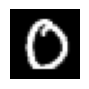

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


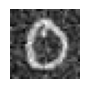




1it [00:00, 36.05it/s]


Processing Timesteps for Image 11:   9%|▉         | 3/34 [00:08<01:21,  2.62s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 61
Processing Number: 0, Image Order: 11, Timestep: 91
clean analyze Raw Data


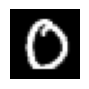

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


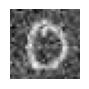




1it [00:00, 36.13it/s]


Processing Timesteps for Image 11:  12%|█▏        | 4/34 [00:10<01:12,  2.42s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 91
Processing Number: 0, Image Order: 11, Timestep: 121
clean analyze Raw Data


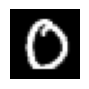

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


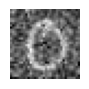




1it [00:00, 37.52it/s]


Processing Timesteps for Image 11:  15%|█▍        | 5/34 [00:12<01:07,  2.33s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 121
Processing Number: 0, Image Order: 11, Timestep: 151
clean analyze Raw Data


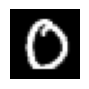

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


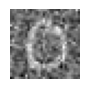




1it [00:00, 37.13it/s]


Processing Timesteps for Image 11:  18%|█▊        | 6/34 [00:14<01:03,  2.26s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 151
Processing Number: 0, Image Order: 11, Timestep: 181
clean analyze Raw Data


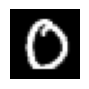

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


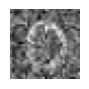




1it [00:00, 37.31it/s]


Processing Timesteps for Image 11:  21%|██        | 7/34 [00:16<01:01,  2.29s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 181
Processing Number: 0, Image Order: 11, Timestep: 211
clean analyze Raw Data


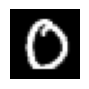

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


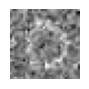




1it [00:00, 24.55it/s]


Processing Timesteps for Image 11:  24%|██▎       | 8/34 [00:20<01:06,  2.55s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 211
Processing Number: 0, Image Order: 11, Timestep: 241
clean analyze Raw Data


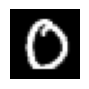

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


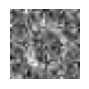




1it [00:00, 32.93it/s]


Processing Timesteps for Image 11:  26%|██▋       | 9/34 [00:22<01:01,  2.44s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 241
Processing Number: 0, Image Order: 11, Timestep: 271
clean analyze Raw Data


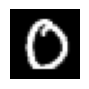

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


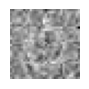




1it [00:00, 37.29it/s]


Processing Timesteps for Image 11:  29%|██▉       | 10/34 [00:24<00:56,  2.35s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 271
Processing Number: 0, Image Order: 11, Timestep: 301
clean analyze Raw Data


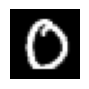

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


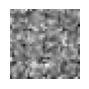




1it [00:00, 38.20it/s]


Processing Timesteps for Image 11:  32%|███▏      | 11/34 [00:26<00:52,  2.28s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 301
Processing Number: 0, Image Order: 11, Timestep: 331
clean analyze Raw Data


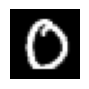

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


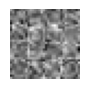




1it [00:00, 36.21it/s]


Processing Timesteps for Image 11:  35%|███▌      | 12/34 [00:28<00:49,  2.24s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 331
Processing Number: 0, Image Order: 11, Timestep: 361
clean analyze Raw Data


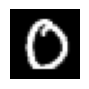

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


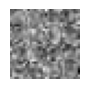




1it [00:00, 25.63it/s]


Processing Timesteps for Image 11:  38%|███▊      | 13/34 [00:31<00:48,  2.31s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 361
Processing Number: 0, Image Order: 11, Timestep: 391
clean analyze Raw Data


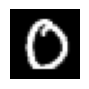

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


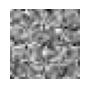




1it [00:00, 20.95it/s]


Processing Timesteps for Image 11:  41%|████      | 14/34 [00:34<00:50,  2.54s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 391
Processing Number: 0, Image Order: 11, Timestep: 421
clean analyze Raw Data


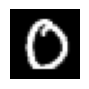

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


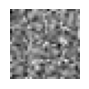




1it [00:00, 39.89it/s]


Processing Timesteps for Image 11:  44%|████▍     | 15/34 [00:36<00:46,  2.43s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 421
Processing Number: 0, Image Order: 11, Timestep: 451
clean analyze Raw Data


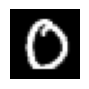

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


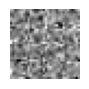




1it [00:00, 37.37it/s]


Processing Timesteps for Image 11:  47%|████▋     | 16/34 [00:38<00:42,  2.35s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 451
Processing Number: 0, Image Order: 11, Timestep: 481
clean analyze Raw Data


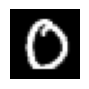

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


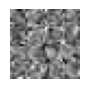




1it [00:00, 39.51it/s]


Processing Timesteps for Image 11:  50%|█████     | 17/34 [00:40<00:38,  2.28s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 481
Processing Number: 0, Image Order: 11, Timestep: 511
clean analyze Raw Data


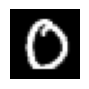

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


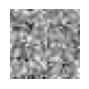




1it [00:00, 36.95it/s]


Processing Timesteps for Image 11:  53%|█████▎    | 18/34 [00:42<00:36,  2.25s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 511
Processing Number: 0, Image Order: 11, Timestep: 541
clean analyze Raw Data


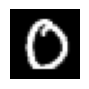

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


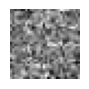




1it [00:00, 36.74it/s]


Processing Timesteps for Image 11:  56%|█████▌    | 19/34 [00:45<00:34,  2.27s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 541
Processing Number: 0, Image Order: 11, Timestep: 571
clean analyze Raw Data


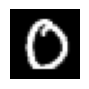

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


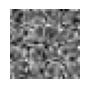




1it [00:00, 31.28it/s]


Processing Timesteps for Image 11:  59%|█████▉    | 20/34 [00:48<00:35,  2.53s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 571
Processing Number: 0, Image Order: 11, Timestep: 601
clean analyze Raw Data


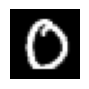

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


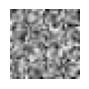




1it [00:00, 37.22it/s]


Processing Timesteps for Image 11:  62%|██████▏   | 21/34 [00:50<00:31,  2.45s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 601
Processing Number: 0, Image Order: 11, Timestep: 631
clean analyze Raw Data


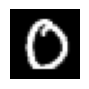

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


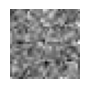




1it [00:00, 36.09it/s]


Processing Timesteps for Image 11:  65%|██████▍   | 22/34 [00:52<00:28,  2.37s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 631
Processing Number: 0, Image Order: 11, Timestep: 661
clean analyze Raw Data


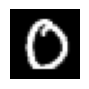

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


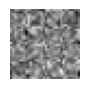




1it [00:00, 36.91it/s]


Processing Timesteps for Image 11:  68%|██████▊   | 23/34 [00:54<00:25,  2.32s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 661
Processing Number: 0, Image Order: 11, Timestep: 691
clean analyze Raw Data


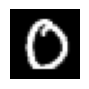

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


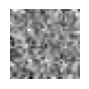




1it [00:00, 36.47it/s]


Processing Timesteps for Image 11:  71%|███████   | 24/34 [00:57<00:22,  2.27s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 691
Processing Number: 0, Image Order: 11, Timestep: 721
clean analyze Raw Data


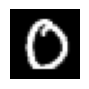

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


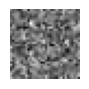




1it [00:00, 30.35it/s]


Processing Timesteps for Image 11:  74%|███████▎  | 25/34 [00:59<00:20,  2.27s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 721
Processing Number: 0, Image Order: 11, Timestep: 751
clean analyze Raw Data


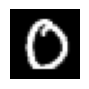

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


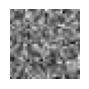




1it [00:00, 26.07it/s]


Processing Timesteps for Image 11:  76%|███████▋  | 26/34 [01:02<00:19,  2.50s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 751
Processing Number: 0, Image Order: 11, Timestep: 781
clean analyze Raw Data


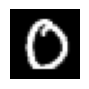

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


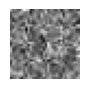




1it [00:00, 36.50it/s]


Processing Timesteps for Image 11:  79%|███████▉  | 27/34 [01:05<00:18,  2.67s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 781
Processing Number: 0, Image Order: 11, Timestep: 811
clean analyze Raw Data


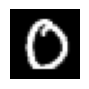

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


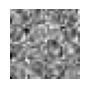




1it [00:00, 35.50it/s]


Processing Timesteps for Image 11:  82%|████████▏ | 28/34 [01:08<00:16,  2.74s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 811
Processing Number: 0, Image Order: 11, Timestep: 841
clean analyze Raw Data


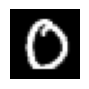

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


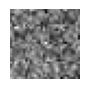




1it [00:00, 36.42it/s]


Processing Timesteps for Image 11:  85%|████████▌ | 29/34 [01:10<00:13,  2.61s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 841
Processing Number: 0, Image Order: 11, Timestep: 871
clean analyze Raw Data


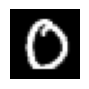

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


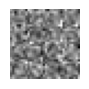




1it [00:00, 36.94it/s]


Processing Timesteps for Image 11:  88%|████████▊ | 30/34 [01:12<00:09,  2.50s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 871
Processing Number: 0, Image Order: 11, Timestep: 901
clean analyze Raw Data


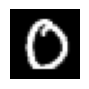

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


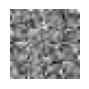




1it [00:00, 40.21it/s]


Processing Timesteps for Image 11:  91%|█████████ | 31/34 [01:15<00:07,  2.63s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 901
Processing Number: 0, Image Order: 11, Timestep: 931
clean analyze Raw Data


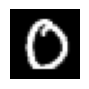

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


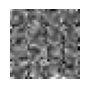




1it [00:00, 37.23it/s]


Processing Timesteps for Image 11:  94%|█████████▍| 32/34 [01:18<00:05,  2.65s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 931
Processing Number: 0, Image Order: 11, Timestep: 961
clean analyze Raw Data


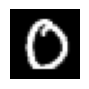

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


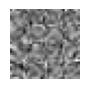




1it [00:00, 39.50it/s]


Processing Timesteps for Image 11:  97%|█████████▋| 33/34 [01:20<00:02,  2.51s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 961
Processing Number: 0, Image Order: 11, Timestep: 991
clean analyze Raw Data


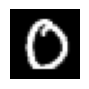

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


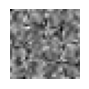




1it [00:00, 36.52it/s]


Processing Timesteps for Image 11: 100%|██████████| 34/34 [01:22<00:00,  2.41s/it]

                                                                                  
Processing Images for Number 0:  38%|███▊      | 12/32 [14:40<26:11, 78.58s/it]

Saved data for Number: 0, Image Order: 11, Timestep: 991




Processing Timesteps for Image 12:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 12, Timestep: 1
clean analyze Raw Data


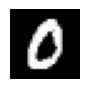

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


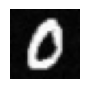




0it [00:00, ?it/s]

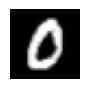

1it [00:00, 20.14it/s]


Processing Timesteps for Image 12:   3%|▎         | 1/34 [00:02<01:26,  2.63s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 1
Processing Number: 0, Image Order: 12, Timestep: 31
clean analyze Raw Data


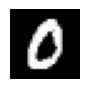

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


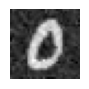




0it [00:00, ?it/s]

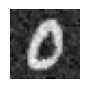

1it [00:00, 20.31it/s]


Processing Timesteps for Image 12:   6%|▌         | 2/34 [00:04<01:16,  2.39s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 31
Processing Number: 0, Image Order: 12, Timestep: 61
clean analyze Raw Data


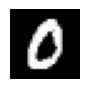

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


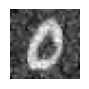




1it [00:00, 30.31it/s]


Processing Timesteps for Image 12:   9%|▉         | 3/34 [00:07<01:21,  2.64s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 61
Processing Number: 0, Image Order: 12, Timestep: 91
clean analyze Raw Data


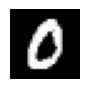

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


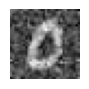




1it [00:00, 37.74it/s]


Processing Timesteps for Image 12:  12%|█▏        | 4/34 [00:10<01:20,  2.69s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 91
Processing Number: 0, Image Order: 12, Timestep: 121
clean analyze Raw Data


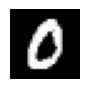

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


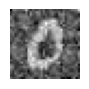




1it [00:00, 37.61it/s]


Processing Timesteps for Image 12:  15%|█▍        | 5/34 [00:12<01:12,  2.50s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 121
Processing Number: 0, Image Order: 12, Timestep: 151
clean analyze Raw Data


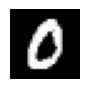

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


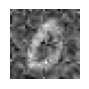




1it [00:00, 37.39it/s]


Processing Timesteps for Image 12:  18%|█▊        | 6/34 [00:14<01:06,  2.39s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 151
Processing Number: 0, Image Order: 12, Timestep: 181
clean analyze Raw Data


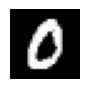

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


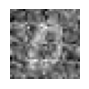




1it [00:00, 36.98it/s]


Processing Timesteps for Image 12:  21%|██        | 7/34 [00:17<01:02,  2.32s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 181
Processing Number: 0, Image Order: 12, Timestep: 211
clean analyze Raw Data


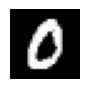

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


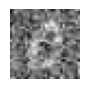




1it [00:00, 36.88it/s]


Processing Timesteps for Image 12:  24%|██▎       | 8/34 [00:19<00:59,  2.28s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 211
Processing Number: 0, Image Order: 12, Timestep: 241
clean analyze Raw Data


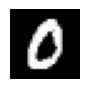

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


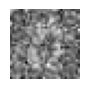




1it [00:00, 37.54it/s]


Processing Timesteps for Image 12:  26%|██▋       | 9/34 [00:22<01:01,  2.45s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 241
Processing Number: 0, Image Order: 12, Timestep: 271
clean analyze Raw Data


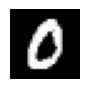

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


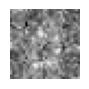




1it [00:00, 38.87it/s]


Processing Timesteps for Image 12:  29%|██▉       | 10/34 [00:24<01:01,  2.56s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 271
Processing Number: 0, Image Order: 12, Timestep: 301
clean analyze Raw Data


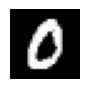

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


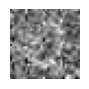




1it [00:00, 36.60it/s]


Processing Timesteps for Image 12:  32%|███▏      | 11/34 [00:27<00:57,  2.48s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 301
Processing Number: 0, Image Order: 12, Timestep: 331
clean analyze Raw Data


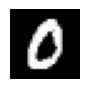

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


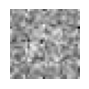




1it [00:00, 38.21it/s]


Processing Timesteps for Image 12:  35%|███▌      | 12/34 [00:29<00:52,  2.40s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 331
Processing Number: 0, Image Order: 12, Timestep: 361
clean analyze Raw Data


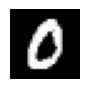

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


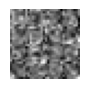




1it [00:00, 36.89it/s]


Processing Timesteps for Image 12:  38%|███▊      | 13/34 [00:31<00:49,  2.33s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 361
Processing Number: 0, Image Order: 12, Timestep: 391
clean analyze Raw Data


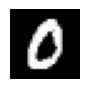

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


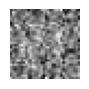




1it [00:00, 40.91it/s]


Processing Timesteps for Image 12:  41%|████      | 14/34 [00:33<00:45,  2.29s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 391
Processing Number: 0, Image Order: 12, Timestep: 421
clean analyze Raw Data


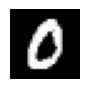

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


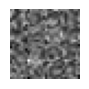




1it [00:00, 32.59it/s]


Processing Timesteps for Image 12:  44%|████▍     | 15/34 [00:36<00:47,  2.48s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 421
Processing Number: 0, Image Order: 12, Timestep: 451
clean analyze Raw Data


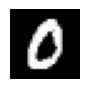

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


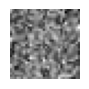




1it [00:00, 33.54it/s]


Processing Timesteps for Image 12:  47%|████▋     | 16/34 [00:39<00:45,  2.55s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 451
Processing Number: 0, Image Order: 12, Timestep: 481
clean analyze Raw Data


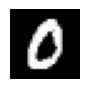

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


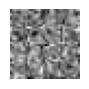




1it [00:00, 35.62it/s]


Processing Timesteps for Image 12:  50%|█████     | 17/34 [00:41<00:41,  2.44s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 481
Processing Number: 0, Image Order: 12, Timestep: 511
clean analyze Raw Data


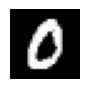

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


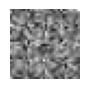




1it [00:00, 36.99it/s]


Processing Timesteps for Image 12:  53%|█████▎    | 18/34 [00:43<00:37,  2.37s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 511
Processing Number: 0, Image Order: 12, Timestep: 541
clean analyze Raw Data


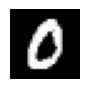

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


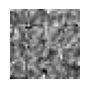




1it [00:00, 35.42it/s]


Processing Timesteps for Image 12:  56%|█████▌    | 19/34 [00:45<00:34,  2.31s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 541
Processing Number: 0, Image Order: 12, Timestep: 571
clean analyze Raw Data


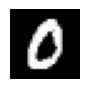

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


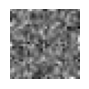




1it [00:00, 37.25it/s]


Processing Timesteps for Image 12:  59%|█████▉    | 20/34 [00:48<00:31,  2.27s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 571
Processing Number: 0, Image Order: 12, Timestep: 601
clean analyze Raw Data


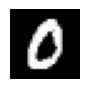

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


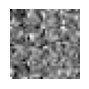




1it [00:00, 27.32it/s]


Processing Timesteps for Image 12:  62%|██████▏   | 21/34 [00:51<00:31,  2.46s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 601
Processing Number: 0, Image Order: 12, Timestep: 631
clean analyze Raw Data


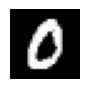

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


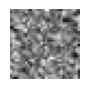




1it [00:00, 39.06it/s]


Processing Timesteps for Image 12:  65%|██████▍   | 22/34 [00:53<00:30,  2.58s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 631
Processing Number: 0, Image Order: 12, Timestep: 661
clean analyze Raw Data


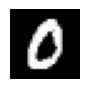

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


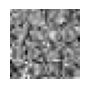




1it [00:00, 37.43it/s]


Processing Timesteps for Image 12:  68%|██████▊   | 23/34 [00:56<00:27,  2.47s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 661
Processing Number: 0, Image Order: 12, Timestep: 691
clean analyze Raw Data


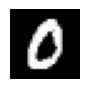

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


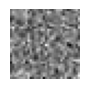




1it [00:00, 32.28it/s]


Processing Timesteps for Image 12:  71%|███████   | 24/34 [00:58<00:23,  2.39s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 691
Processing Number: 0, Image Order: 12, Timestep: 721
clean analyze Raw Data


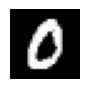

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


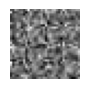




1it [00:00, 38.09it/s]


Processing Timesteps for Image 12:  74%|███████▎  | 25/34 [01:00<00:20,  2.33s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 721
Processing Number: 0, Image Order: 12, Timestep: 751
clean analyze Raw Data


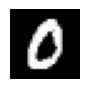

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


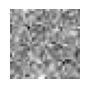




1it [00:00, 38.08it/s]


Processing Timesteps for Image 12:  76%|███████▋  | 26/34 [01:02<00:18,  2.30s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 751
Processing Number: 0, Image Order: 12, Timestep: 781
clean analyze Raw Data


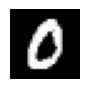

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


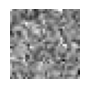




1it [00:00, 40.10it/s]


Processing Timesteps for Image 12:  79%|███████▉  | 27/34 [01:05<00:17,  2.53s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 781
Processing Number: 0, Image Order: 12, Timestep: 811
clean analyze Raw Data


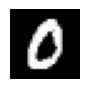

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


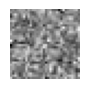




1it [00:00, 35.49it/s]


Processing Timesteps for Image 12:  82%|████████▏ | 28/34 [01:08<00:15,  2.60s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 811
Processing Number: 0, Image Order: 12, Timestep: 841
clean analyze Raw Data


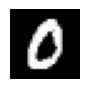

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


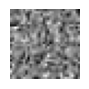




1it [00:00, 37.27it/s]


Processing Timesteps for Image 12:  85%|████████▌ | 29/34 [01:10<00:12,  2.49s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 841
Processing Number: 0, Image Order: 12, Timestep: 871
clean analyze Raw Data


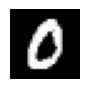

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


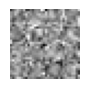




1it [00:00, 35.84it/s]


Processing Timesteps for Image 12:  88%|████████▊ | 30/34 [01:13<00:09,  2.43s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 871
Processing Number: 0, Image Order: 12, Timestep: 901
clean analyze Raw Data


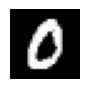

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


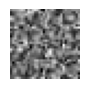




1it [00:00, 34.73it/s]


Processing Timesteps for Image 12:  91%|█████████ | 31/34 [01:15<00:07,  2.37s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 901
Processing Number: 0, Image Order: 12, Timestep: 931
clean analyze Raw Data


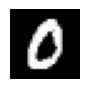

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


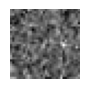




1it [00:00, 38.08it/s]


Processing Timesteps for Image 12:  94%|█████████▍| 32/34 [01:17<00:04,  2.33s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 931
Processing Number: 0, Image Order: 12, Timestep: 961
clean analyze Raw Data


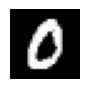

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


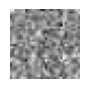




1it [00:00, 36.91it/s]


Processing Timesteps for Image 12:  97%|█████████▋| 33/34 [01:20<00:02,  2.51s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 961
Processing Number: 0, Image Order: 12, Timestep: 991
clean analyze Raw Data


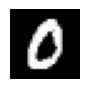

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


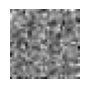




1it [00:00, 36.67it/s]


Processing Timesteps for Image 12: 100%|██████████| 34/34 [01:23<00:00,  2.61s/it]

                                                                                  
Processing Images for Number 0:  41%|████      | 13/32 [16:03<25:20, 80.03s/it]

Saved data for Number: 0, Image Order: 12, Timestep: 991




Processing Timesteps for Image 13:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 13, Timestep: 1
clean analyze Raw Data


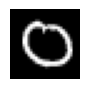

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


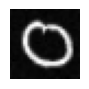




0it [00:00, ?it/s]

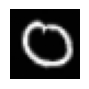

1it [00:00, 20.98it/s]


Processing Timesteps for Image 13:   3%|▎         | 1/34 [00:02<01:28,  2.68s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 1
Processing Number: 0, Image Order: 13, Timestep: 31
clean analyze Raw Data


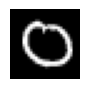

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


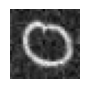




0it [00:00, ?it/s]

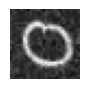

1it [00:00, 18.30it/s]


Processing Timesteps for Image 13:   6%|▌         | 2/34 [00:04<01:18,  2.45s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 31
Processing Number: 0, Image Order: 13, Timestep: 61
clean analyze Raw Data


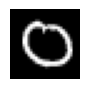

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


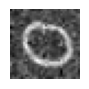




1it [00:00, 35.41it/s]


Processing Timesteps for Image 13:   9%|▉         | 3/34 [00:07<01:12,  2.35s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 61
Processing Number: 0, Image Order: 13, Timestep: 91
clean analyze Raw Data


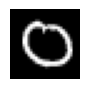

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


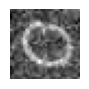




1it [00:00, 37.08it/s]


Processing Timesteps for Image 13:  12%|█▏        | 4/34 [00:09<01:08,  2.29s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 91
Processing Number: 0, Image Order: 13, Timestep: 121
clean analyze Raw Data


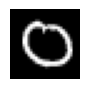

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


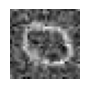




1it [00:00, 25.63it/s]


Processing Timesteps for Image 13:  15%|█▍        | 5/34 [00:12<01:13,  2.52s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 121
Processing Number: 0, Image Order: 13, Timestep: 151
clean analyze Raw Data


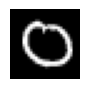

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


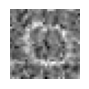




1it [00:00, 37.72it/s]


Processing Timesteps for Image 13:  18%|█▊        | 6/34 [00:15<01:13,  2.62s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 151
Processing Number: 0, Image Order: 13, Timestep: 181
clean analyze Raw Data


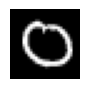

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


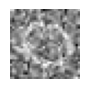




1it [00:00, 36.73it/s]


Processing Timesteps for Image 13:  21%|██        | 7/34 [00:17<01:07,  2.49s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 181
Processing Number: 0, Image Order: 13, Timestep: 211
clean analyze Raw Data


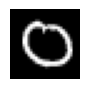

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


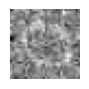




1it [00:00, 38.03it/s]


Processing Timesteps for Image 13:  24%|██▎       | 8/34 [00:19<01:03,  2.44s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 211
Processing Number: 0, Image Order: 13, Timestep: 241
clean analyze Raw Data


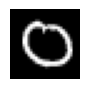

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


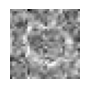




1it [00:00, 37.64it/s]


Processing Timesteps for Image 13:  26%|██▋       | 9/34 [00:21<00:59,  2.37s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 241
Processing Number: 0, Image Order: 13, Timestep: 271
clean analyze Raw Data


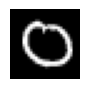

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


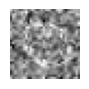




1it [00:00, 37.22it/s]


Processing Timesteps for Image 13:  29%|██▉       | 10/34 [00:24<00:55,  2.33s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 271
Processing Number: 0, Image Order: 13, Timestep: 301
clean analyze Raw Data


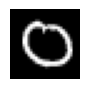

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


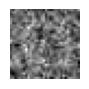




1it [00:00, 28.56it/s]


Processing Timesteps for Image 13:  32%|███▏      | 11/34 [00:27<00:57,  2.52s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 301
Processing Number: 0, Image Order: 13, Timestep: 331
clean analyze Raw Data


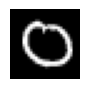

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


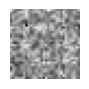




1it [00:00, 37.27it/s]


Processing Timesteps for Image 13:  35%|███▌      | 12/34 [00:29<00:57,  2.63s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 331
Processing Number: 0, Image Order: 13, Timestep: 361
clean analyze Raw Data


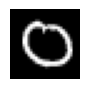

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


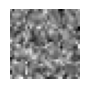




1it [00:00, 33.10it/s]


Processing Timesteps for Image 13:  38%|███▊      | 13/34 [00:32<00:52,  2.50s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 361
Processing Number: 0, Image Order: 13, Timestep: 391
clean analyze Raw Data


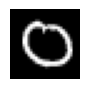

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


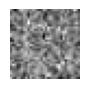




1it [00:00, 37.67it/s]


Processing Timesteps for Image 13:  41%|████      | 14/34 [00:34<00:48,  2.41s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 391
Processing Number: 0, Image Order: 13, Timestep: 421
clean analyze Raw Data


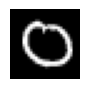

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


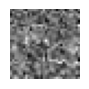




1it [00:00, 37.79it/s]


Processing Timesteps for Image 13:  44%|████▍     | 15/34 [00:36<00:44,  2.35s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 421
Processing Number: 0, Image Order: 13, Timestep: 451
clean analyze Raw Data


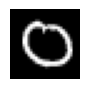

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


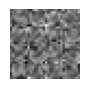




1it [00:00, 37.11it/s]


Processing Timesteps for Image 13:  47%|████▋     | 16/34 [00:38<00:41,  2.31s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 451
Processing Number: 0, Image Order: 13, Timestep: 481
clean analyze Raw Data


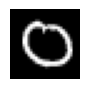

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


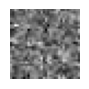




1it [00:00, 32.12it/s]


Processing Timesteps for Image 13:  50%|█████     | 17/34 [00:41<00:42,  2.49s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 481
Processing Number: 0, Image Order: 13, Timestep: 511
clean analyze Raw Data


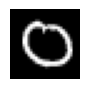

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


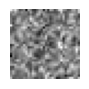




1it [00:00, 36.80it/s]


Processing Timesteps for Image 13:  53%|█████▎    | 18/34 [00:44<00:41,  2.60s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 511
Processing Number: 0, Image Order: 13, Timestep: 541
clean analyze Raw Data


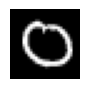

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


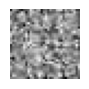




1it [00:00, 37.31it/s]


Processing Timesteps for Image 13:  56%|█████▌    | 19/34 [00:46<00:37,  2.48s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 541
Processing Number: 0, Image Order: 13, Timestep: 571
clean analyze Raw Data


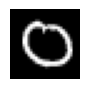

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


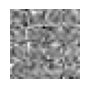




1it [00:00, 37.82it/s]


Processing Timesteps for Image 13:  59%|█████▉    | 20/34 [00:49<00:33,  2.41s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 571
Processing Number: 0, Image Order: 13, Timestep: 601
clean analyze Raw Data


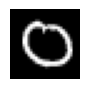

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


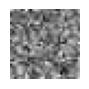




1it [00:00, 35.63it/s]


Processing Timesteps for Image 13:  62%|██████▏   | 21/34 [00:51<00:30,  2.36s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 601
Processing Number: 0, Image Order: 13, Timestep: 631
clean analyze Raw Data


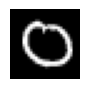

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


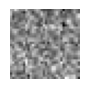




1it [00:00, 37.70it/s]


Processing Timesteps for Image 13:  65%|██████▍   | 22/34 [00:53<00:27,  2.32s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 631
Processing Number: 0, Image Order: 13, Timestep: 661
clean analyze Raw Data


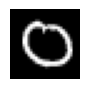

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


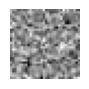




1it [00:00, 25.60it/s]


Processing Timesteps for Image 13:  68%|██████▊   | 23/34 [00:56<00:27,  2.50s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 661
Processing Number: 0, Image Order: 13, Timestep: 691
clean analyze Raw Data


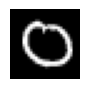

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


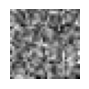




1it [00:00, 38.33it/s]


Processing Timesteps for Image 13:  71%|███████   | 24/34 [00:59<00:26,  2.61s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 691
Processing Number: 0, Image Order: 13, Timestep: 721
clean analyze Raw Data


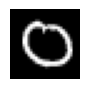

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


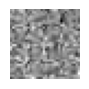




1it [00:00, 38.05it/s]


Processing Timesteps for Image 13:  74%|███████▎  | 25/34 [01:01<00:22,  2.53s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 721
Processing Number: 0, Image Order: 13, Timestep: 751
clean analyze Raw Data


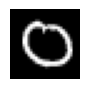

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


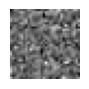




1it [00:00, 39.73it/s]


Processing Timesteps for Image 13:  76%|███████▋  | 26/34 [01:04<00:21,  2.66s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 751
Processing Number: 0, Image Order: 13, Timestep: 781
clean analyze Raw Data


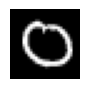

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


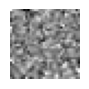




1it [00:00, 37.56it/s]


Processing Timesteps for Image 13:  79%|███████▉  | 27/34 [01:07<00:19,  2.72s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 781
Processing Number: 0, Image Order: 13, Timestep: 811
clean analyze Raw Data


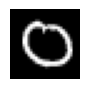

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


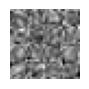




1it [00:00, 33.29it/s]


Processing Timesteps for Image 13:  82%|████████▏ | 28/34 [01:09<00:15,  2.65s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 811
Processing Number: 0, Image Order: 13, Timestep: 841
clean analyze Raw Data


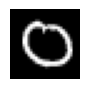

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


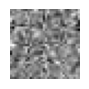




1it [00:00, 27.97it/s]


Processing Timesteps for Image 13:  85%|████████▌ | 29/34 [01:13<00:13,  2.78s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 841
Processing Number: 0, Image Order: 13, Timestep: 871
clean analyze Raw Data


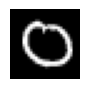

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


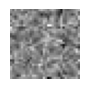




1it [00:00, 37.51it/s]


Processing Timesteps for Image 13:  88%|████████▊ | 30/34 [01:15<00:10,  2.65s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 871
Processing Number: 0, Image Order: 13, Timestep: 901
clean analyze Raw Data


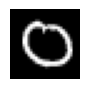

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


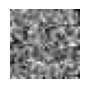




1it [00:00, 38.67it/s]


Processing Timesteps for Image 13:  91%|█████████ | 31/34 [01:17<00:07,  2.52s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 901
Processing Number: 0, Image Order: 13, Timestep: 931
clean analyze Raw Data


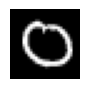

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


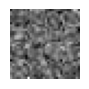




1it [00:00, 37.17it/s]


Processing Timesteps for Image 13:  94%|█████████▍| 32/34 [01:19<00:04,  2.44s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 931
Processing Number: 0, Image Order: 13, Timestep: 961
clean analyze Raw Data


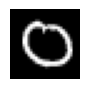

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


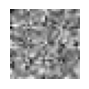




1it [00:00, 36.43it/s]


Processing Timesteps for Image 13:  97%|█████████▋| 33/34 [01:22<00:02,  2.38s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 961
Processing Number: 0, Image Order: 13, Timestep: 991
clean analyze Raw Data


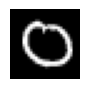

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


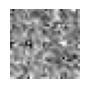




1it [00:00, 35.01it/s]


Processing Timesteps for Image 13: 100%|██████████| 34/34 [01:24<00:00,  2.46s/it]

                                                                                  
Processing Images for Number 0:  44%|████▍     | 14/32 [17:28<24:26, 81.45s/it]

Saved data for Number: 0, Image Order: 13, Timestep: 991




Processing Timesteps for Image 14:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 14, Timestep: 1
clean analyze Raw Data


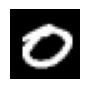

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


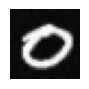




0it [00:00, ?it/s]

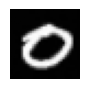

1it [00:00, 22.05it/s]


Processing Timesteps for Image 14:   3%|▎         | 1/34 [00:03<01:42,  3.09s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 1
Processing Number: 0, Image Order: 14, Timestep: 31
clean analyze Raw Data


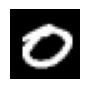

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


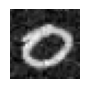




0it [00:00, ?it/s]

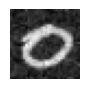

1it [00:00, 20.83it/s]


Processing Timesteps for Image 14:   6%|▌         | 2/34 [00:05<01:35,  2.97s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 31
Processing Number: 0, Image Order: 14, Timestep: 61
clean analyze Raw Data


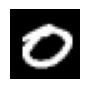

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


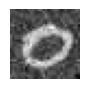




1it [00:00, 38.04it/s]


Processing Timesteps for Image 14:   9%|▉         | 3/34 [00:08<01:22,  2.66s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 61
Processing Number: 0, Image Order: 14, Timestep: 91
clean analyze Raw Data


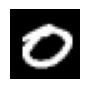

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


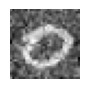




1it [00:00, 30.29it/s]


Processing Timesteps for Image 14:  12%|█▏        | 4/34 [00:10<01:15,  2.50s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 91
Processing Number: 0, Image Order: 14, Timestep: 121
clean analyze Raw Data


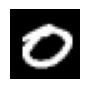

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


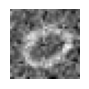




1it [00:00, 38.46it/s]


Processing Timesteps for Image 14:  15%|█▍        | 5/34 [00:12<01:09,  2.40s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 121
Processing Number: 0, Image Order: 14, Timestep: 151
clean analyze Raw Data


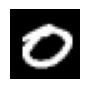

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


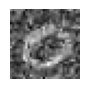




1it [00:00, 38.31it/s]


Processing Timesteps for Image 14:  18%|█▊        | 6/34 [00:15<01:12,  2.58s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 151
Processing Number: 0, Image Order: 14, Timestep: 181
clean analyze Raw Data


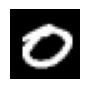

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


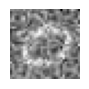




1it [00:00, 38.40it/s]


Processing Timesteps for Image 14:  21%|██        | 7/34 [00:18<01:12,  2.70s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 181
Processing Number: 0, Image Order: 14, Timestep: 211
clean analyze Raw Data


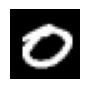

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


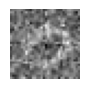




1it [00:00, 36.33it/s]


Processing Timesteps for Image 14:  24%|██▎       | 8/34 [00:20<01:06,  2.55s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 211
Processing Number: 0, Image Order: 14, Timestep: 241
clean analyze Raw Data


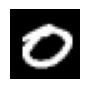

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


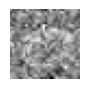




1it [00:00, 37.60it/s]


Processing Timesteps for Image 14:  26%|██▋       | 9/34 [00:23<01:01,  2.45s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 241
Processing Number: 0, Image Order: 14, Timestep: 271
clean analyze Raw Data


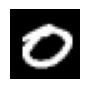

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


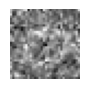




1it [00:00, 37.97it/s]


Processing Timesteps for Image 14:  29%|██▉       | 10/34 [00:25<00:57,  2.38s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 271
Processing Number: 0, Image Order: 14, Timestep: 301
clean analyze Raw Data


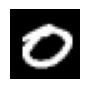

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


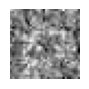




1it [00:00, 35.86it/s]


Processing Timesteps for Image 14:  32%|███▏      | 11/34 [00:27<00:53,  2.34s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 301
Processing Number: 0, Image Order: 14, Timestep: 331
clean analyze Raw Data


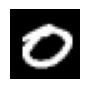

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


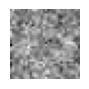




1it [00:00, 31.40it/s]


Processing Timesteps for Image 14:  35%|███▌      | 12/34 [00:30<00:55,  2.51s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 331
Processing Number: 0, Image Order: 14, Timestep: 361
clean analyze Raw Data


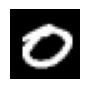

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


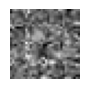




1it [00:00, 37.94it/s]


Processing Timesteps for Image 14:  38%|███▊      | 13/34 [00:33<00:55,  2.64s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 361
Processing Number: 0, Image Order: 14, Timestep: 391
clean analyze Raw Data


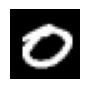

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


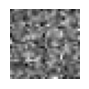




1it [00:00, 37.71it/s]


Processing Timesteps for Image 14:  41%|████      | 14/34 [00:35<00:50,  2.53s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 391
Processing Number: 0, Image Order: 14, Timestep: 421
clean analyze Raw Data


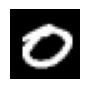

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


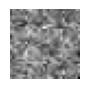




1it [00:00, 38.55it/s]


Processing Timesteps for Image 14:  44%|████▍     | 15/34 [00:37<00:46,  2.45s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 421
Processing Number: 0, Image Order: 14, Timestep: 451
clean analyze Raw Data


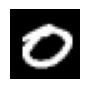

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


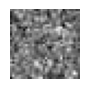




1it [00:00, 37.42it/s]


Processing Timesteps for Image 14:  47%|████▋     | 16/34 [00:40<00:42,  2.38s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 451
Processing Number: 0, Image Order: 14, Timestep: 481
clean analyze Raw Data


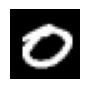

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


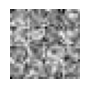




1it [00:00, 37.62it/s]


Processing Timesteps for Image 14:  50%|█████     | 17/34 [00:42<00:39,  2.35s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 481
Processing Number: 0, Image Order: 14, Timestep: 511
clean analyze Raw Data


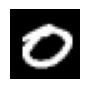

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


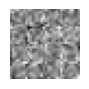




1it [00:00, 34.64it/s]


Processing Timesteps for Image 14:  53%|█████▎    | 18/34 [00:45<00:40,  2.50s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 511
Processing Number: 0, Image Order: 14, Timestep: 541
clean analyze Raw Data


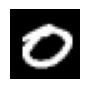

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


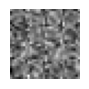




1it [00:00, 35.21it/s]


Processing Timesteps for Image 14:  56%|█████▌    | 19/34 [00:48<00:39,  2.63s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 541
Processing Number: 0, Image Order: 14, Timestep: 571
clean analyze Raw Data


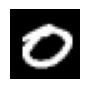

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


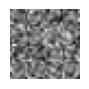




1it [00:00, 38.72it/s]


Processing Timesteps for Image 14:  59%|█████▉    | 20/34 [00:50<00:35,  2.51s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 571
Processing Number: 0, Image Order: 14, Timestep: 601
clean analyze Raw Data


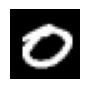

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


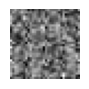




1it [00:00, 37.54it/s]


Processing Timesteps for Image 14:  62%|██████▏   | 21/34 [00:52<00:31,  2.43s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 601
Processing Number: 0, Image Order: 14, Timestep: 631
clean analyze Raw Data


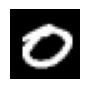

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


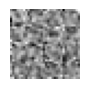




1it [00:00, 40.00it/s]


Processing Timesteps for Image 14:  65%|██████▍   | 22/34 [00:55<00:29,  2.43s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 631
Processing Number: 0, Image Order: 14, Timestep: 661
clean analyze Raw Data


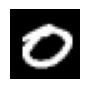

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


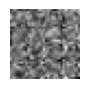




1it [00:00, 38.38it/s]


Processing Timesteps for Image 14:  68%|██████▊   | 23/34 [00:57<00:26,  2.37s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 661
Processing Number: 0, Image Order: 14, Timestep: 691
clean analyze Raw Data


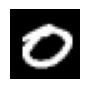

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


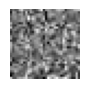




1it [00:00, 39.35it/s]


Processing Timesteps for Image 14:  71%|███████   | 24/34 [01:00<00:25,  2.54s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 691
Processing Number: 0, Image Order: 14, Timestep: 721
clean analyze Raw Data


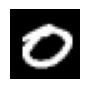

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


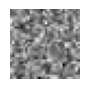




1it [00:00, 34.80it/s]


Processing Timesteps for Image 14:  74%|███████▎  | 25/34 [01:03<00:23,  2.66s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 721
Processing Number: 0, Image Order: 14, Timestep: 751
clean analyze Raw Data


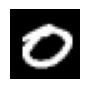

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


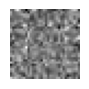




1it [00:00, 37.83it/s]


Processing Timesteps for Image 14:  76%|███████▋  | 26/34 [01:05<00:20,  2.54s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 751
Processing Number: 0, Image Order: 14, Timestep: 781
clean analyze Raw Data


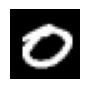

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


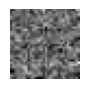




1it [00:00, 38.17it/s]


Processing Timesteps for Image 14:  79%|███████▉  | 27/34 [01:07<00:17,  2.45s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 781
Processing Number: 0, Image Order: 14, Timestep: 811
clean analyze Raw Data


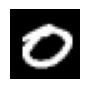

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


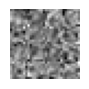




1it [00:00, 38.40it/s]


Processing Timesteps for Image 14:  82%|████████▏ | 28/34 [01:09<00:14,  2.39s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 811
Processing Number: 0, Image Order: 14, Timestep: 841
clean analyze Raw Data


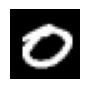

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


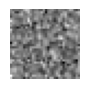




1it [00:00, 36.84it/s]


Processing Timesteps for Image 14:  85%|████████▌ | 29/34 [01:12<00:11,  2.36s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 841
Processing Number: 0, Image Order: 14, Timestep: 871
clean analyze Raw Data


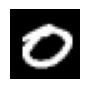

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


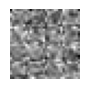




1it [00:00, 30.00it/s]


Processing Timesteps for Image 14:  88%|████████▊ | 30/34 [01:15<00:10,  2.52s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 871
Processing Number: 0, Image Order: 14, Timestep: 901
clean analyze Raw Data


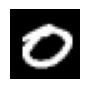

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


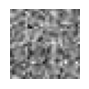




1it [00:00, 37.65it/s]


Processing Timesteps for Image 14:  91%|█████████ | 31/34 [01:18<00:07,  2.65s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 901
Processing Number: 0, Image Order: 14, Timestep: 931
clean analyze Raw Data


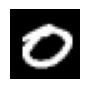

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


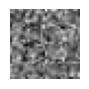




1it [00:00, 38.21it/s]


Processing Timesteps for Image 14:  94%|█████████▍| 32/34 [01:20<00:05,  2.53s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 931
Processing Number: 0, Image Order: 14, Timestep: 961
clean analyze Raw Data


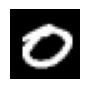

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


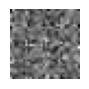




1it [00:00, 37.34it/s]


Processing Timesteps for Image 14:  97%|█████████▋| 33/34 [01:22<00:02,  2.45s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 961
Processing Number: 0, Image Order: 14, Timestep: 991
clean analyze Raw Data


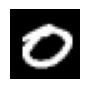

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


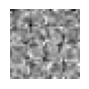




1it [00:00, 37.08it/s]


Processing Timesteps for Image 14: 100%|██████████| 34/34 [01:24<00:00,  2.39s/it]

                                                                                  
Processing Images for Number 0:  47%|████▋     | 15/32 [18:53<23:22, 82.48s/it]

Saved data for Number: 0, Image Order: 14, Timestep: 991




Processing Timesteps for Image 15:   0%|          | 0/34 [00:00<?, ?it/s]

Processing Number: 0, Image Order: 15, Timestep: 1
clean analyze Raw Data


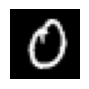

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


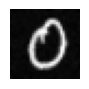




0it [00:00, ?it/s]

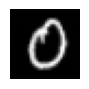

1it [00:00, 21.19it/s]


Processing Timesteps for Image 15:   3%|▎         | 1/34 [00:02<01:31,  2.78s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 1
Processing Number: 0, Image Order: 15, Timestep: 31
clean analyze Raw Data


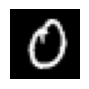

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


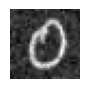




0it [00:00, ?it/s]

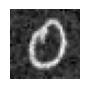

1it [00:00, 17.06it/s]


Processing Timesteps for Image 15:   6%|▌         | 2/34 [00:05<01:32,  2.88s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 31
Processing Number: 0, Image Order: 15, Timestep: 61
clean analyze Raw Data


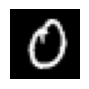

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


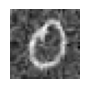




1it [00:00, 37.03it/s]


Processing Timesteps for Image 15:   9%|▉         | 3/34 [00:08<01:33,  3.02s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 61
Processing Number: 0, Image Order: 15, Timestep: 91
clean analyze Raw Data


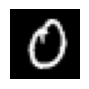

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


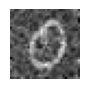




1it [00:00, 37.66it/s]


Processing Timesteps for Image 15:  12%|█▏        | 4/34 [00:11<01:21,  2.73s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 91
Processing Number: 0, Image Order: 15, Timestep: 121
clean analyze Raw Data


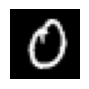

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


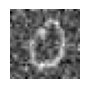




1it [00:00, 38.36it/s]


Processing Timesteps for Image 15:  15%|█▍        | 5/34 [00:13<01:14,  2.56s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 121
Processing Number: 0, Image Order: 15, Timestep: 151
clean analyze Raw Data


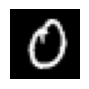

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


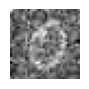




1it [00:00, 38.31it/s]


Processing Timesteps for Image 15:  18%|█▊        | 6/34 [00:15<01:09,  2.47s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 151
Processing Number: 0, Image Order: 15, Timestep: 181
clean analyze Raw Data


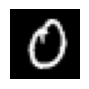

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


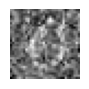




1it [00:00, 38.35it/s]


Processing Timesteps for Image 15:  21%|██        | 7/34 [00:18<01:04,  2.40s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 181
Processing Number: 0, Image Order: 15, Timestep: 211
clean analyze Raw Data


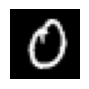

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


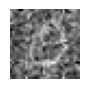




1it [00:00, 29.29it/s]


Processing Timesteps for Image 15:  24%|██▎       | 8/34 [00:20<01:06,  2.56s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 211
Processing Number: 0, Image Order: 15, Timestep: 241
clean analyze Raw Data


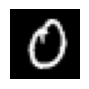

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


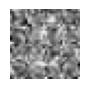




1it [00:00, 35.38it/s]


Processing Timesteps for Image 15:  26%|██▋       | 9/34 [00:23<01:07,  2.68s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 241
Processing Number: 0, Image Order: 15, Timestep: 271
clean analyze Raw Data


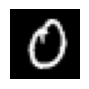

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


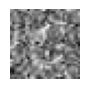




1it [00:00, 37.22it/s]


Processing Timesteps for Image 15:  29%|██▉       | 10/34 [00:26<01:01,  2.55s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 271
Processing Number: 0, Image Order: 15, Timestep: 301
clean analyze Raw Data


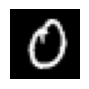

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


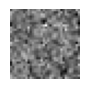




1it [00:00, 35.14it/s]


Processing Timesteps for Image 15:  32%|███▏      | 11/34 [00:28<00:56,  2.47s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 301
Processing Number: 0, Image Order: 15, Timestep: 331
clean analyze Raw Data


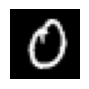

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


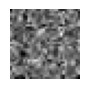




1it [00:00, 36.75it/s]


Processing Timesteps for Image 15:  35%|███▌      | 12/34 [00:30<00:53,  2.42s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 331
Processing Number: 0, Image Order: 15, Timestep: 361
clean analyze Raw Data


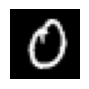

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


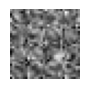




1it [00:00, 38.14it/s]


Processing Timesteps for Image 15:  38%|███▊      | 13/34 [00:32<00:49,  2.37s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 361
Processing Number: 0, Image Order: 15, Timestep: 391
clean analyze Raw Data


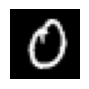

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


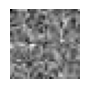




1it [00:00, 36.45it/s]


Processing Timesteps for Image 15:  41%|████      | 14/34 [00:35<00:50,  2.53s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 391
Processing Number: 0, Image Order: 15, Timestep: 421
clean analyze Raw Data


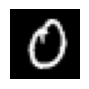

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


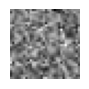




1it [00:00, 37.97it/s]


Processing Timesteps for Image 15:  44%|████▍     | 15/34 [00:38<00:50,  2.68s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 421
Processing Number: 0, Image Order: 15, Timestep: 451
clean analyze Raw Data


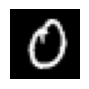

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


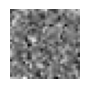




1it [00:00, 37.87it/s]


Processing Timesteps for Image 15:  47%|████▋     | 16/34 [00:41<00:46,  2.57s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 451
Processing Number: 0, Image Order: 15, Timestep: 481
clean analyze Raw Data


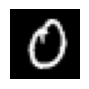

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


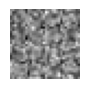




1it [00:00, 37.00it/s]


Processing Timesteps for Image 15:  50%|█████     | 17/34 [00:43<00:42,  2.49s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 481
Processing Number: 0, Image Order: 15, Timestep: 511
clean analyze Raw Data


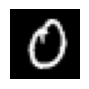

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


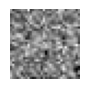




1it [00:00, 37.88it/s]


Processing Timesteps for Image 15:  53%|█████▎    | 18/34 [00:45<00:38,  2.43s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 511
Processing Number: 0, Image Order: 15, Timestep: 541
clean analyze Raw Data


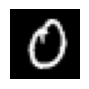

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


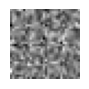




1it [00:00, 38.10it/s]


Processing Timesteps for Image 15:  56%|█████▌    | 19/34 [00:48<00:35,  2.38s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 541
Processing Number: 0, Image Order: 15, Timestep: 571
clean analyze Raw Data


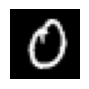

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


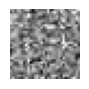




1it [00:00, 37.10it/s]


Processing Timesteps for Image 15:  59%|█████▉    | 20/34 [00:51<00:36,  2.59s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 571
Processing Number: 0, Image Order: 15, Timestep: 601
clean analyze Raw Data


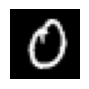

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


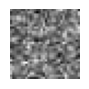




1it [00:00, 36.06it/s]


Processing Timesteps for Image 15:  62%|██████▏   | 21/34 [00:54<00:35,  2.70s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 601
Processing Number: 0, Image Order: 15, Timestep: 631
clean analyze Raw Data


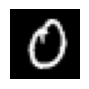

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


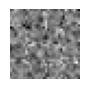




1it [00:00, 38.35it/s]


Processing Timesteps for Image 15:  65%|██████▍   | 22/34 [00:56<00:31,  2.59s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 631
Processing Number: 0, Image Order: 15, Timestep: 661
clean analyze Raw Data


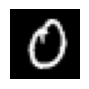

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


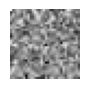




1it [00:00, 37.32it/s]


Processing Timesteps for Image 15:  68%|██████▊   | 23/34 [00:59<00:29,  2.71s/it]

Saved data for Number: 0, Image Order: 15, Timestep: 661
Processing Number: 0, Image Order: 15, Timestep: 691
clean analyze Raw Data


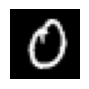

./CheckpointsMNIST/200epoch.pt
Absolute path of the noisy image: /content/SampledImgsMNIST/NoisyNoGuidenceImgs199.png
origin x_t


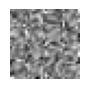




1it [00:00, 33.16it/s]


Processing Timesteps for Image 15:  71%|███████   | 24/34 [01:02<00:27,  2.76s/it]

In [ ]:
from tqdm import tqdm

# Initialize a dictionary to store experiment data
experiment_data = {}

# Iterate over numbers 0 to 9
for number in tqdm(range(10), desc="Processing Numbers"):
    experiment_data[number] = {}

    # Iterate over 32 images for each number
    for image_order in tqdm(range(32), desc=f"Processing Images for Number {number}", leave=False):
        experiment_data[number][image_order] = {
            'hspace': [],
            'img': [],
            'eps': []
        }

        # Process each timestep
        for time_step in tqdm(range(1, trainer.T, 30), desc=f"Processing Timesteps for Image {image_order}", leave=False):
            print(f"Processing Number: {number}, Image Order: {image_order}, Timestep: {time_step}")

            # Clear the analyzer
            analyzer.clean()

            # Get the image and add a batch dimension
            x_0 = images[number][image_order].unsqueeze(0)  # Add batch dimension

            # Display the original image
            show_tensor_images_grid(x_0, printImg=True)

            # Set the timestep
            t = torch.tensor([time_step], device=x_0.device)

            # Add noise to the image
            # 保證 0 <= time_step < T
            time_step = max(0, min(time_step, trainer.T - 1))
            t = torch.tensor([time_step], device=x_0.device, dtype=torch.long)
            torch.cuda.synchronize()
            x_t = trainer.addNoise(x_0, t=t)
            torch.cuda.synchronize()

            # x_t = x_t.to(model_config["device"])

            # Perform evaluation for one step
            eval_one_step(
                args=args,
                modelConfig=model_config,
                fromT=t,
                endT=t - 1,
                noisyImage=x_t
            )

            # Save hspace, eps, and img from the analyzer
            experiment_data[number][image_order]['hspace'].append(analyzer.hsapce)
            experiment_data[number][image_order]['img'].append(analyzer.img)
            experiment_data[number][image_order]['eps'].append(analyzer.eps)

            print(f"Saved data for Number: {number}, Image Order: {image_order}, Timestep: {time_step}")


In [ ]:
# save experiment data as pickle and download it
import pickle
with open('experiment_data.pkl', 'wb') as f:
    pickle.dump(experiment_data, f)
    print("Experiment data saved as experiment_data.pkl")

# download to my computer
from google.colab import files
files.download('experiment_data.pkl')

In [ ]:
model_config["device"]

In [ ]:
torch.cuda.synchronize()